## How do people tag things on OpenStreetMap?

OpenStreetMap is a collaborative, free and editable map of the world. It's an amazing resource with an incredible amount of information contributed by millions of users.

Information about an entity on OpenStreetMap, such as its name or categorical attributes, is stored as key-value pairs called "tags". For example, a park bench would likely be tagged with "amenity"="bench". If you are working with OpenStreetMap data, you may find yourself asking questions about these tagging conventions. Am I using the correct tags in my query? Am I missing any tags? What other tags are people using to describe the thing that I am querying for? These sorts of questions might be relevant if you were, for example, using OpenStreetMap data to find wheelchair accessible places (see: [Wheelmap](https://wheelmap.org/en/map#/?zoom=14)), or gathering training data for a machine learning model to recognize objects from satellite imagery using OpenStreetMap labels. The question, *"How do people tag things in OpenStreetMap?"* is a meaningful one, and it provides the motivation for this notebook.

There exist a number of tools for getting and asking questions of OpenStreetMap data:

- [Overpass API](http://wiki.openstreetmap.org/wiki/Overpass_API) serves up custom selected parts of OpenStreetMap data, enabling us to ask questions about what exists on OpenStreetMap
- [Overpass Turbo](http://overpass-turbo.eu/) is an online querying tool which runs any kind of Overpass API query and displays the results on an interactive map
- [Overpass QL](http://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL), is a query language built specifically for the Overpass API

There's even a project called [taginfo](https://taginfo.openstreetmap.org/) which collects and presents information about OpenStreetMap tags. It's an amazing resource for learning about tagging conventions across the global OSM community. But what if you want to ask questions about a particular place? Or access the raw metadata? Well, read on!

In this notebook, we will define a few python functions to:

- (1) Query the Overpass API programatically
- (2) Convert the response from Overpass API to GeoJSON
- (3) Plot the data on a leaflet map using the [folium](https://github.com/python-visualization/folium) library
    
We will download the locations, metadata and building footprints (if available) of all of the transit stations in New York City, and we will ask some questions about how people tag transit stations in New York City on OpenStreetMap.

## Searching OpenStreetMap for transit stations in NYC using Overpass Turbo

Below, we use Overpass Turbo to construct an initial query for transit stations on OpenStreetMap in the greater New York City area. Overpass Turbo relies on OverPass Query Language, which can be a bit cryptic. Luckily, however, it comes with a Query Wizard tool which can help you generate queries based on a keyword search. Overpass Turbo enables us to view selected data from OpenStreetMap on an interactive map and export the data to a variety of file types, including GeoJSON, GPX and KML. 

#### Transit Stations in the greater New York City area via Overpass Turbo

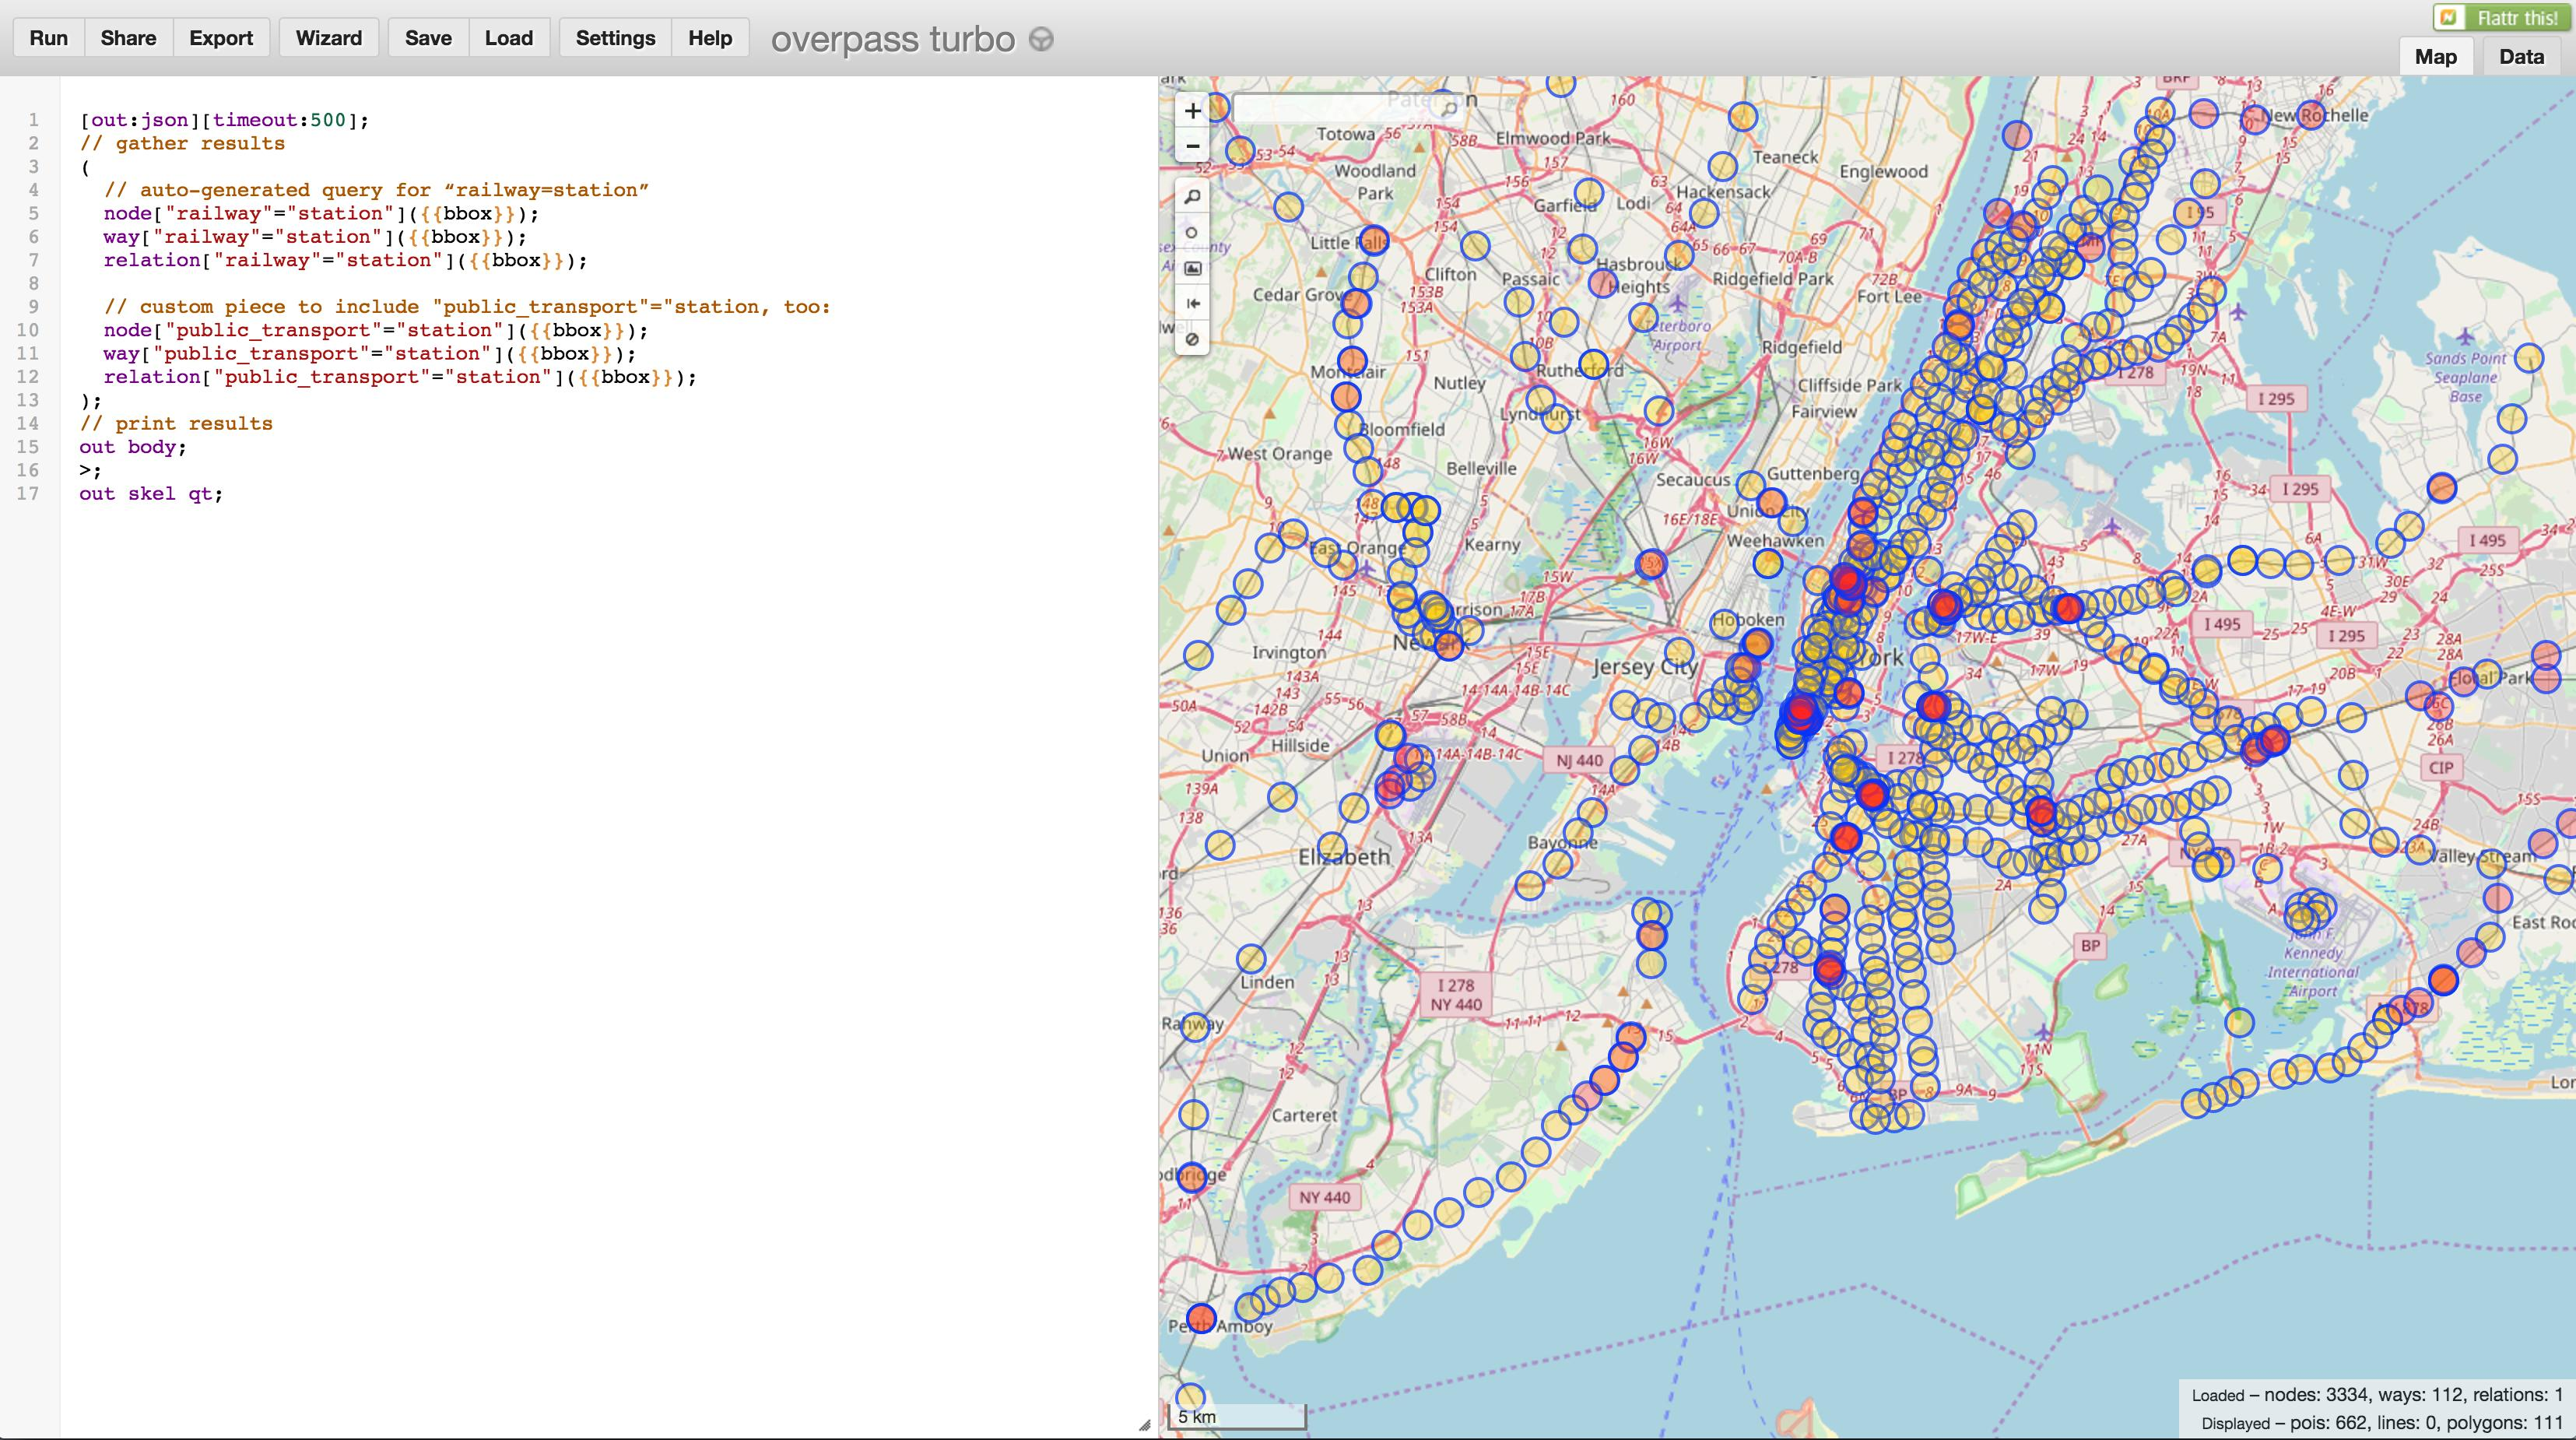

In [8]:
from IPython.display import Image
Image("https://i.imgur.com/1pkp9Ww.jpg")

## A few python functions for querying OSM using the Overpass Turbo API

Overpass Turbo is a great tool. But what if you wanted to query OpenStreetMap programmatically and analyze the raw data? Rather than use the Overpass Turbo graphical interface, let's write a few python functions to get the data from OpenStreetMap. 

Here are three helper functions for querying OpenStreetMap data:

1. `queryOSM` writes a query to OpenStreetMap using Overpass API and returns a JSON response
2. `overpass2geojson` converts the Overpass API JSON response to GeoJSON
3. `geojson2leaflet` creates a Leaflet map from GeoJSON using the Folium library

In [26]:
import requests
import urllib
from geojson import FeatureCollection, Feature, Polygon, Point
import folium
from collections import defaultdict

Here is `queryOSM`. It takes an Overpass query and a bounding box (South, West, North, East) as arguments and returns GeoJSON.

In [10]:
def queryOSM(query, bbox):
    """Returns ways and nodes from query within bounding box"""
    
    query = query.replace("{{bbox}}", bbox)
    query_URLified = urllib.quote(query.strip())

    base_url = "https://overpass-api.de/api/interpreter?data="
    api_request = base_url + query_URLified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

Here is `overpass2geojson`. It is used within `queryOSM` to convert the Overpass JSON response to GeoJSON.

In [11]:
def overpass2geojson(data):
    
    ways = [i for i in data['elements'] if i['type'] == 'way']
    way_pois = [i for i in ways if 'tags' in i.keys()]
    
    nodes = [i for i in data['elements'] if i['type'] == 'node']
    node_pois = [i for i in nodes if 'tags' in i.keys()]
    
    print len(way_pois) + len(node_pois), "points of interest returned."
    print len(way_pois), "as ways and", len(node_pois), "as nodes."
    
    # Create indexes for lookups by way_id and node_id
    lookup_wayid = defaultdict(dict)
    lookup_nodeid = defaultdict(dict)
    lookup_pois_nodeid = defaultdict(dict) # POIs are nodes with tags
        
    # Populate indexes with info
    for i in nodes:
        lookup_nodeid[i['id']] = [i['lon'], i['lat']]
    
    for i in node_pois:
        lookup_pois_nodeid[i['id']] = i
        lookup_pois_nodeid[i['id']]["coordinates"] = lookup_nodeid[i['id']]
        lookup_pois_nodeid[i["id"]]["properties"] = i["tags"]
        lookup_pois_nodeid[i["id"]]["properties"]["id"] = i["id"]
        lookup_pois_nodeid[i["id"]]["properties"]["type"] = "node"
        lookup_pois_nodeid[i["id"]]["properties"]["@id"] = "node" + "/" + str(i["id"])
        
    for i in way_pois:
        lookup_wayid[i['id']] = i
        lookup_wayid[i['id']]["coordinates"] = [[lookup_nodeid[j] for j in i['nodes']]]
        lookup_wayid[i["id"]]["properties"] = lookup_wayid[i["id"]]["tags"]
        lookup_wayid[i["id"]]["properties"]["id"] = i["id"]
        lookup_wayid[i["id"]]["properties"]["type"] = "way"
        lookup_wayid[i["id"]]["properties"]["@id"] = "way" + "/" + str(i["id"])

    
    features = []
    
    # Append ways to features
    for i in lookup_wayid.keys():
        polygon = Polygon(lookup_wayid[i]['coordinates'])
        try:
            props = lookup_wayid[i]['properties']
            feature = Feature(geometry=polygon, properties=props)
        except:
            feature = Feature(geometry=polygon)
        features.append(feature)
        
    # Append POI nodes to features
    for i in lookup_pois_nodeid.keys():
        point = Point(lookup_pois_nodeid[i]['coordinates'])
        try:
            props = lookup_pois_nodeid[i]['tags']
            feature = Feature(geometry=point, properties=props)
        except:
            feature = Feature(geometry=point)
        features.append(feature)
        
    featureCollection = FeatureCollection(features)
    
    return featureCollection

Here is `geojson2leaflet`. It uses the folium library to create a leaflet map from the Overpass GeoJSON.

In [12]:
def geojson2leaflet(overpass_geojson, bbox, zoom_start=11, tiles="OpenStreetMap"):
    """Creates a leaflet map with popups from GeoJSON using Folium"""
    bbox = bbox.split(",")
    bbox = [float(i) for i in bbox]
    centerLat = (bbox[0] + bbox[2]) / 2
    centerLon = (bbox[1] + bbox[3]) / 2
    
    m = folium.Map(location=[centerLat, centerLon], zoom_start=zoom_start, tiles=tiles)    
    
    for i in overpass_geojson['features']:
        geom_type = i['geometry']['type'] # Point or Polygon
        coords = i['geometry']['coordinates']
        gj = folium.GeoJson(
            data = {
                'type': geom_type,
                'coordinates': coords
            })

        properties = i['properties']    
    
        html_table = """
        <table style="width:100%"> 
        """
        for key in properties.keys():
            if key != '@id':
                try:
                    html_table += """
                        <tr>
                        <td><b>{0}</b>:</td>
                        <td>{1}</td>
                        </tr>
                        <br>
                        """.format(unicode(key), unicode(properties[key]))
                    html_table += "</table>"

                    iframe = folium.IFrame(html=html_table, width=300, height=150)
                    popup = folium.Popup(iframe)
                    gj.add_child(popup)
                except:
                    pass

        gj.add_to(m)
    
    return m

## Using these functions

We are interested in how people tag transit stations in New York City. We want to know where all of the transit stations are and what tags people are using to describe them. Let's use the aforementioned functions to get and explore this data.

In [13]:
# Define your bounding box. Overpass expects bbox in the format: South, West, North, East

your_bbox = "40.460532,-74.308777,40.939452,-73.714142" # NYC

In [14]:
# Our initial query as created with Overpass Turbo Query Wizard

your_query = """
[out:json][timeout:500];
// gather results
(
  // auto-generated query for “railway=station”
  node["railway"="station"]({{bbox}});
  way["railway"="station"]({{bbox}});
  relation["railway"="station"]({{bbox}});
  
  // custom piece to include "public_transport"="station, too:
  node["public_transport"="station"]({{bbox}});
  way["public_transport"="station"]({{bbox}});
  relation["public_transport"="station"]({{bbox}});
);
// print results
out body;
>;
out skel qt;
"""

Use the `queryOSM` function to get a GeoJSON containing locations and metadata for all of the transit stations in New York City that exist on OpenStreetMap.

In [15]:
results_geojson = queryOSM(your_query, your_bbox)

768 points of interest returned.
107 as ways and 661 as nodes.


Use the `geojson2leaflet` function to make a quick map of the GeoJSON response from the previous step. Clicking on any marker or polygon will bring up a popup containing all of it's OpenStreetMap tags.

In [16]:
the_map = geojson2leaflet(results_geojson, your_bbox, tiles='cartodbpositron')

In [21]:
the_map.save("map.html")

You are now the proud owner of a map and a dataset containing every transit station in New York City that exists on OpenStreetMap!

## How do people tag transit stations in NYC on OpenStreetMap?

Now that we have a dataset containing all of the locations, footprints and metadata of transit stations in NYC, we can ask questions about how people tag these entities on OpenStreetMap.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

OpenStreetMap tags are comprised of keys and values.

First, let's see which keys are the most popular among these transit stations.

In [27]:
def key_counter(geojson):

    ways = [i for i in geojson['features'] if i['properties']['type'] == 'way']
    nodes = [i for i in geojson['features'] if i['properties']['type'] == 'node']
    ways_and_nodes = ways + nodes
    
    tag_key_counts = defaultdict(lambda: 0)
    for i in ways_and_nodes:
        tags = i['properties'].keys()
        for tag in tags:
            if i['properties'][tag] not in ({}, [], ()): # ignore empty containers
                tag_key_counts[tag] += 1            
    return tag_key_counts

In [28]:
def sort_keys_by_popularity(tag_key_counts):
    most_popular_tag_keys = pd.DataFrame(tag_key_counts.values(), tag_key_counts.keys()).sort_values(by=0, ascending = False)
    most_popular_tag_keys.columns=['Count']
    most_popular_tag_keys['Percent'] = most_popular_tag_keys['Count'] / tag_key_counts['id'] * 100
    most_popular_tag_keys['Percent (%)'] = pd.Series(["{0:.1f}%".format(val) for val in most_popular_tag_keys['Percent']], index = most_popular_tag_keys.index)
    return most_popular_tag_keys

In [29]:
key_counts = key_counter(results_geojson)
keys_by_popularity = sort_keys_by_popularity(key_counts)
keys_by_popularity.drop('id', inplace=True) # all entities have an id, so we will exclude this here
keys_by_popularity.drop('@id', inplace=True) # all entities have an @id, so we will exclude this here
keys_by_popularity[['Count', 'Percent (%)']]

Count Percent (%)
type                   768      100.0%
name                   761       99.1%
railway                700       91.1%
wheelchair             555       72.3%
network                515       67.1%
operator               340       44.3%
wikidata               262       34.1%
station                174       22.7%
wikipedia              150       19.5%
public_transport       145       18.9%
internet_access         66        8.6%
internet_access:fee     64        8.3%
area                    63        8.2%
building                58        7.6%
subway                  51        6.6%
level                   50        6.5%
source                  45        5.9%
description             26        3.4%
platforms               24        3.1%
asset_ref               24        3.1%
addr:state              22        2.9%
addr:city               20        2.6%
layer                   17        2.2%
ref                     17        2.2%
addr:postcode           16        2.1%
addr:street             15        2.0%
start_date              15        2.0%
image                   13        1.7%
usage                   13        1.7%
name:ru                 10        1.3%
...                    ...         ...
proposed:railway         2        0.3%
ref:nrhp                 2        0.3%
old_name                 1        0.1%
on_demand                1        0.1%
gnis:import_uuid         1        0.1%
tunnel                   1        0.1%
building:colour          1        0.1%
gnis:reviewed            1        0.1%
landuse                  1        0.1%
note                     1        0.1%
architect                1        0.1%
electrified              1        0.1%
end_date                 1        0.1%
heritage                 1        0.1%
created_by               1        0.1%
bench                    1        0.1%
covered                  1        0.1%
short_name               1        0.1%
historic                 1        0.1%
tourism                  1        0.1%
name:en                  1        0.1%
gnis:county_name         1        0.1%
roof:height              1        0.1%
loc_name                 1        0.1%
closed                   1        0.1%
indoor                   1        0.1%
roof:colour              1        0.1%
nris_name                1        0.1%
name:de                  1        0.1%
wifi                     1        0.1%

[84 rows x 2 columns]

In [30]:
def plot_keys(keys_by_popularity, title):

    fig, ax = plt.subplots(figsize=(10,12), dpi=300)
    ax.axis('off')
    ax.barh(range(len(keys_by_popularity)), keys_by_popularity['Percent'], align='center',
            color='lightblue')
    ax.invert_yaxis()  # labels read top-to-bottom
    count = 0
    
    
    alignment = {'horizontalalignment':'left', 'verticalalignment':'baseline', 'weight': 'bold'}
    
    for p in ax.patches:
            #ax.annotate("%.1f%%" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()))
            
            ax.annotate(keys_by_popularity.index[count], (p.get_width() + 0.05, p.get_y() + p.get_height()))
            alignment = {'horizontalalignment':'right'}
            ax.annotate("%.1f%%" % p.get_width(),(0,p.get_y() + p.get_height()), xytext=(-40,0), textcoords="offset points", fontsize=10, **alignment)
            
            ax.annotate(keys_by_popularity.index[count], (0, p.get_y() + p.get_height()), xytext=(-200, 0), 
                        textcoords='offset points')
            count += 1

    alignment = {'horizontalalignment':'left', 'weight': 'bold'}
    ax.annotate("Keyword",(0,0), xytext=(-200,10), textcoords="offset points", fontsize=9, **alignment)
    ax.annotate(title,(0,0), xytext=(0,10), textcoords="offset points", fontsize=16, **alignment)
    ax.annotate("Coverage (%)",(0,0), xytext=(-85,10), textcoords="offset points", fontsize=9, **alignment)

    fig.tight_layout()
    plt.show()
    #fig.savefig("OSM_tags.png", bbox_inches="tight")

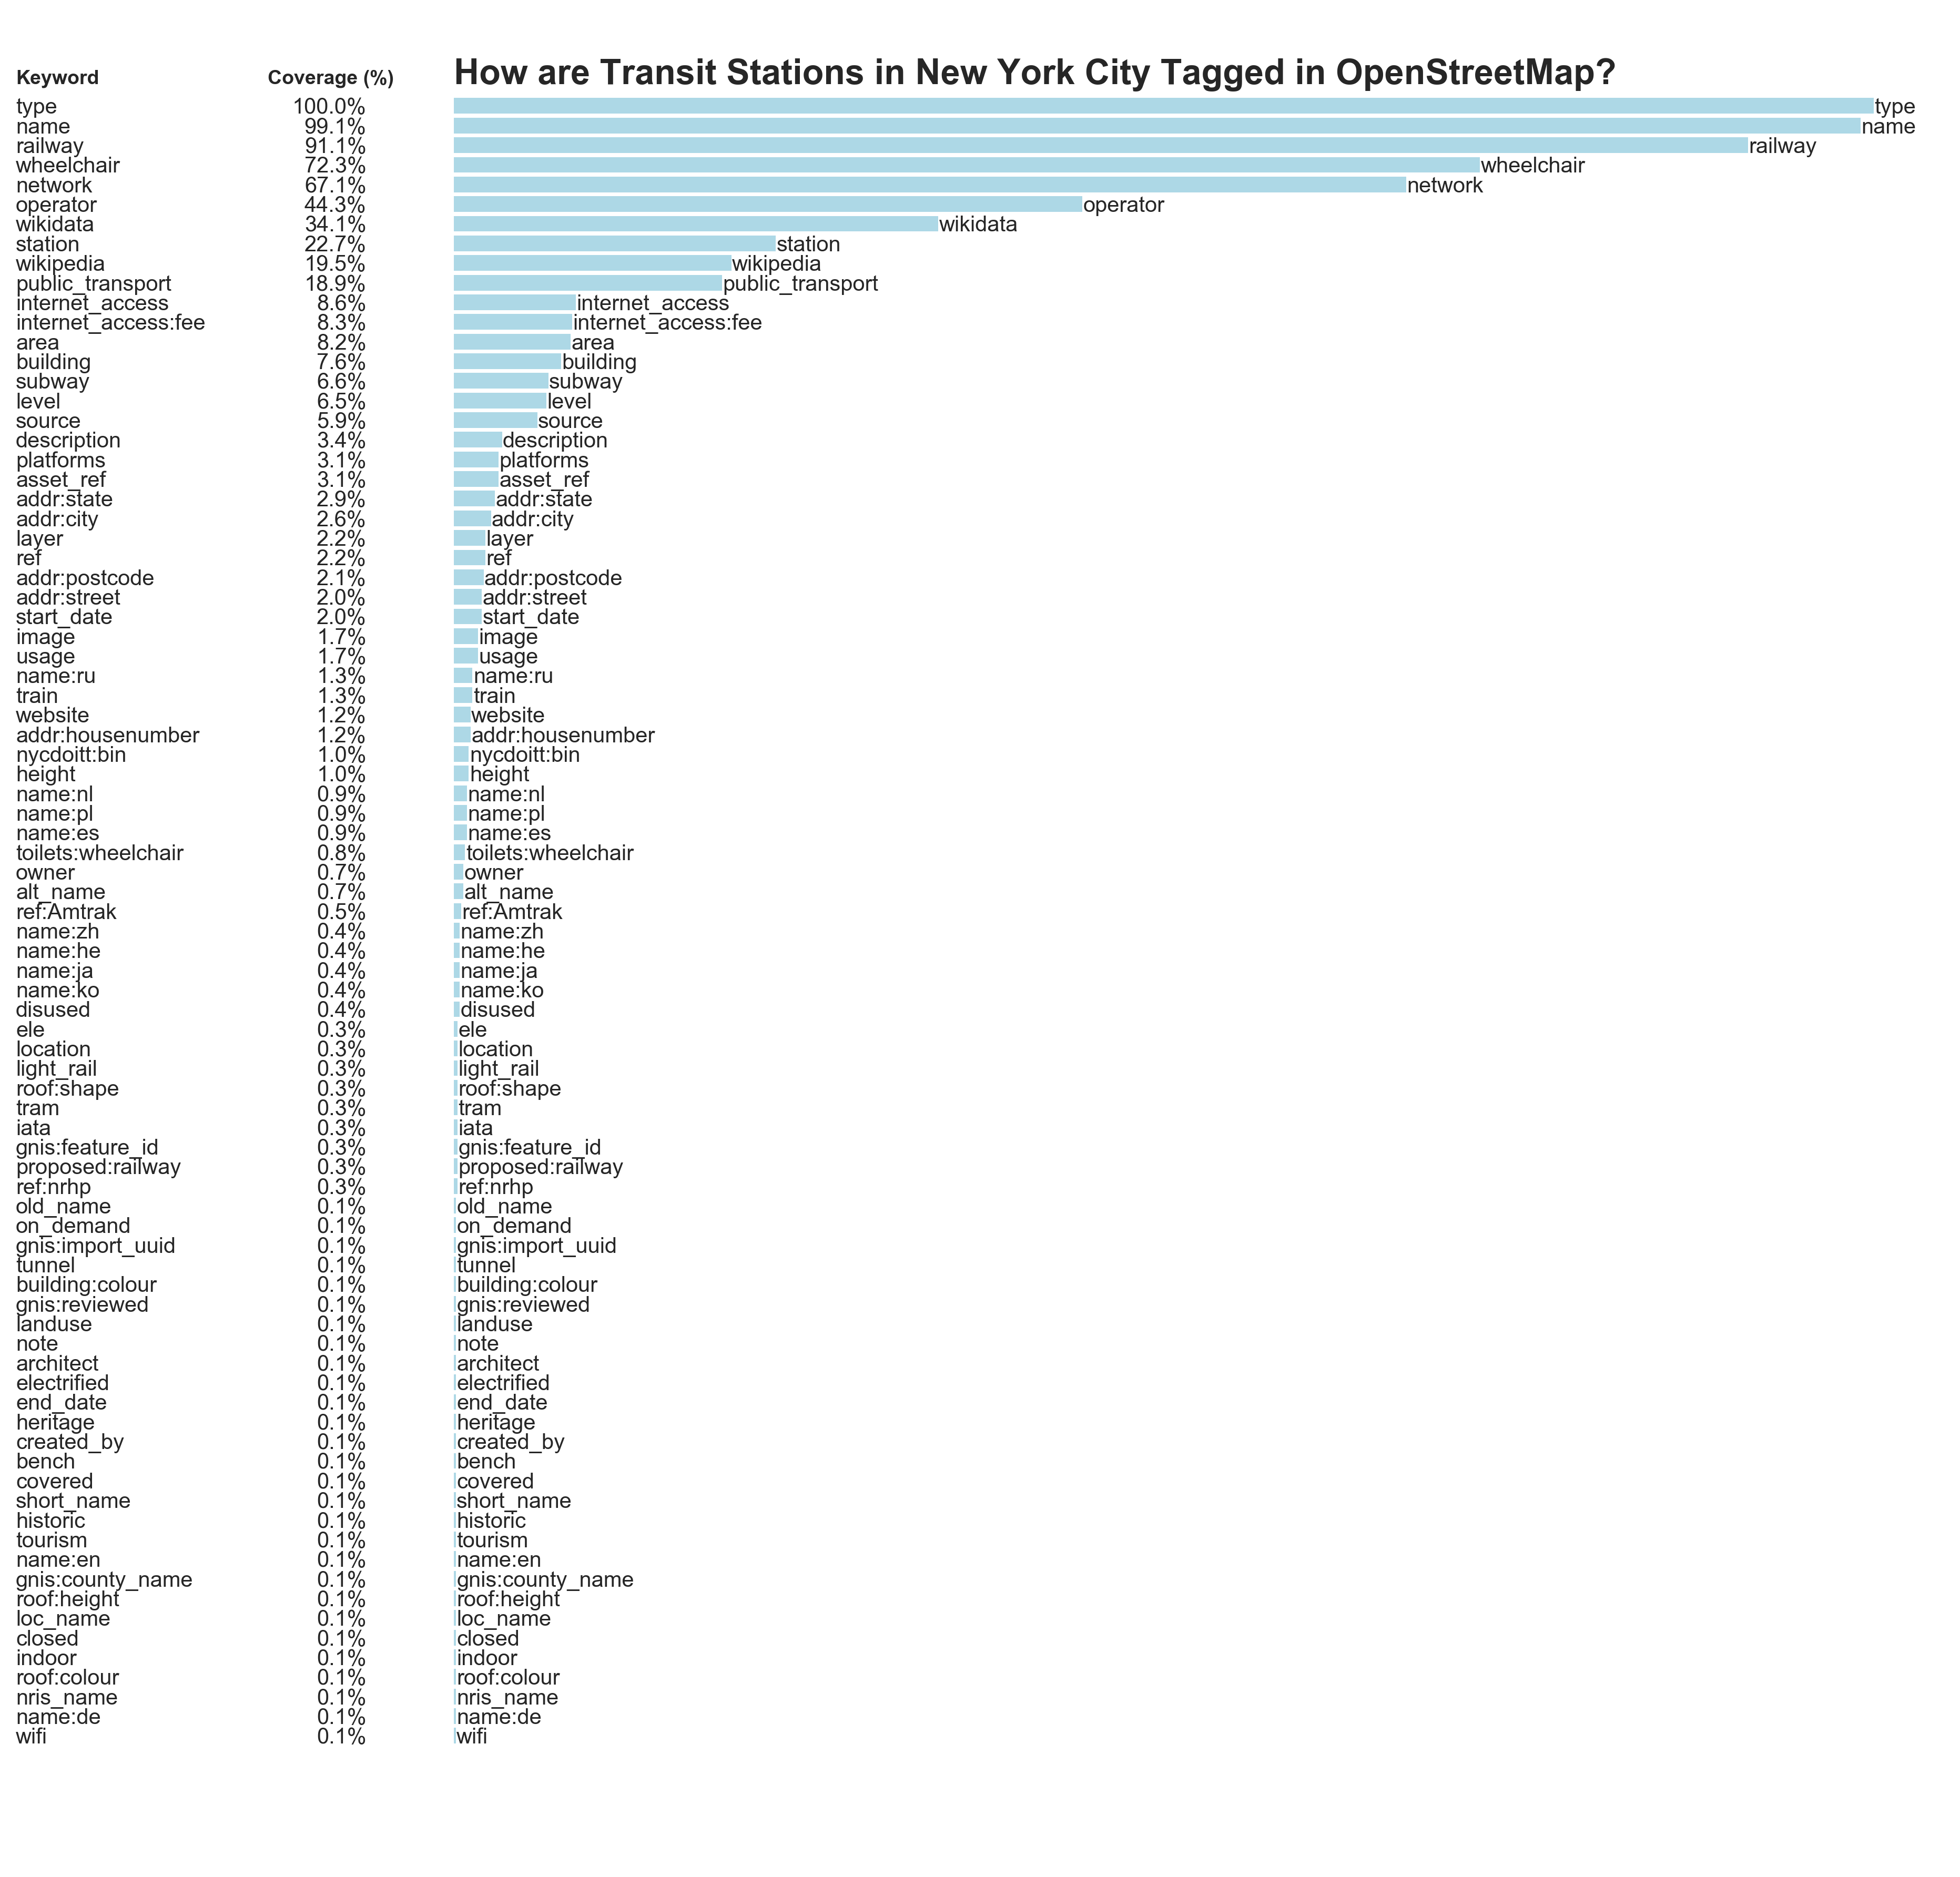

In [31]:
plot_keys(keys_by_popularity, "How are Transit Stations in New York City Tagged in OpenStreetMap?")

## Analyze key-value pairs

Get all of the OSM tag key-value pairs and assemble them into a dictionary.

In [32]:
def get_key_value_pairs(geojson):

    ways = [i for i in geojson['features'] if i['properties']['type'] == 'way']
    nodes = [i for i in geojson['features'] if i['properties']['type'] == 'node']

    ways_and_nodes = ways + nodes
    
    tag_key_value_pairs = defaultdict(lambda: [])

    for i in ways_and_nodes:
        keys = i['properties'].keys()
        for key in keys:
            if i['properties'][key] not in ({}, [], ()): # ignore empty containers
                tag_key_value_pairs[key].append(i['properties'][key])           
    
    return tag_key_value_pairs

In [33]:
key_value_pairs = get_key_value_pairs(results_geojson)

Create a pandas dataframe from the key-value pairs.

In [34]:
pd.set_option('display.max_columns', 500)

In [35]:
def make_key_value_df(key_value_pairs, geojson, most_popular_tag_keys):
    key_value_df = pd.DataFrame(index=key_value_pairs.keys(), columns=key_value_pairs['id'])
    key_value_df = key_value_df.fillna('')

    for station_id in key_value_df.columns:
        for i in geojson['features']:
            if 'id' in i['properties'].keys() and i['properties']['id'] == station_id:
                record = i['properties']
                for key in record.keys():
                    value = record[key]
                    if value not in ({}, [], ()): # ignore empty containers
                        key_value_df.loc[key, station_id] = value

    # Sort by tag key frequency
    key_value_df = key_value_df.reindex(most_popular_tag_keys.index)
    return key_value_df

In [36]:
key_value_pairs_df = make_key_value_df(key_value_pairs, results_geojson, keys_by_popularity)
key_value_pairs_df

320736264   \
type                                                     way   
name                                          Spuyten Duyvil   
railway                                              station   
wheelchair                                                     
network                                 Metro-North Railroad   
operator                                Metro-North Railroad   
wikidata                                            Q7581641   
station                                                        
wikipedia            en:Spuyten Duyvil (Metro-North station)   
public_transport                                     station   
internet_access                                                
internet_access:fee                                            
area                                                           
building                                                 yes   
subway                                                         
level                                                          
source                                                         
description                                                    
platforms                                                  2   
asset_ref                                                      
addr:state                                                NY   
addr:city                                                      
layer                                                          
ref                                                            
addr:postcode                                          10463   
addr:street                                                    
start_date                                                     
image                                                          
usage                                                          
name:ru                                                        
...                                                      ...   
proposed:railway                                               
ref:nrhp                                                       
old_name                                                       
on_demand                                                      
gnis:import_uuid                                               
tunnel                                                         
building:colour                                                
gnis:reviewed                                                  
landuse                                                        
note                                                           
architect                                                      
electrified                                                    
end_date                                                       
heritage                                                       
created_by                                                     
bench                                                          
covered                                                        
short_name                                                     
historic                                                       
tourism                                                        
name:en                                                        
gnis:county_name                                               
roof:height                                                    
loc_name                                                       
closed                                                         
indoor                                                         
roof:colour                                                    
nris_name                                                      
name:de                                                        
wifi                                                           

                           317219338                           320736271   \
type

## Make key-value histograms

In [37]:
def make_one_histogram(osm_key, key_value_pairs):
    data = pd.Series(key_value_pairs[osm_key]).value_counts()
    fig, ax = plt.subplots(figsize=(6, min(len(data.keys())*1,4)), dpi=300)
    ax.set_xlim([0, len(key_value_pairs_df.columns)+10])
    ax.axis('off')
    ax.barh(range(len(data)), data.values, align='center',
            color='lightblue')
    
    ax.invert_yaxis()  # labels read top-to-bottom
    count = 0
    for p in ax.patches:
        ax.annotate(data.values[count], (p.get_width(), p.get_y() + p.get_height()/2))
        ax.annotate(data.index[count], (p.get_width(), p.get_y() + p.get_height()/2), xytext=(20,0), textcoords="offset points")

        if count == 0:
            ax.annotate(osm_key, (0, 0),xytext=(-100, 0), textcoords='offset points', fontsize=14)
        count += 1
    fig.tight_layout()
    return fig

It only makes sense to draw histograms for keys that have a reasonable number of categories. For example, a histogram of street addresses wouldn't make much sense, but a histogram showing which values are associated with the `wheelchair` key would be useful. So, let's limit the histogram drawing to fields which have fewer than 20 unique values.

In [38]:
def make_many_histograms(key_value_pairs_df, key_value_pairs, threshold=20):
    img_count = 0
    for key in key_value_pairs_df.index:
        
        skip_id = key in ('id', '@id')
        skip_row = len(set(key_value_pairs_df.loc[key])) > threshold
        
        if not skip_id and not skip_row:
            fig = make_one_histogram(key, key_value_pairs)
            fig.savefig("plot_" + str(img_count) + '.png', bbox_inches="tight")
            img_count+=1

/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


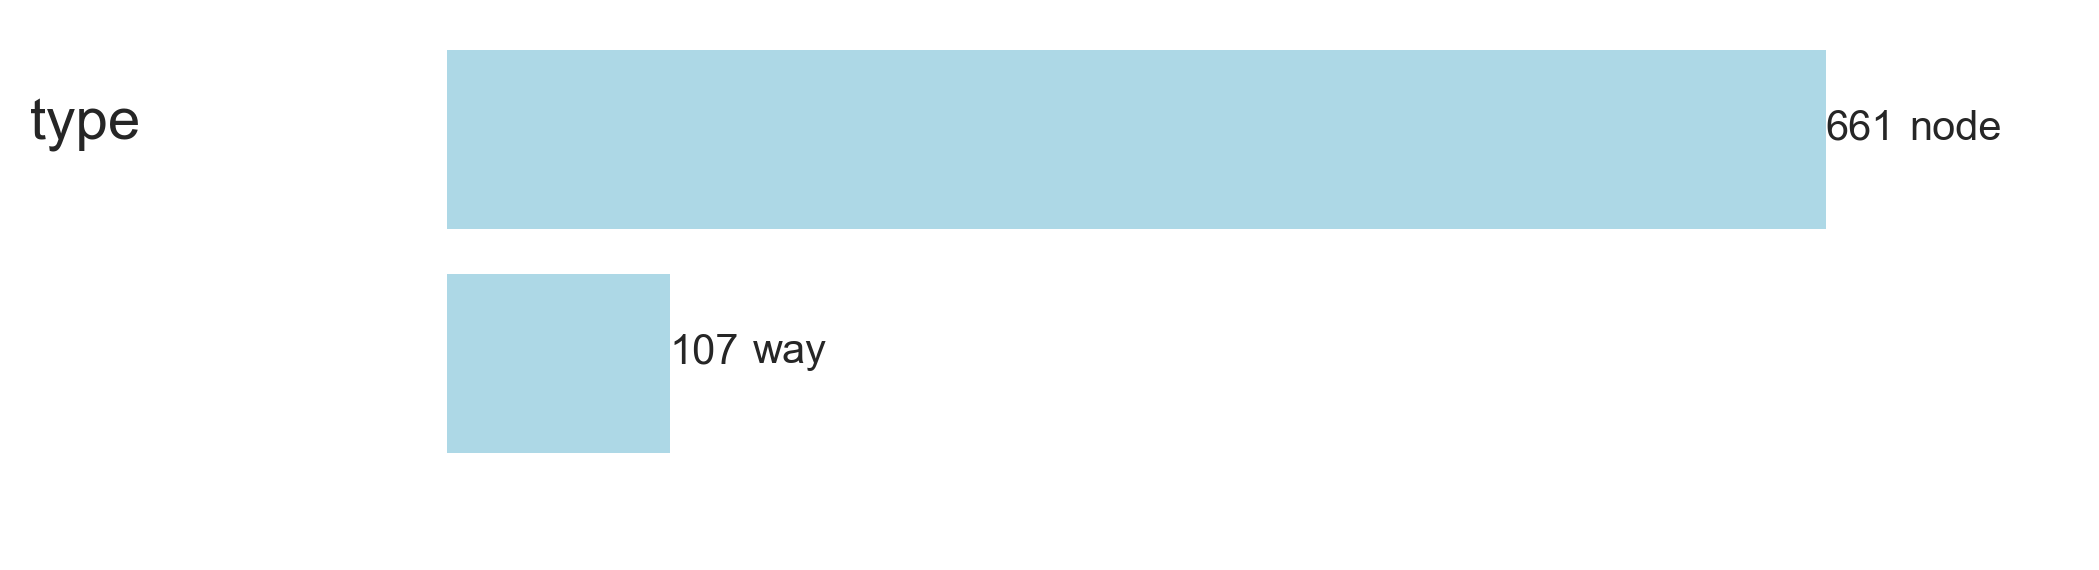

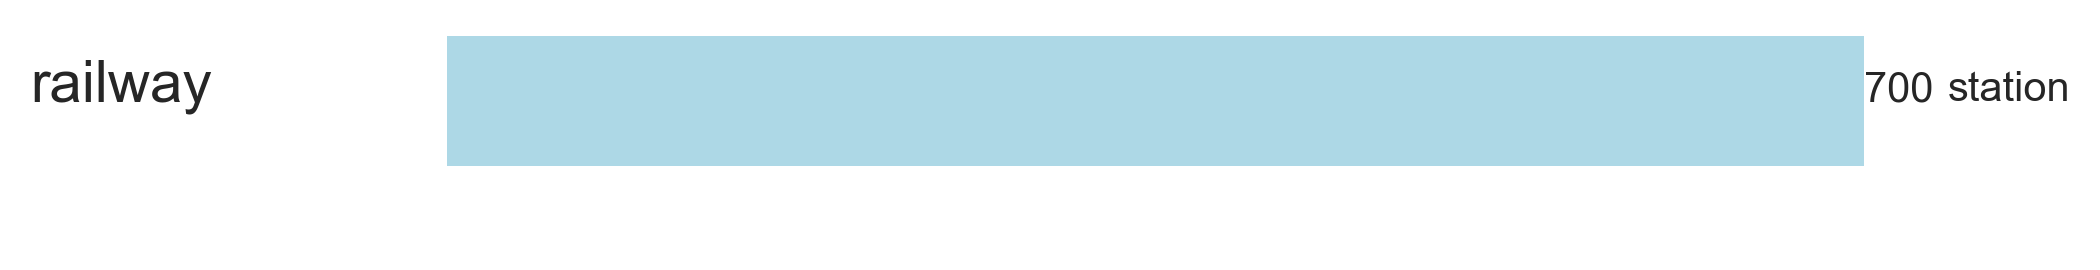

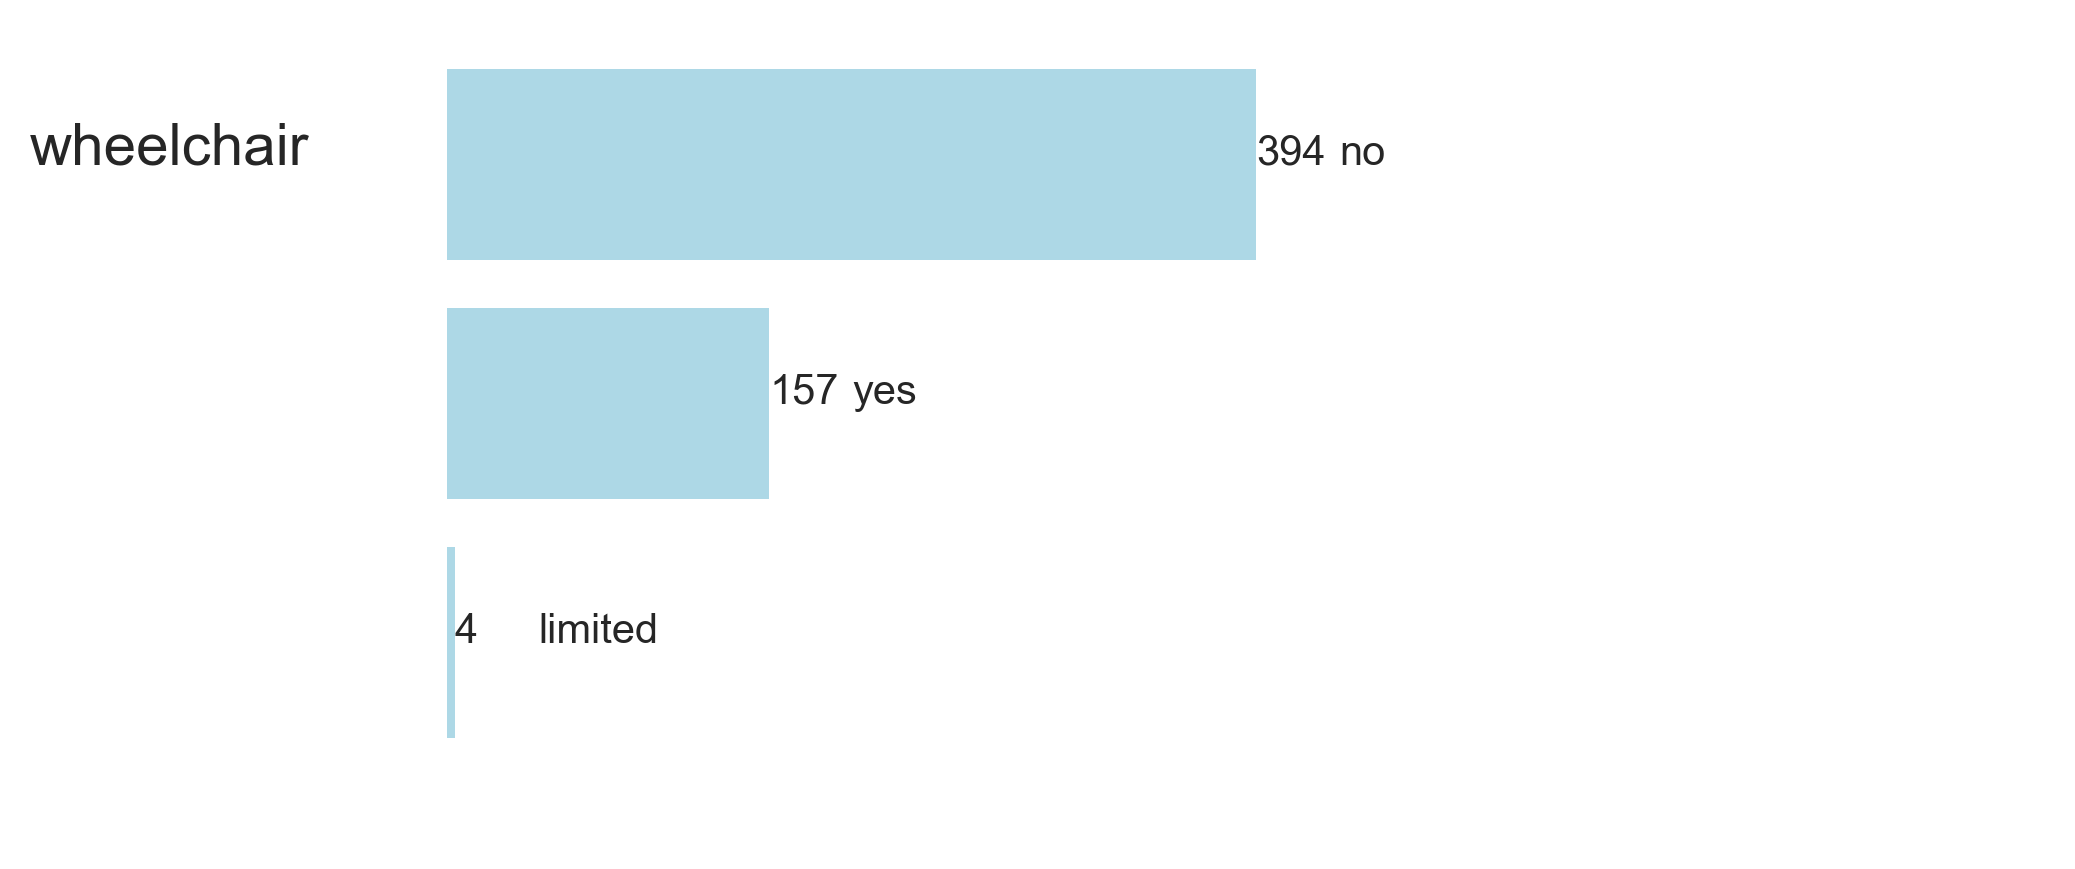

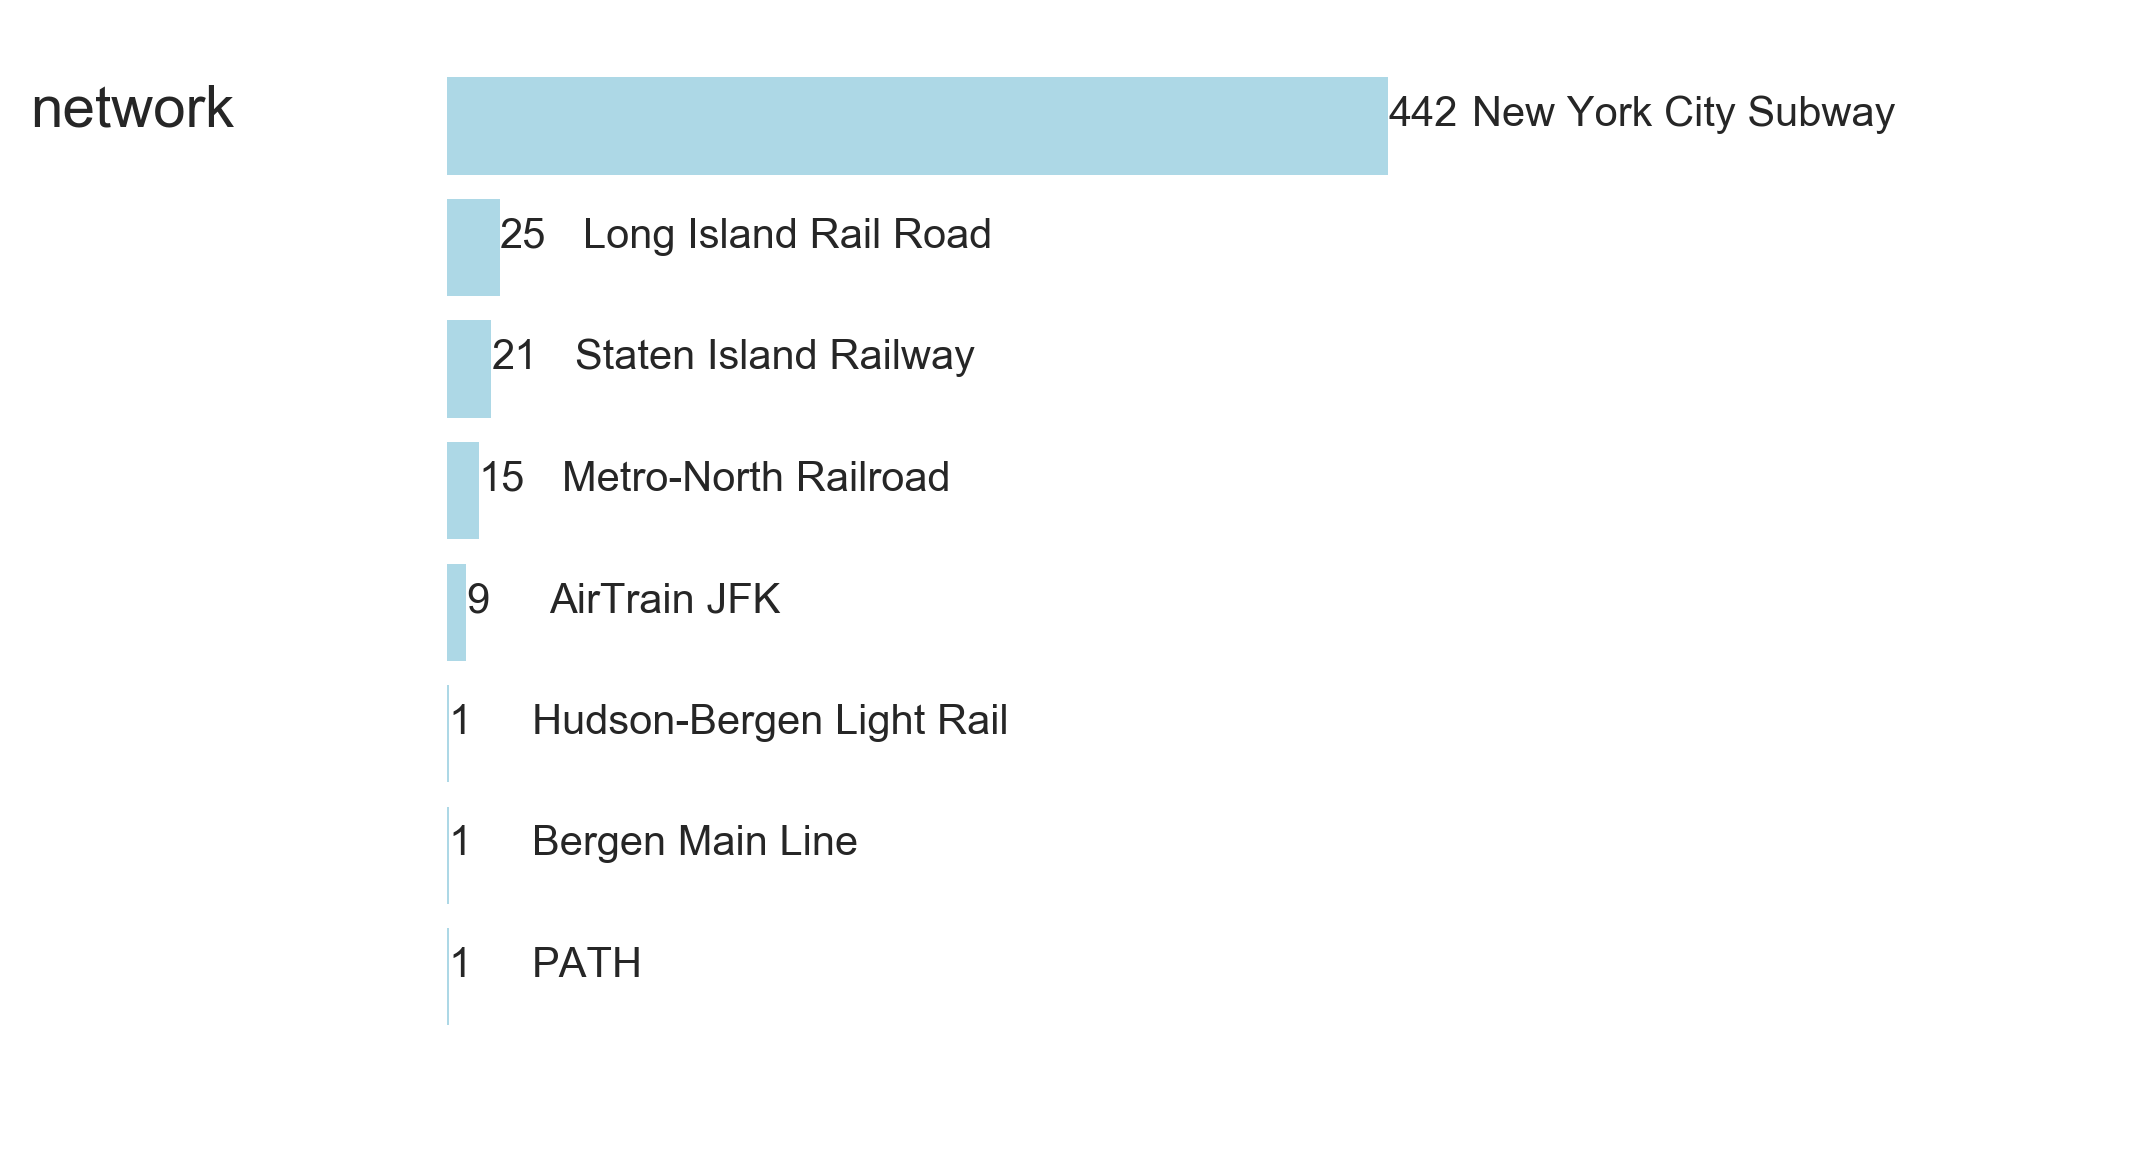

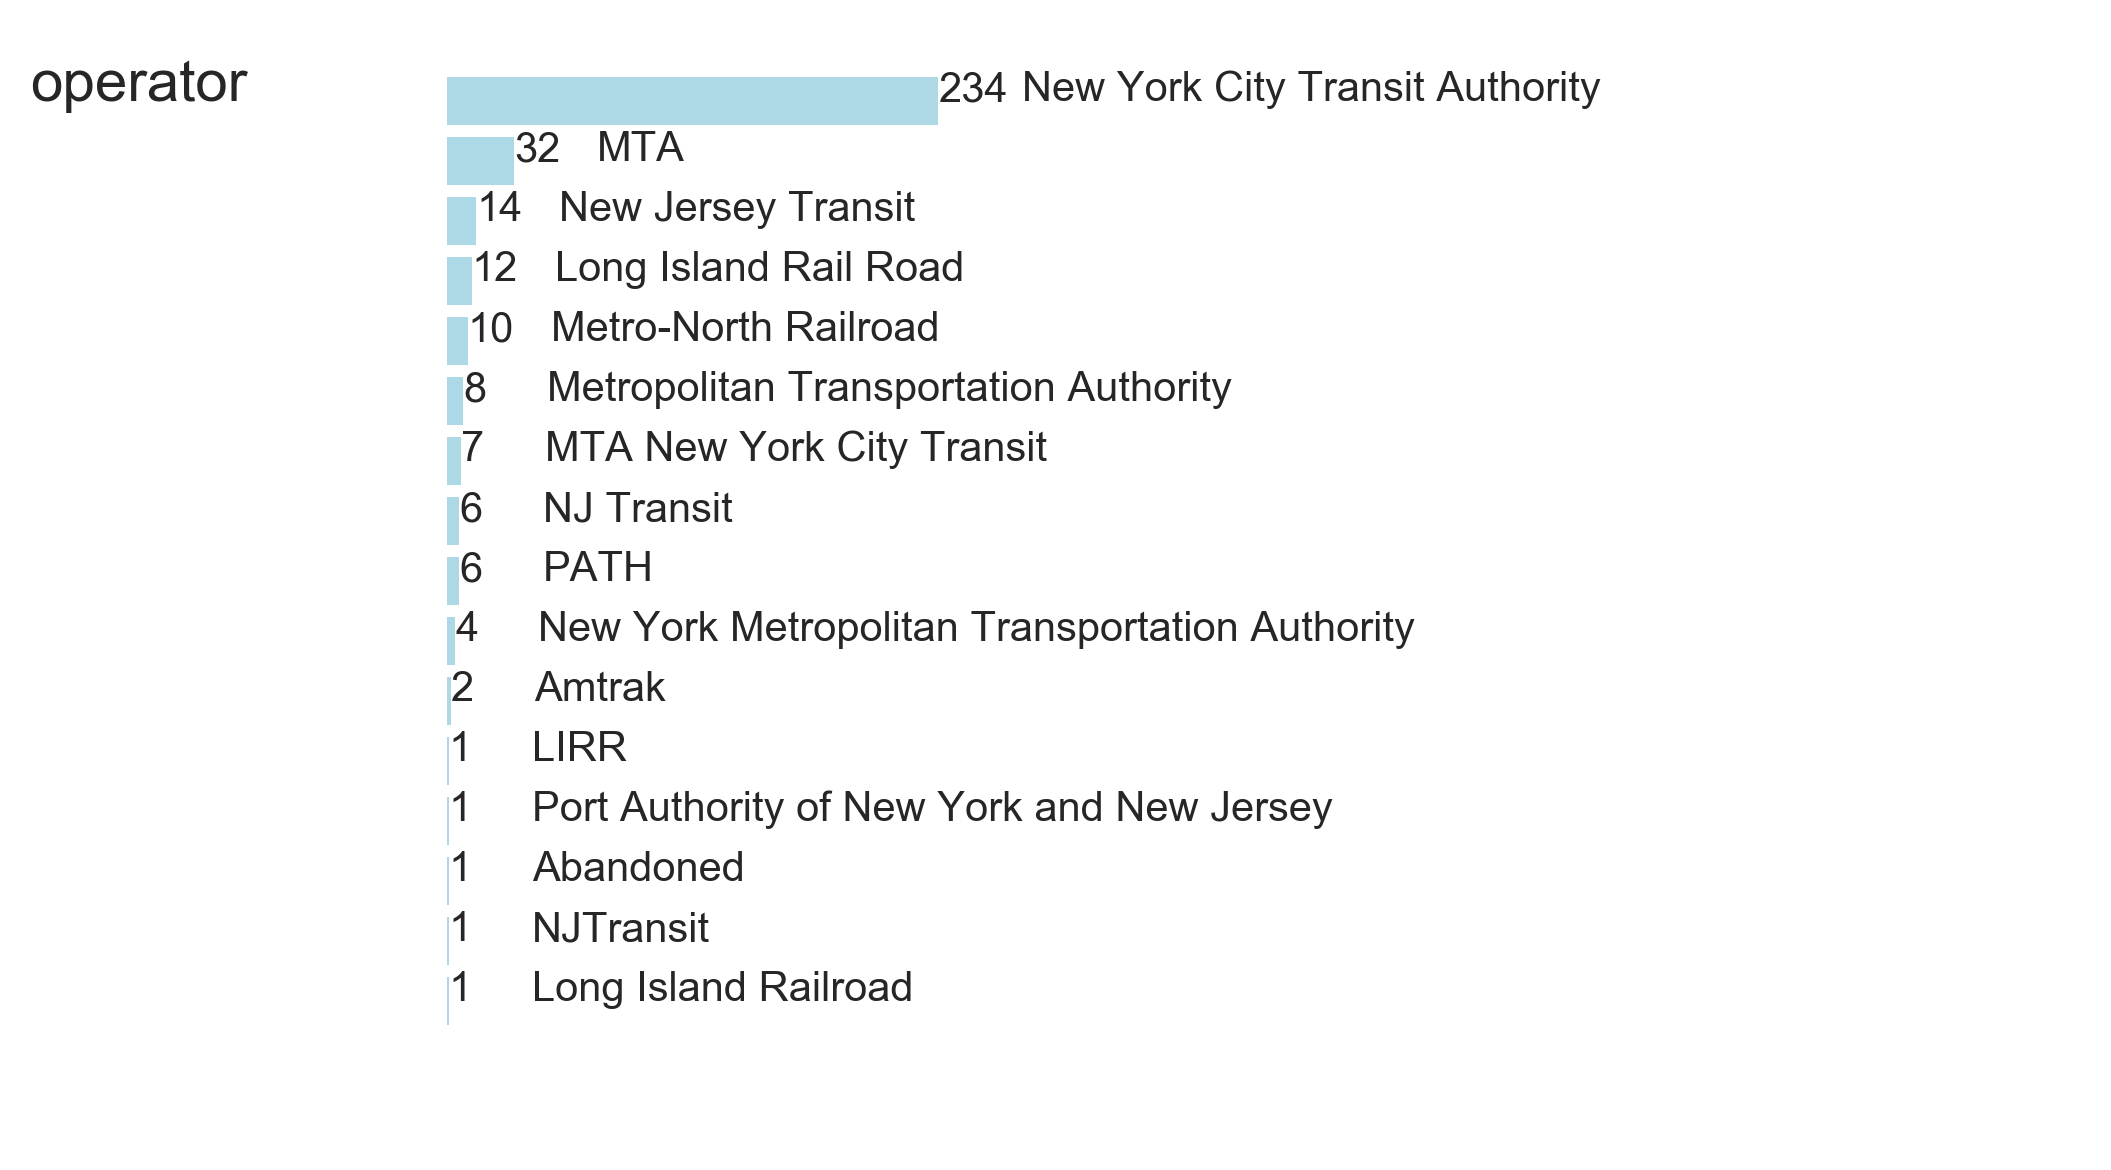

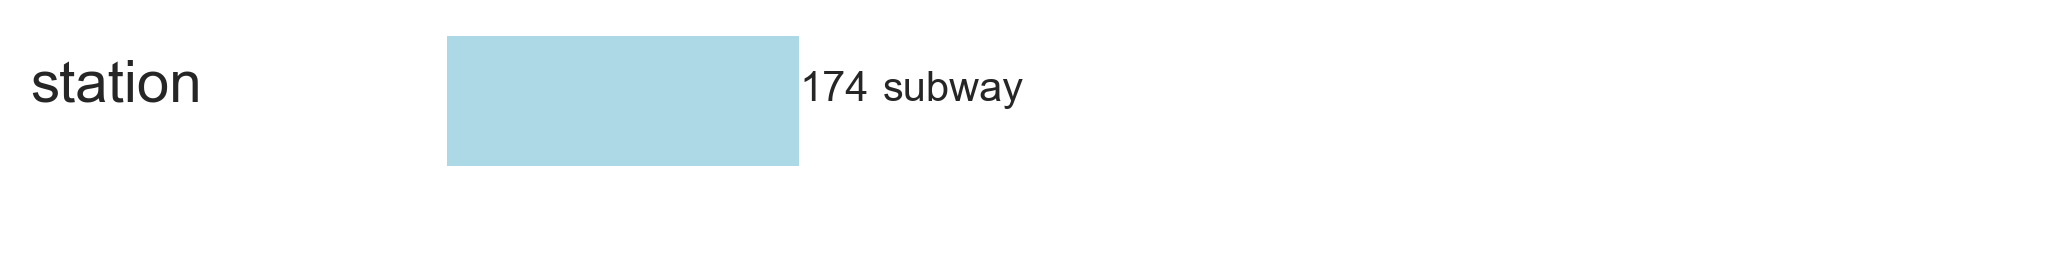

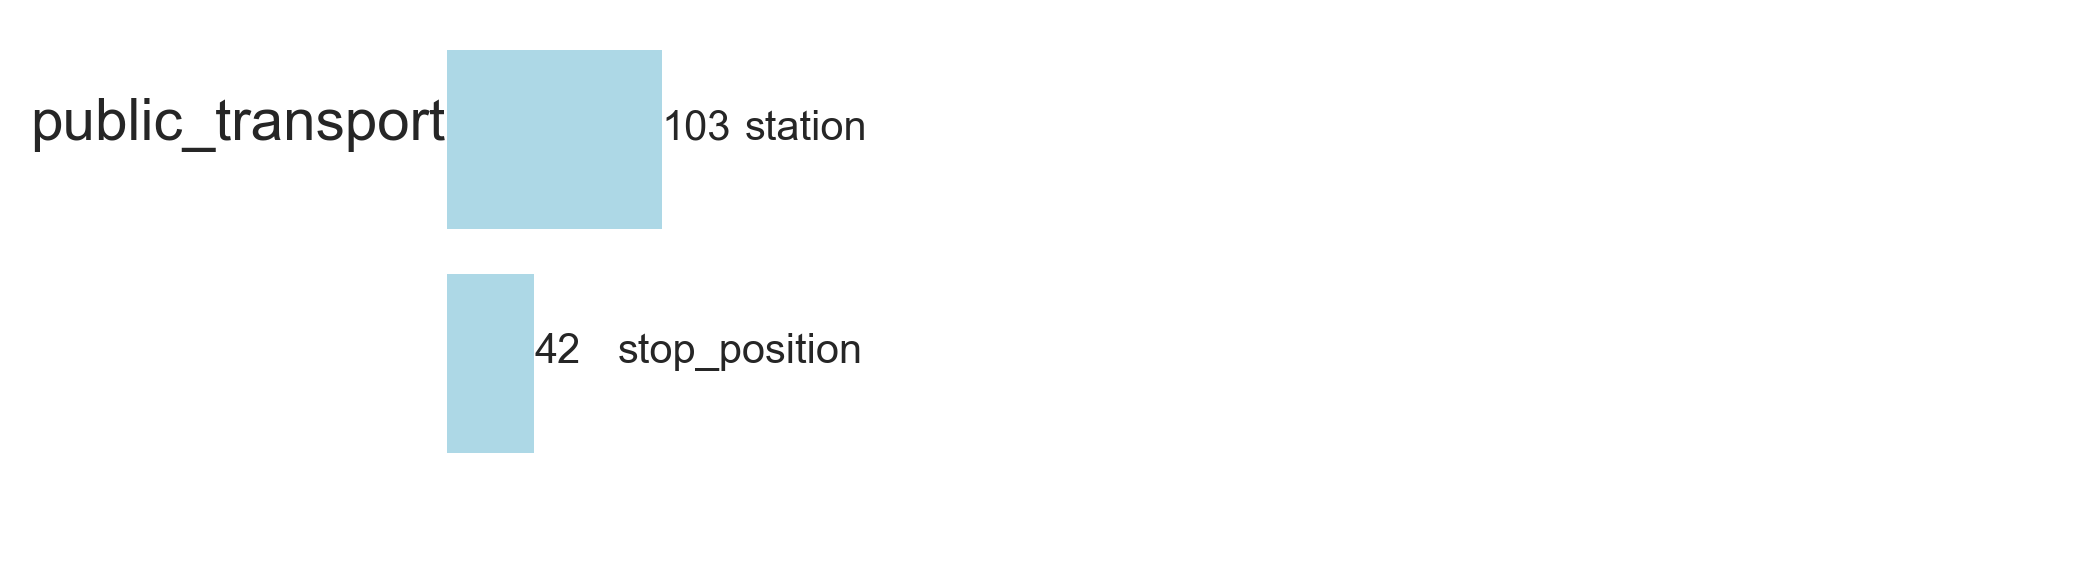

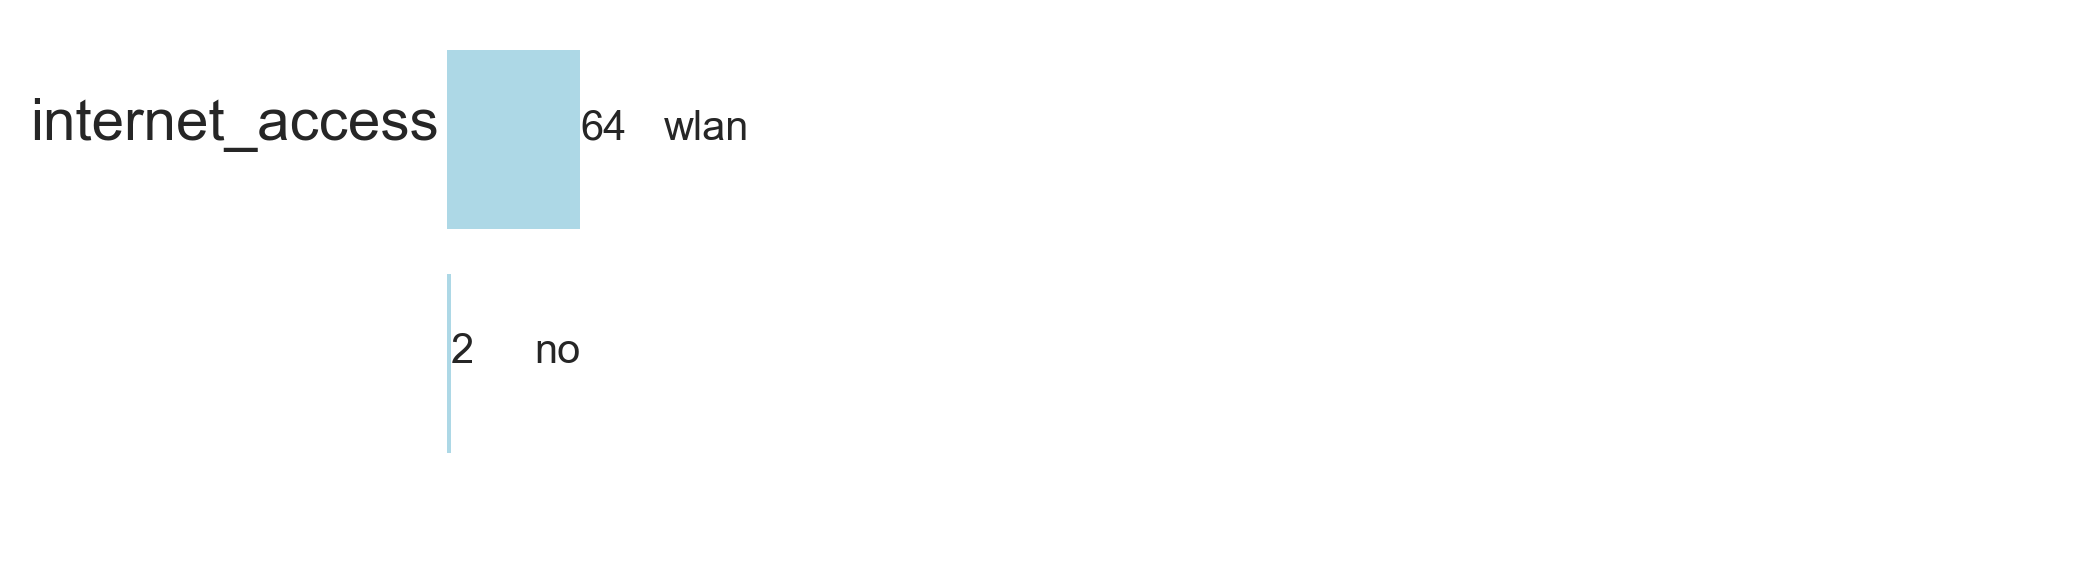

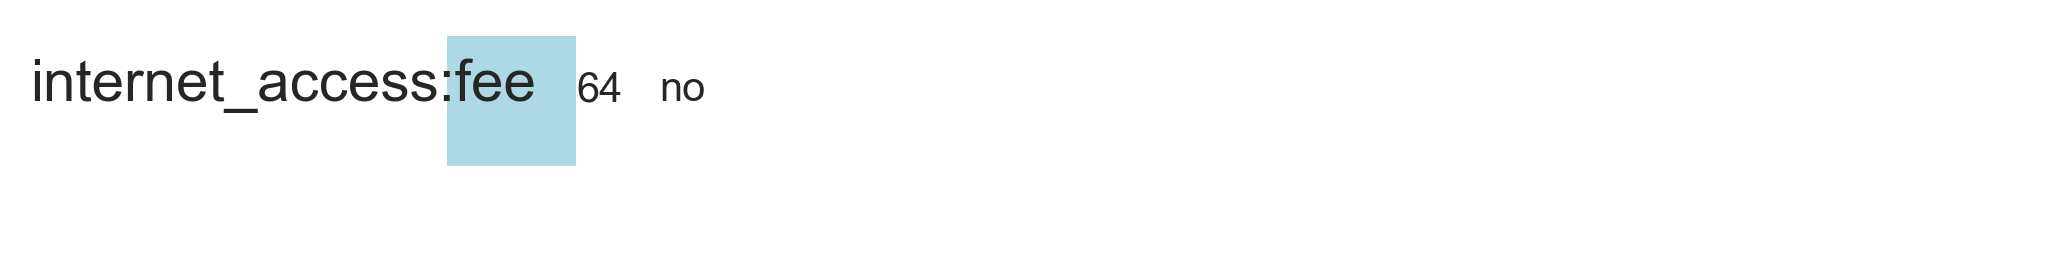

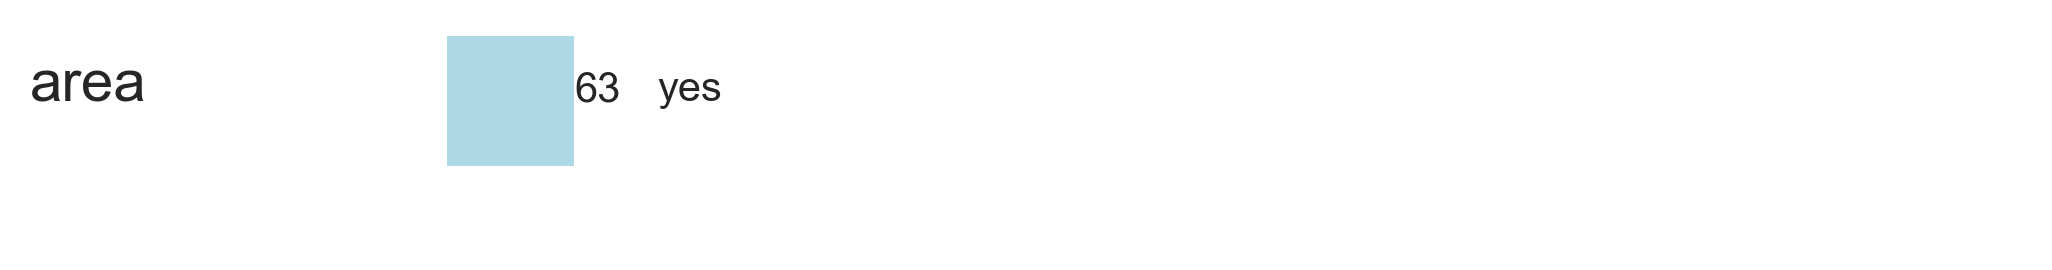

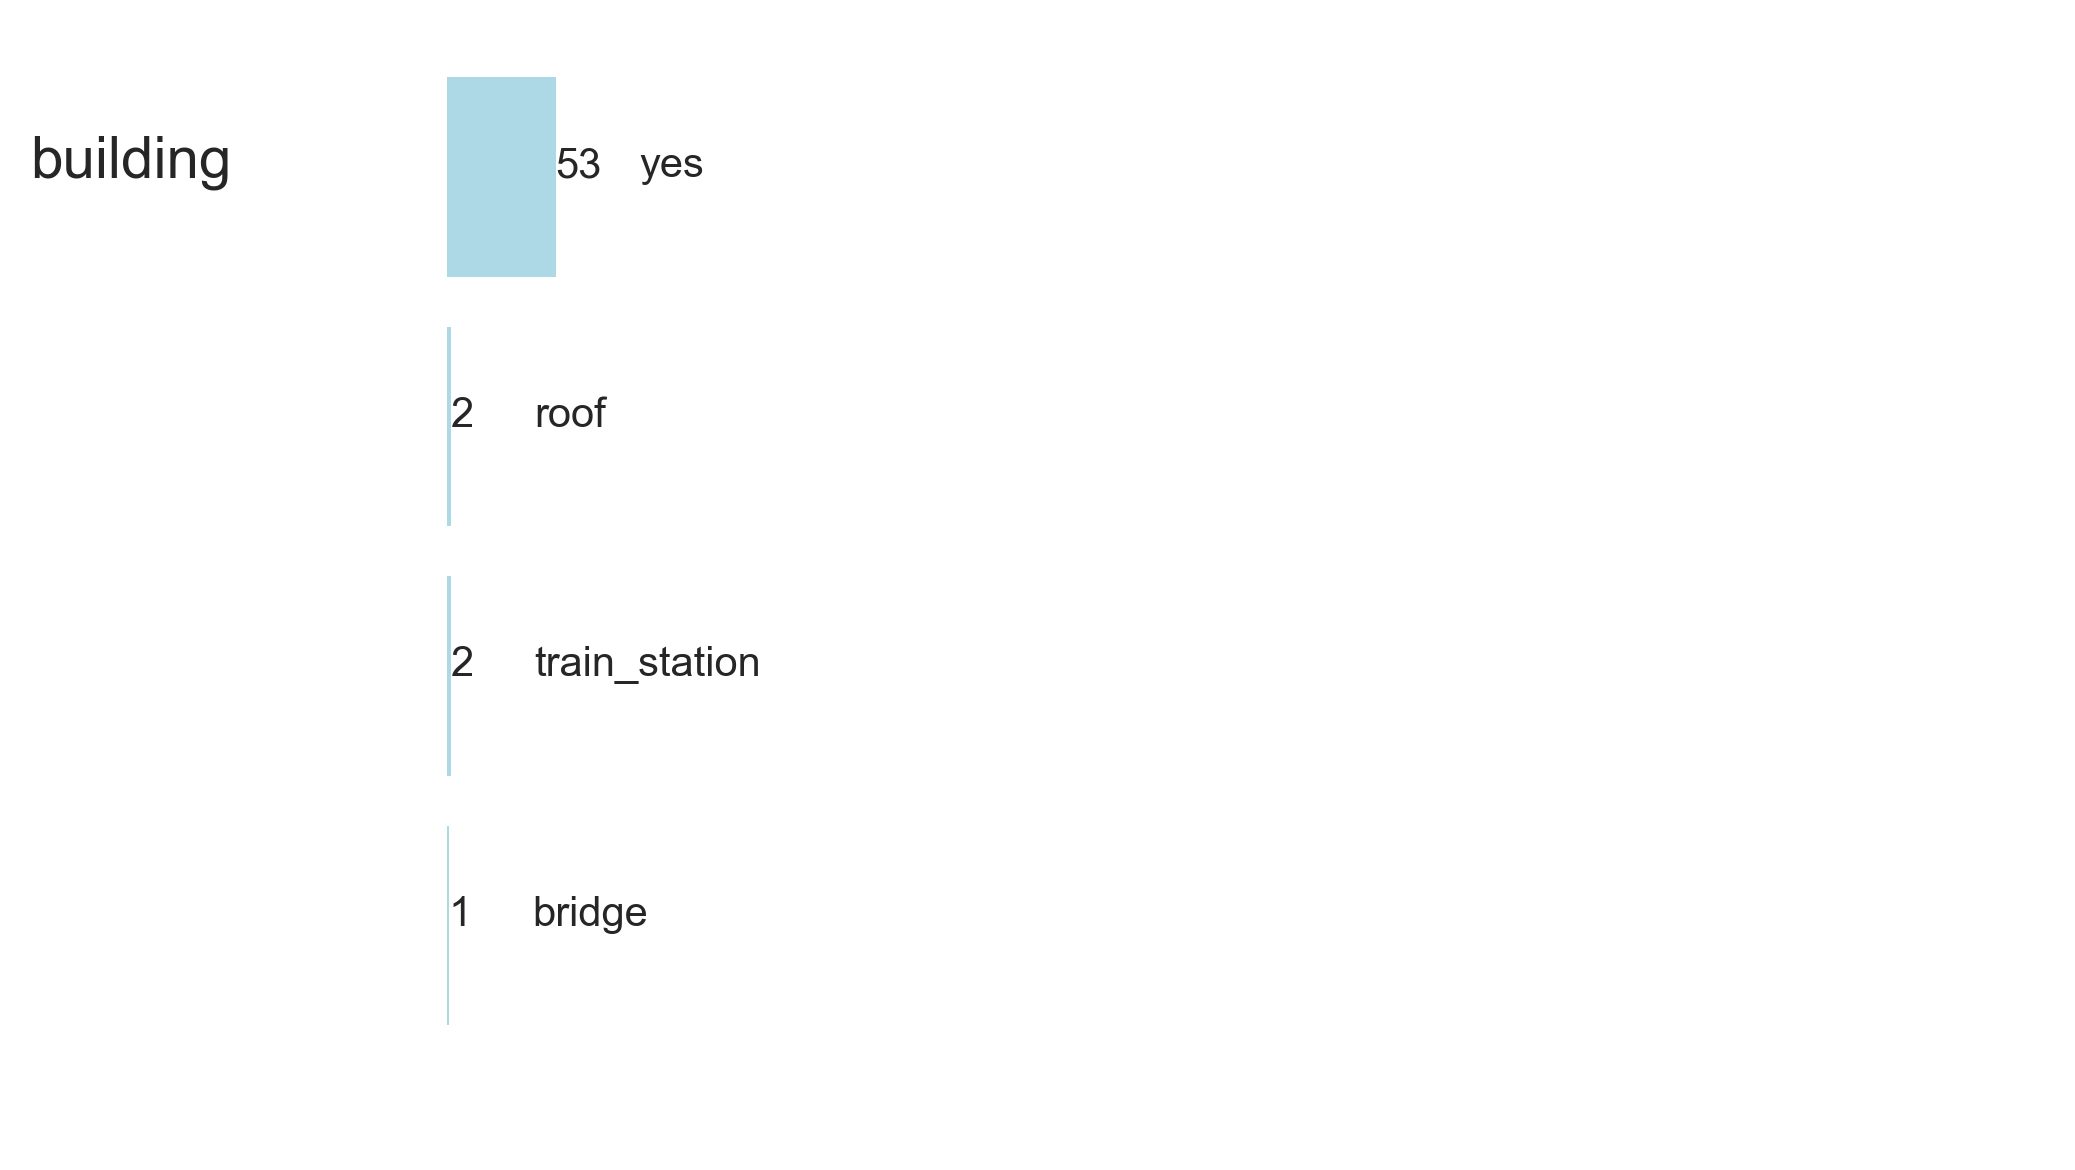

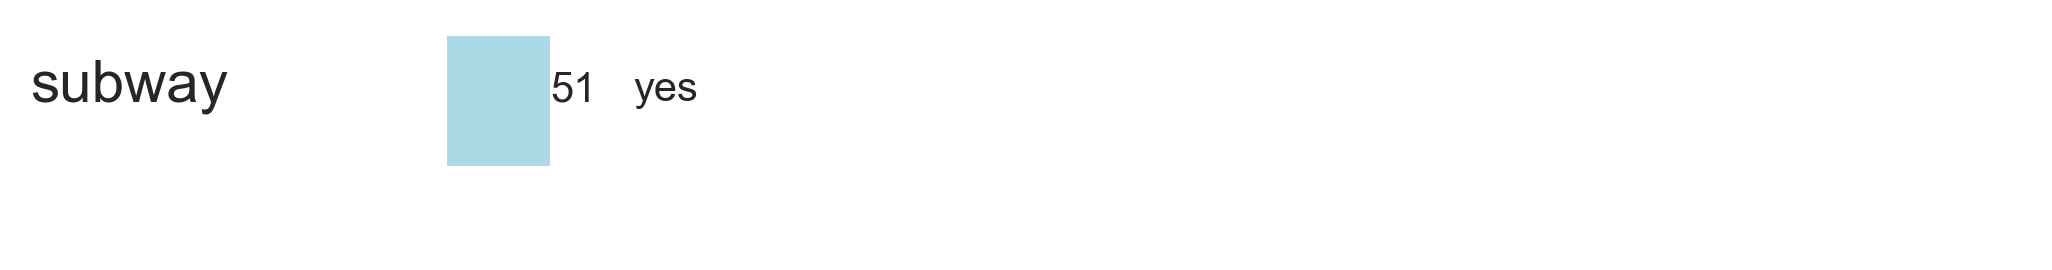

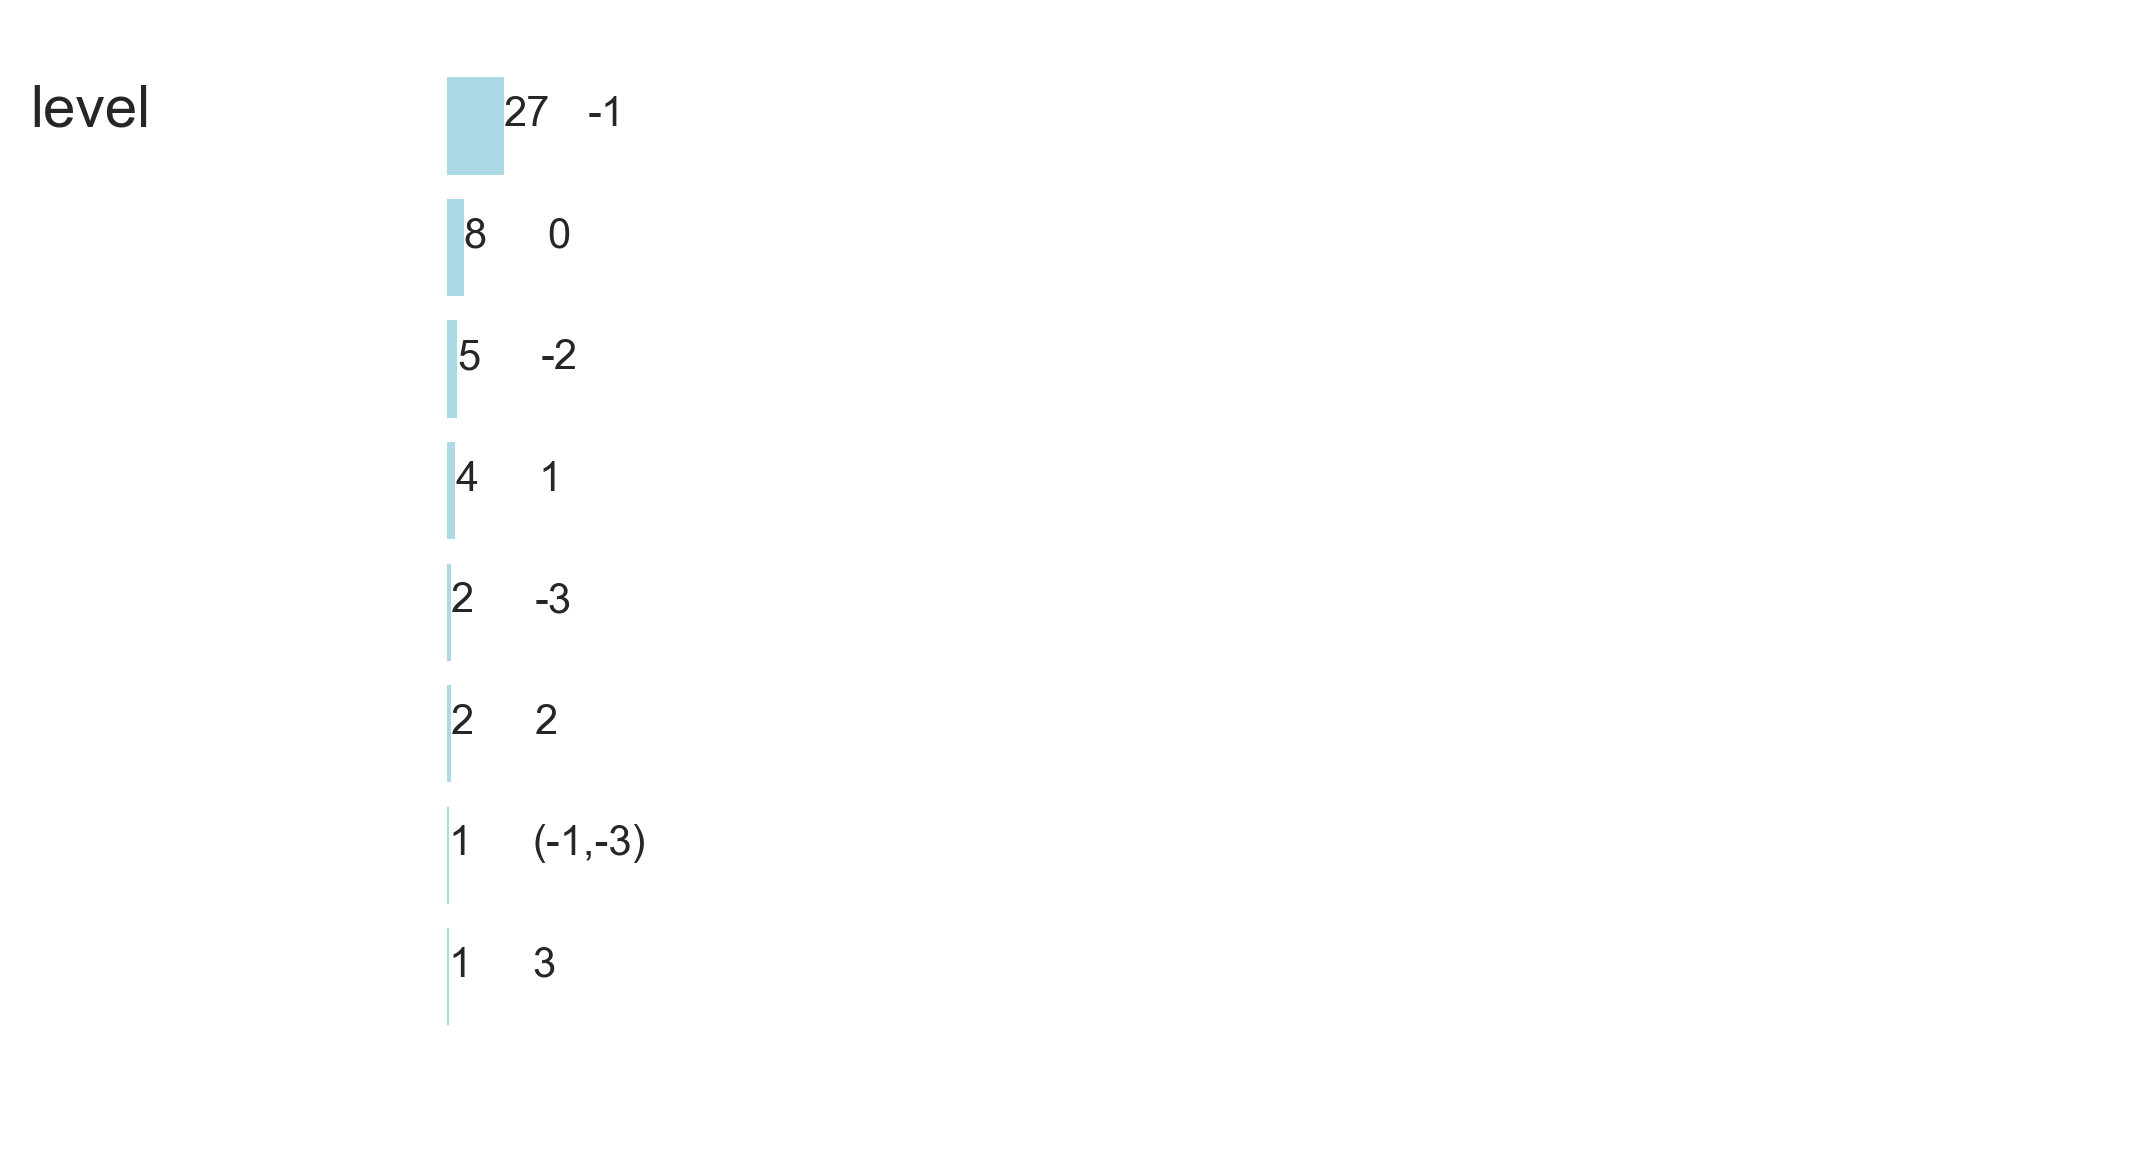

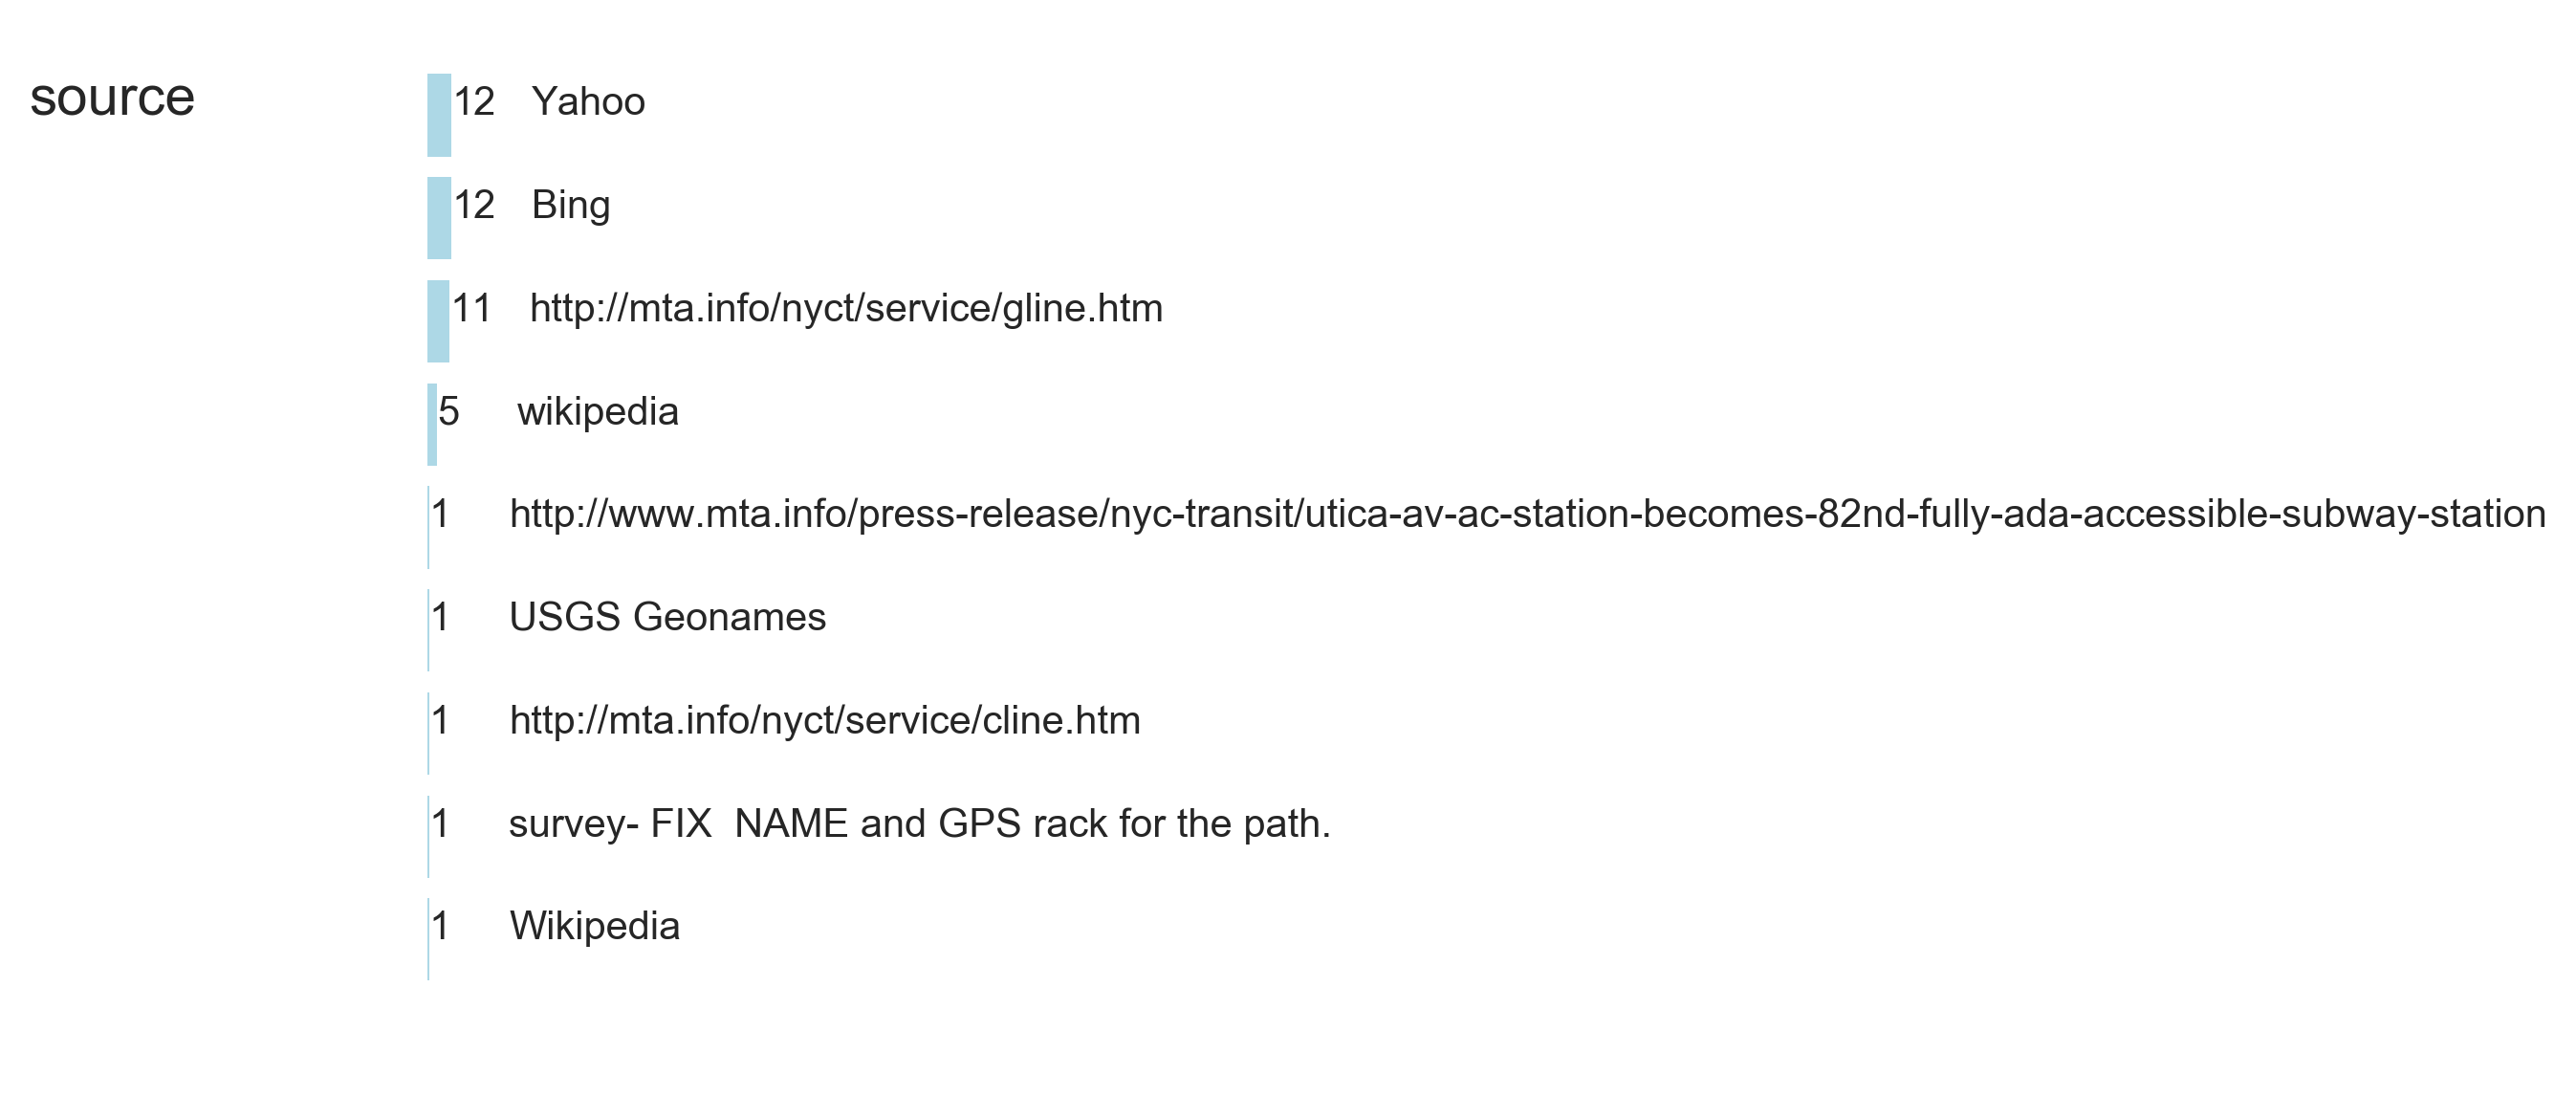

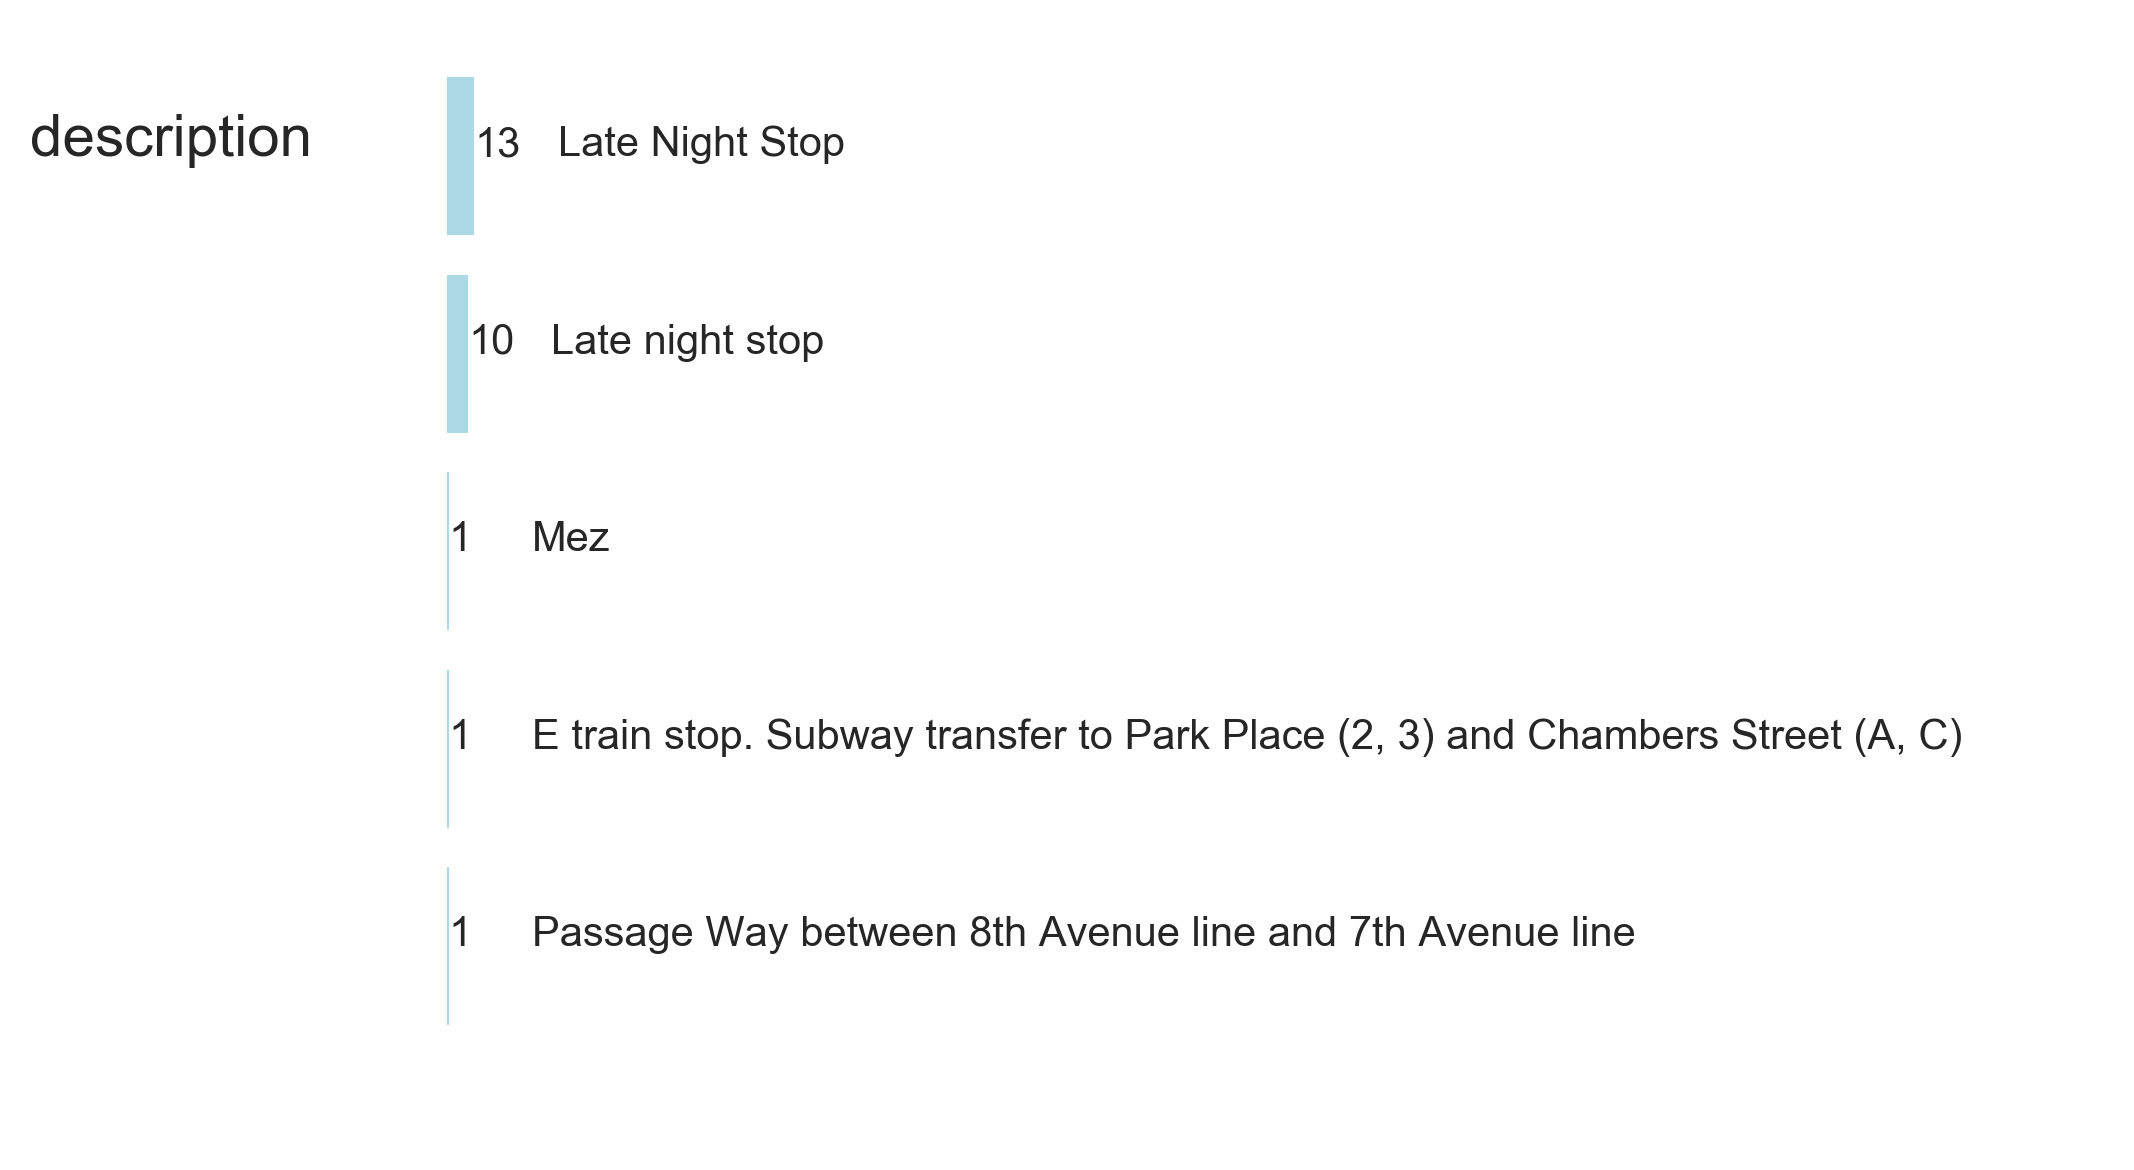

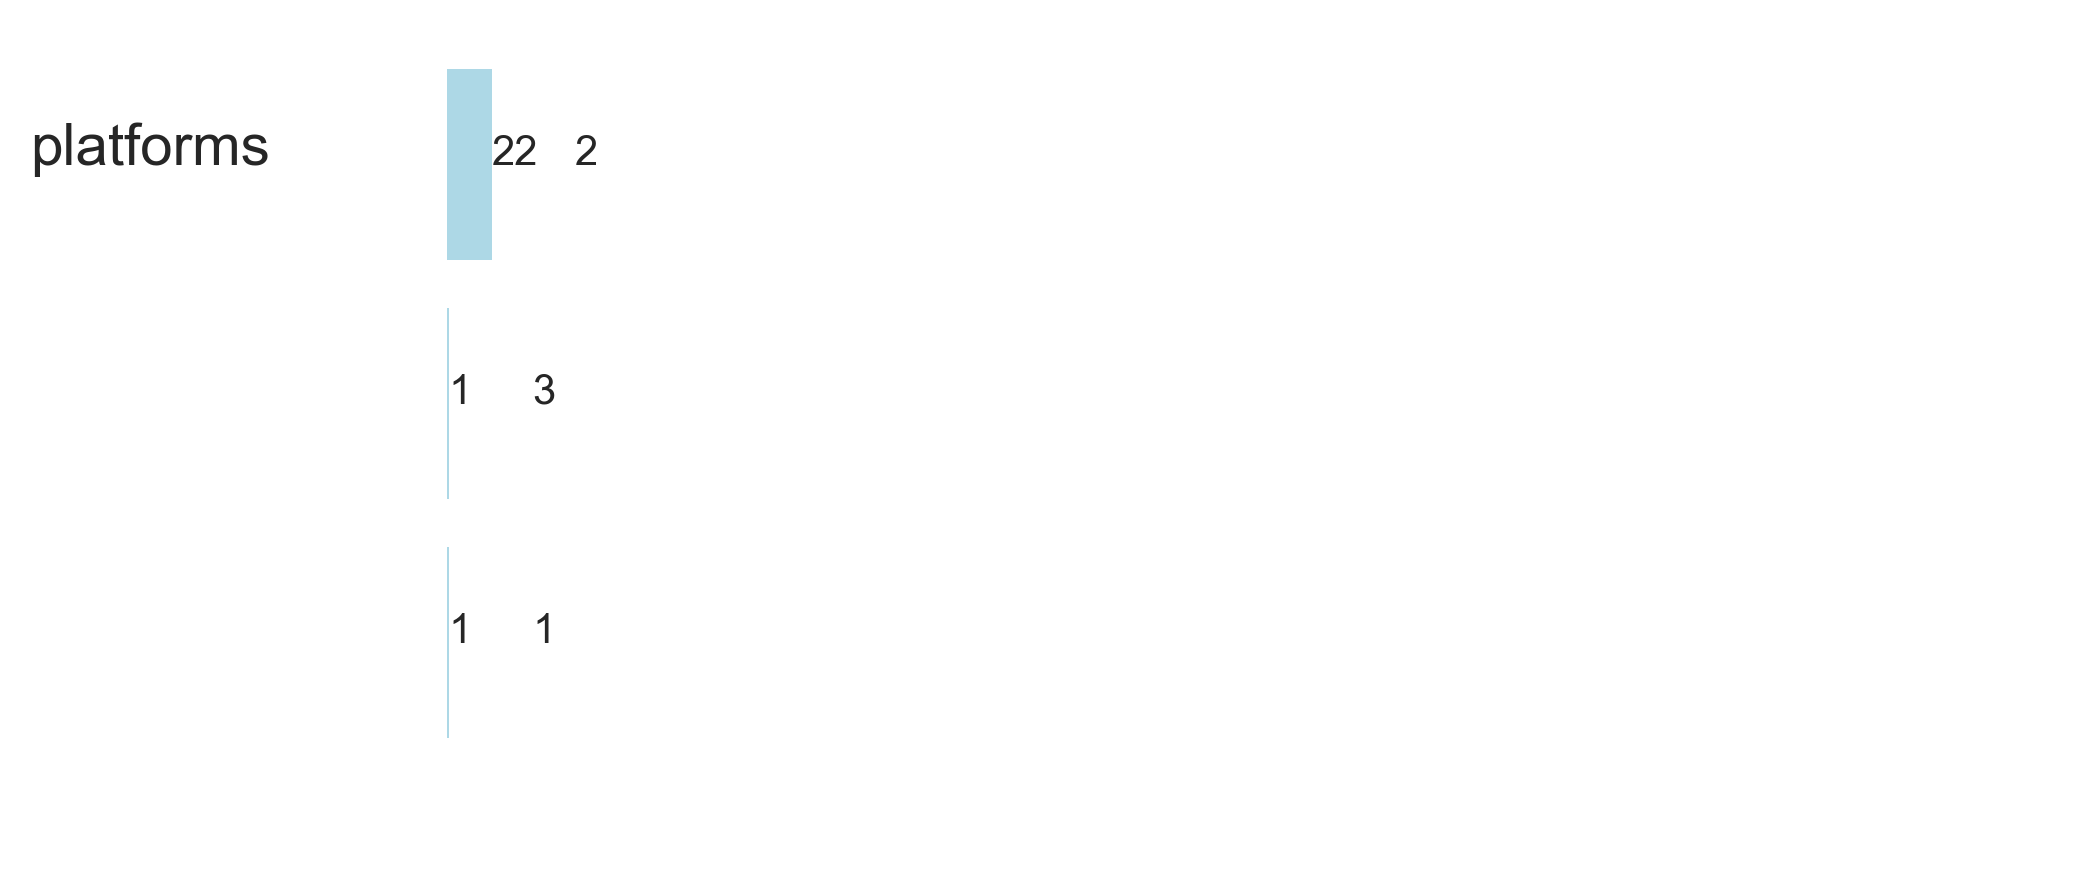

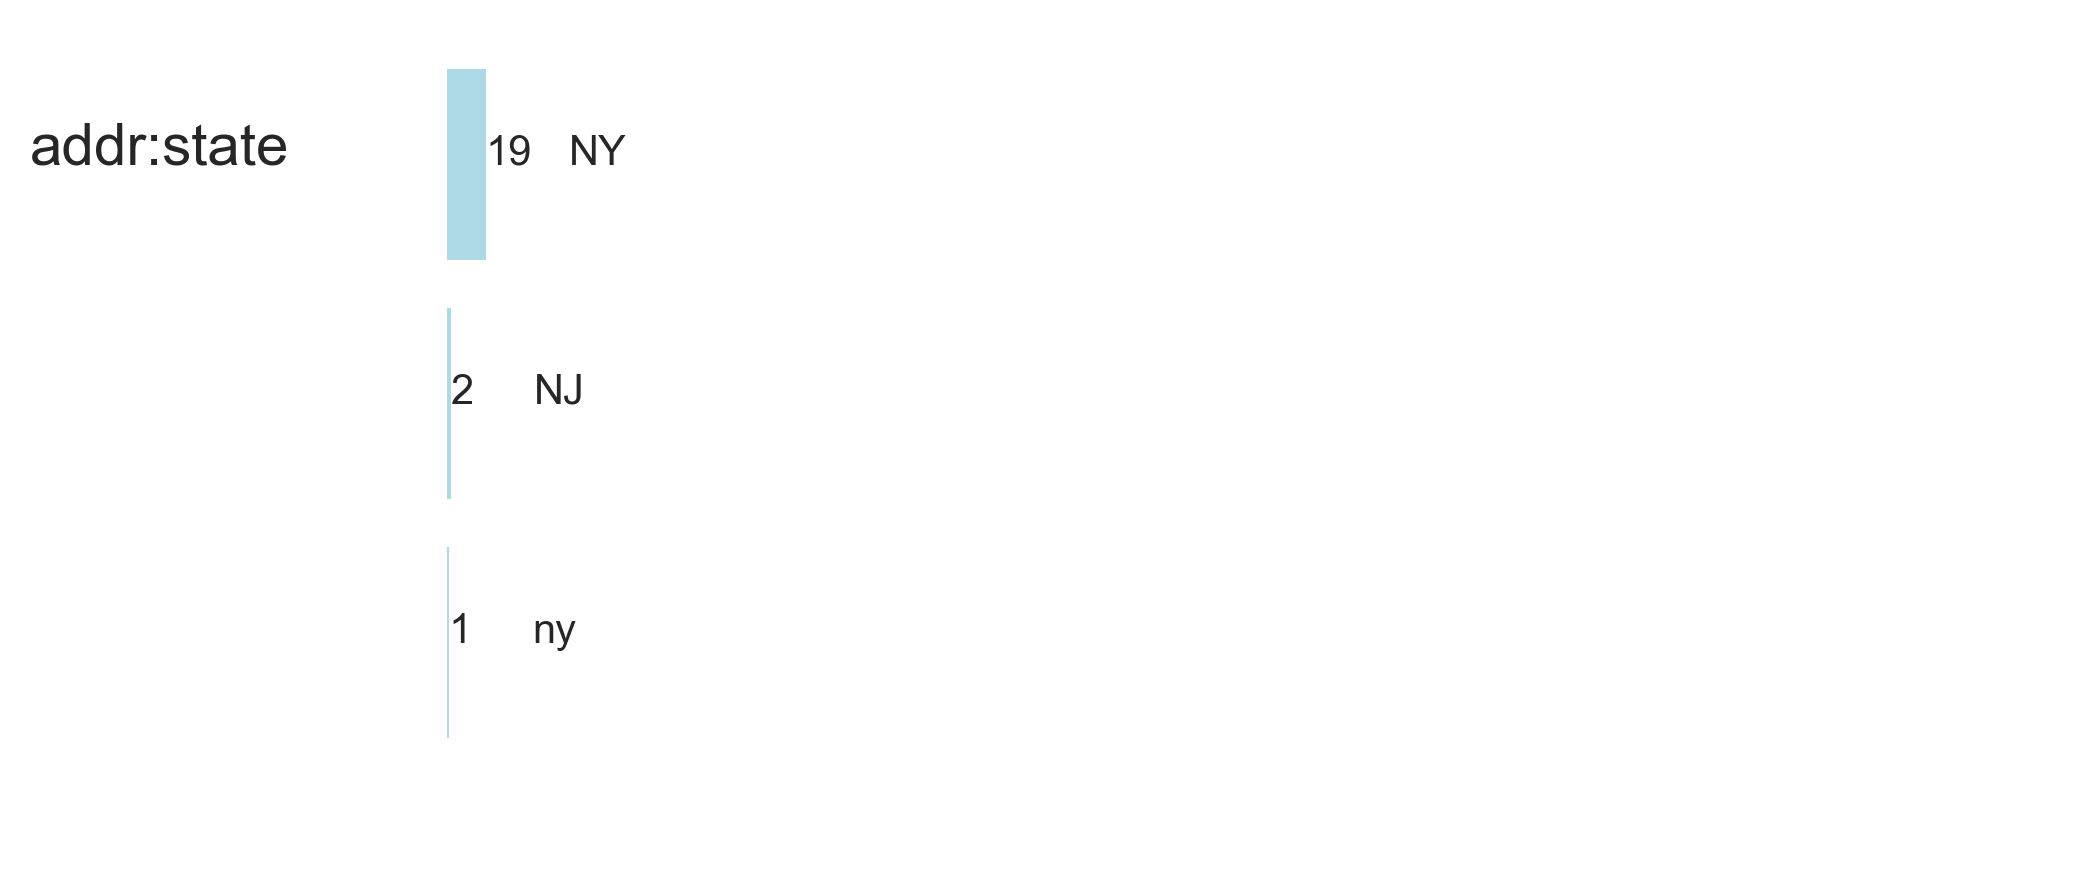

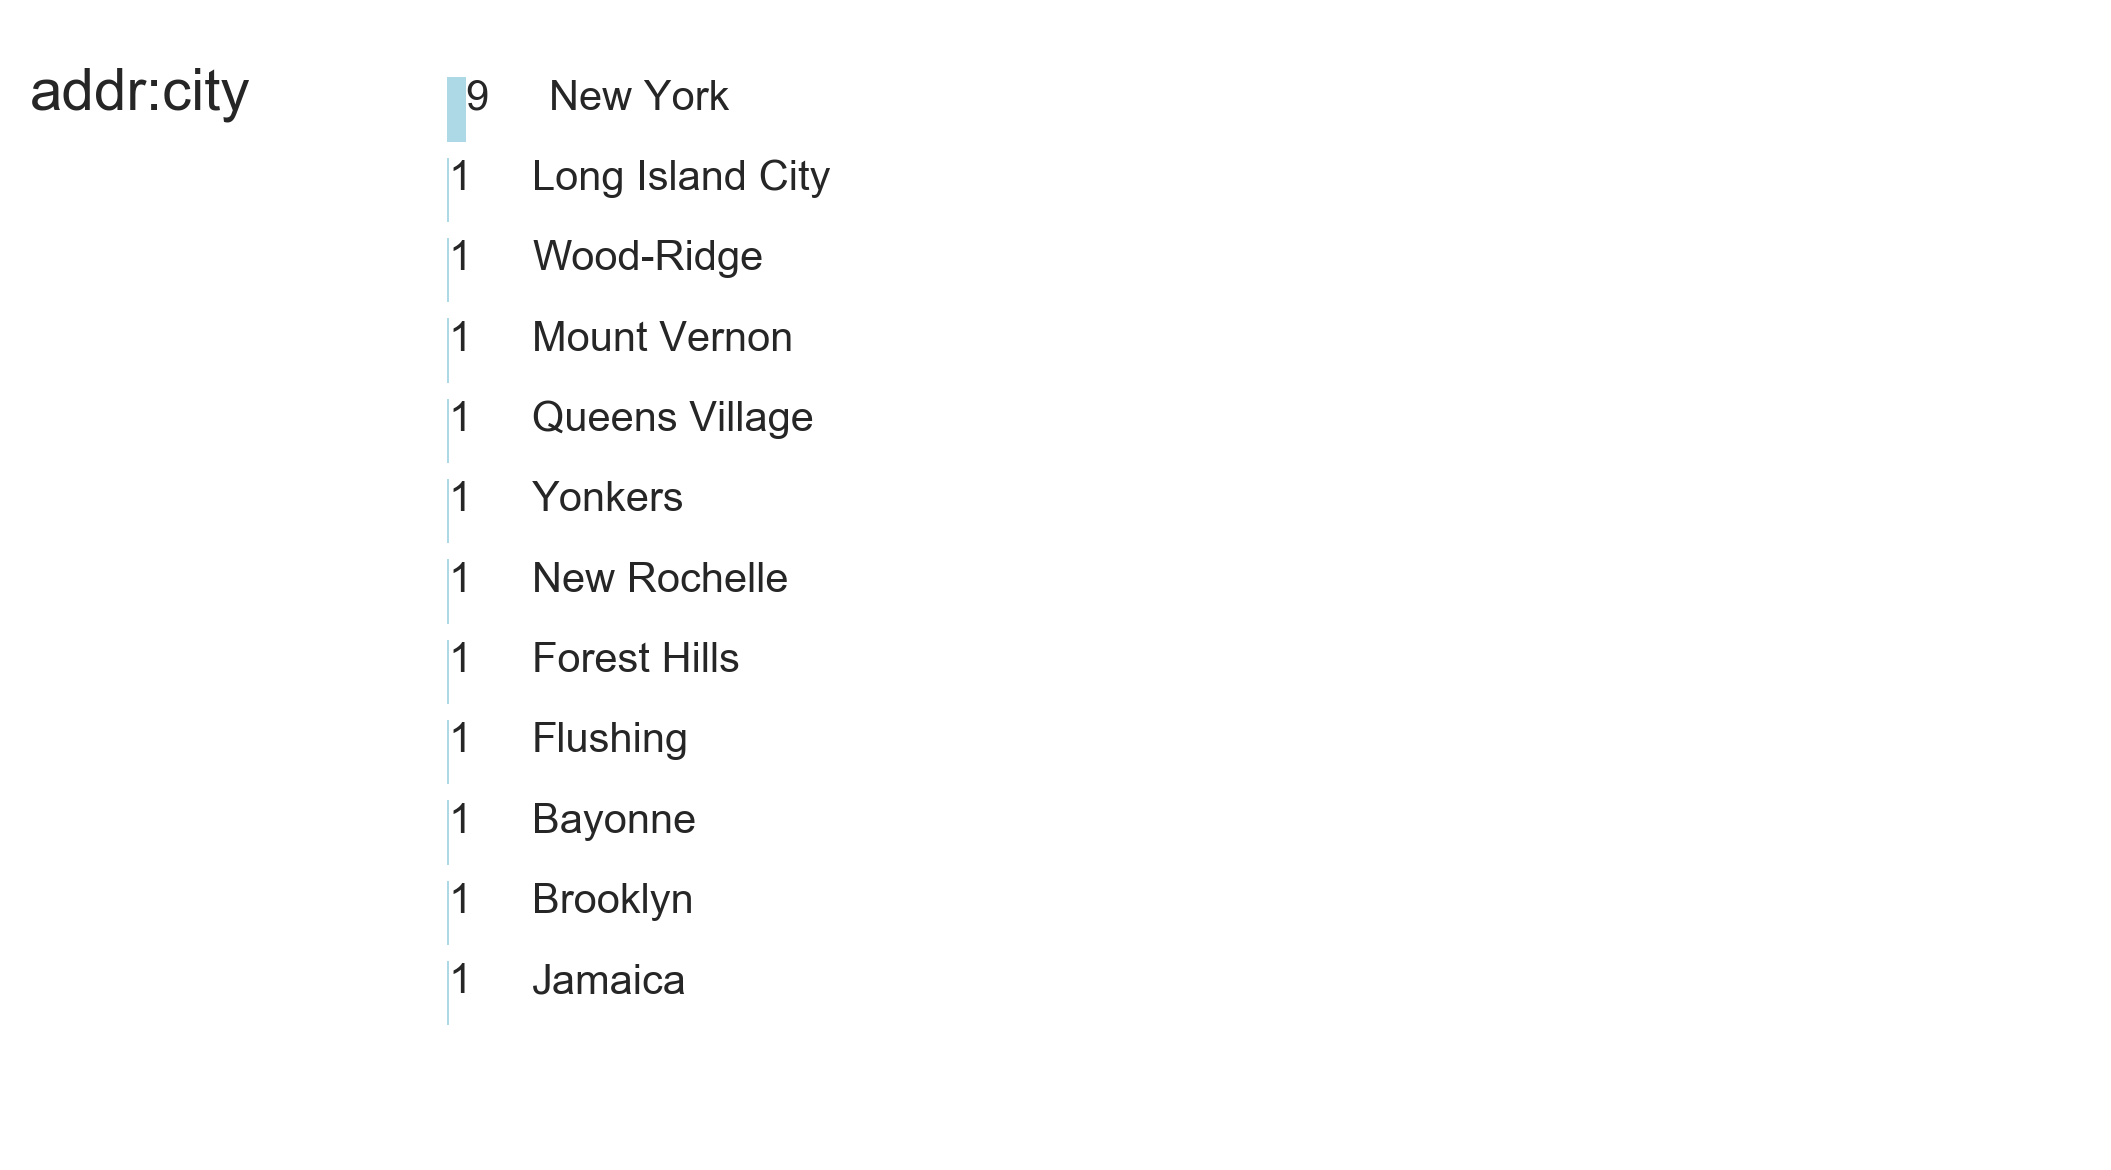

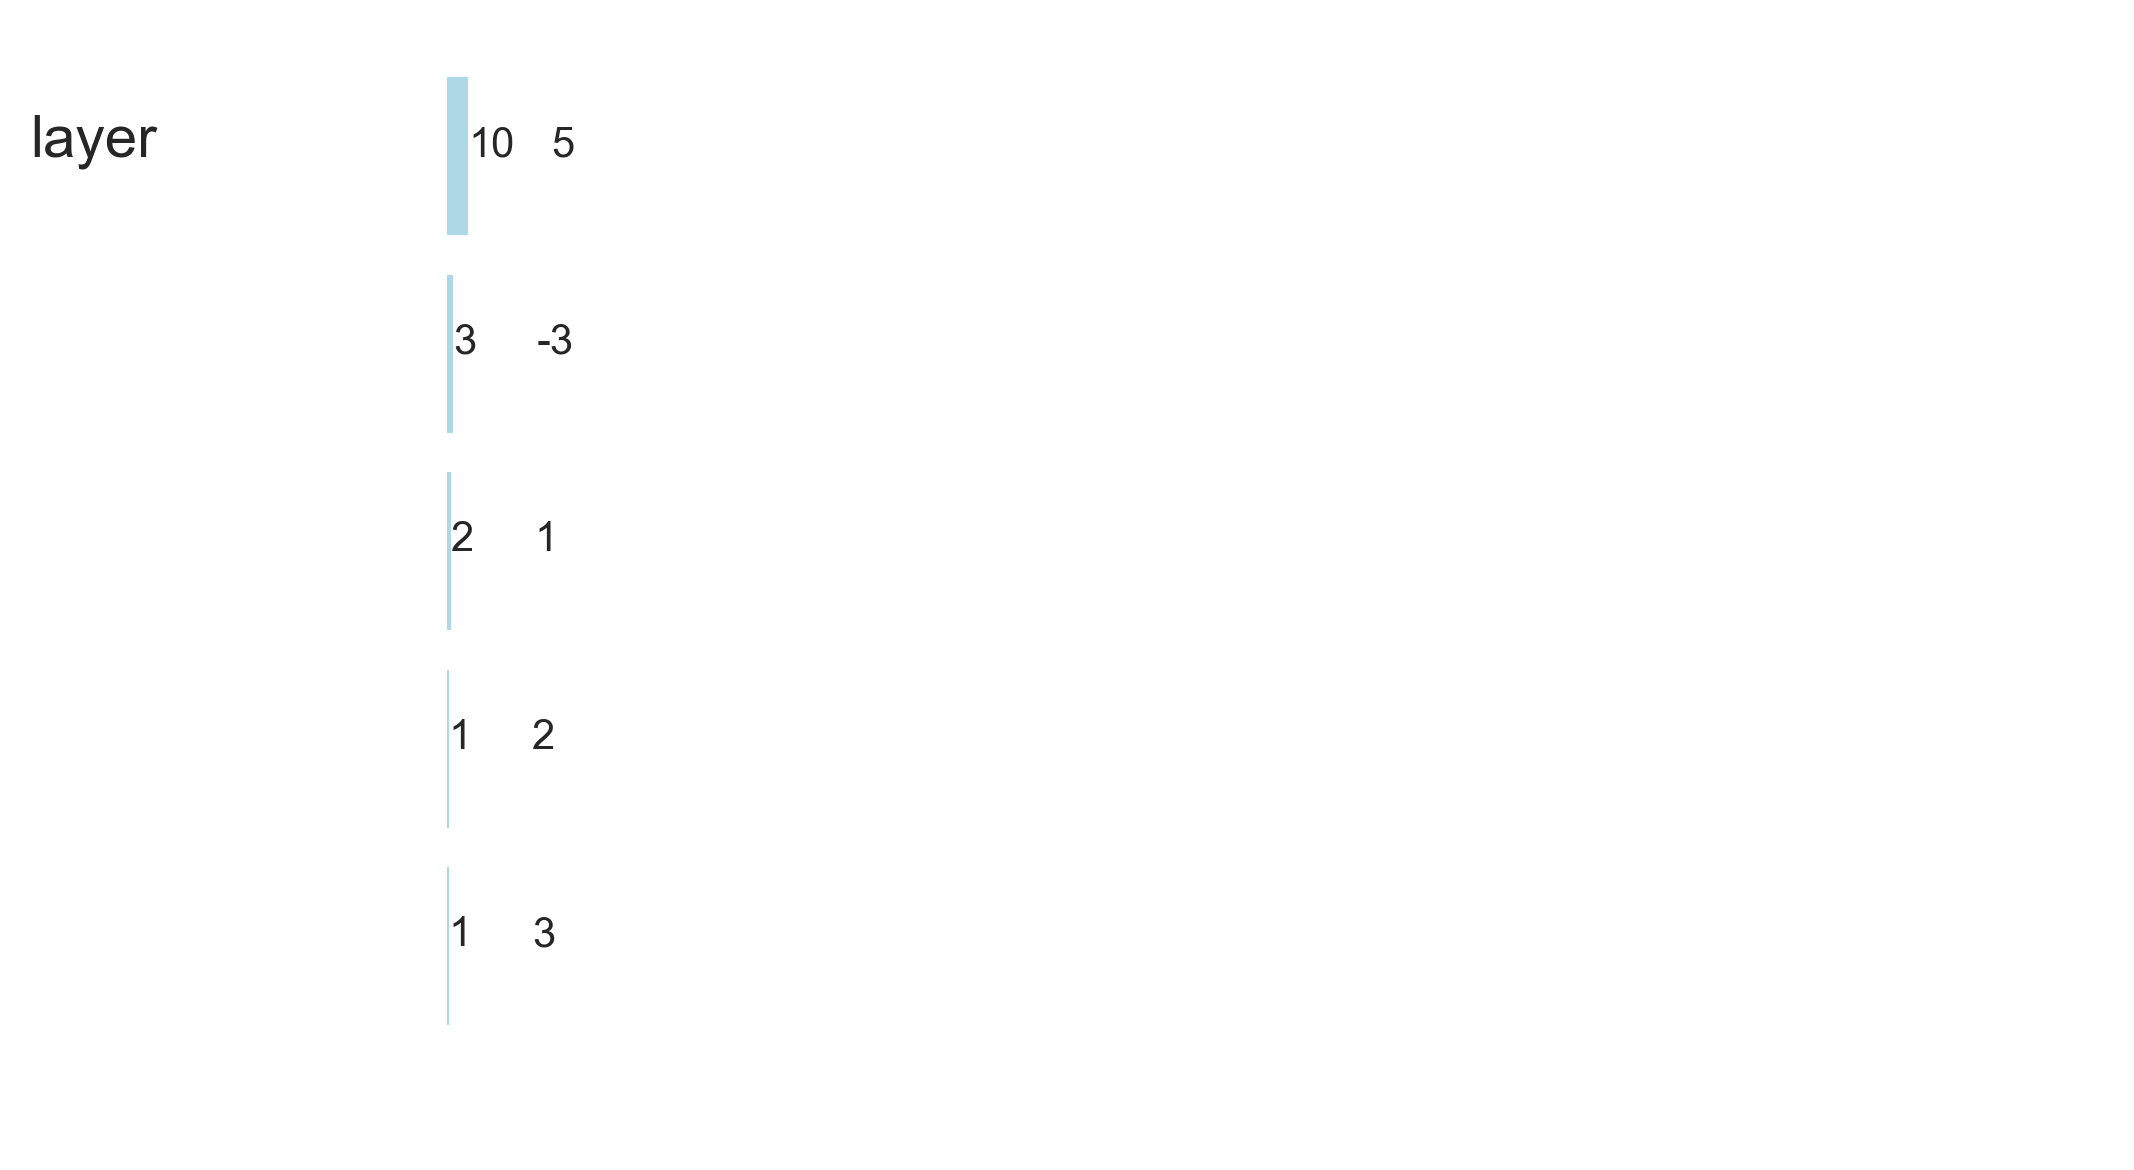

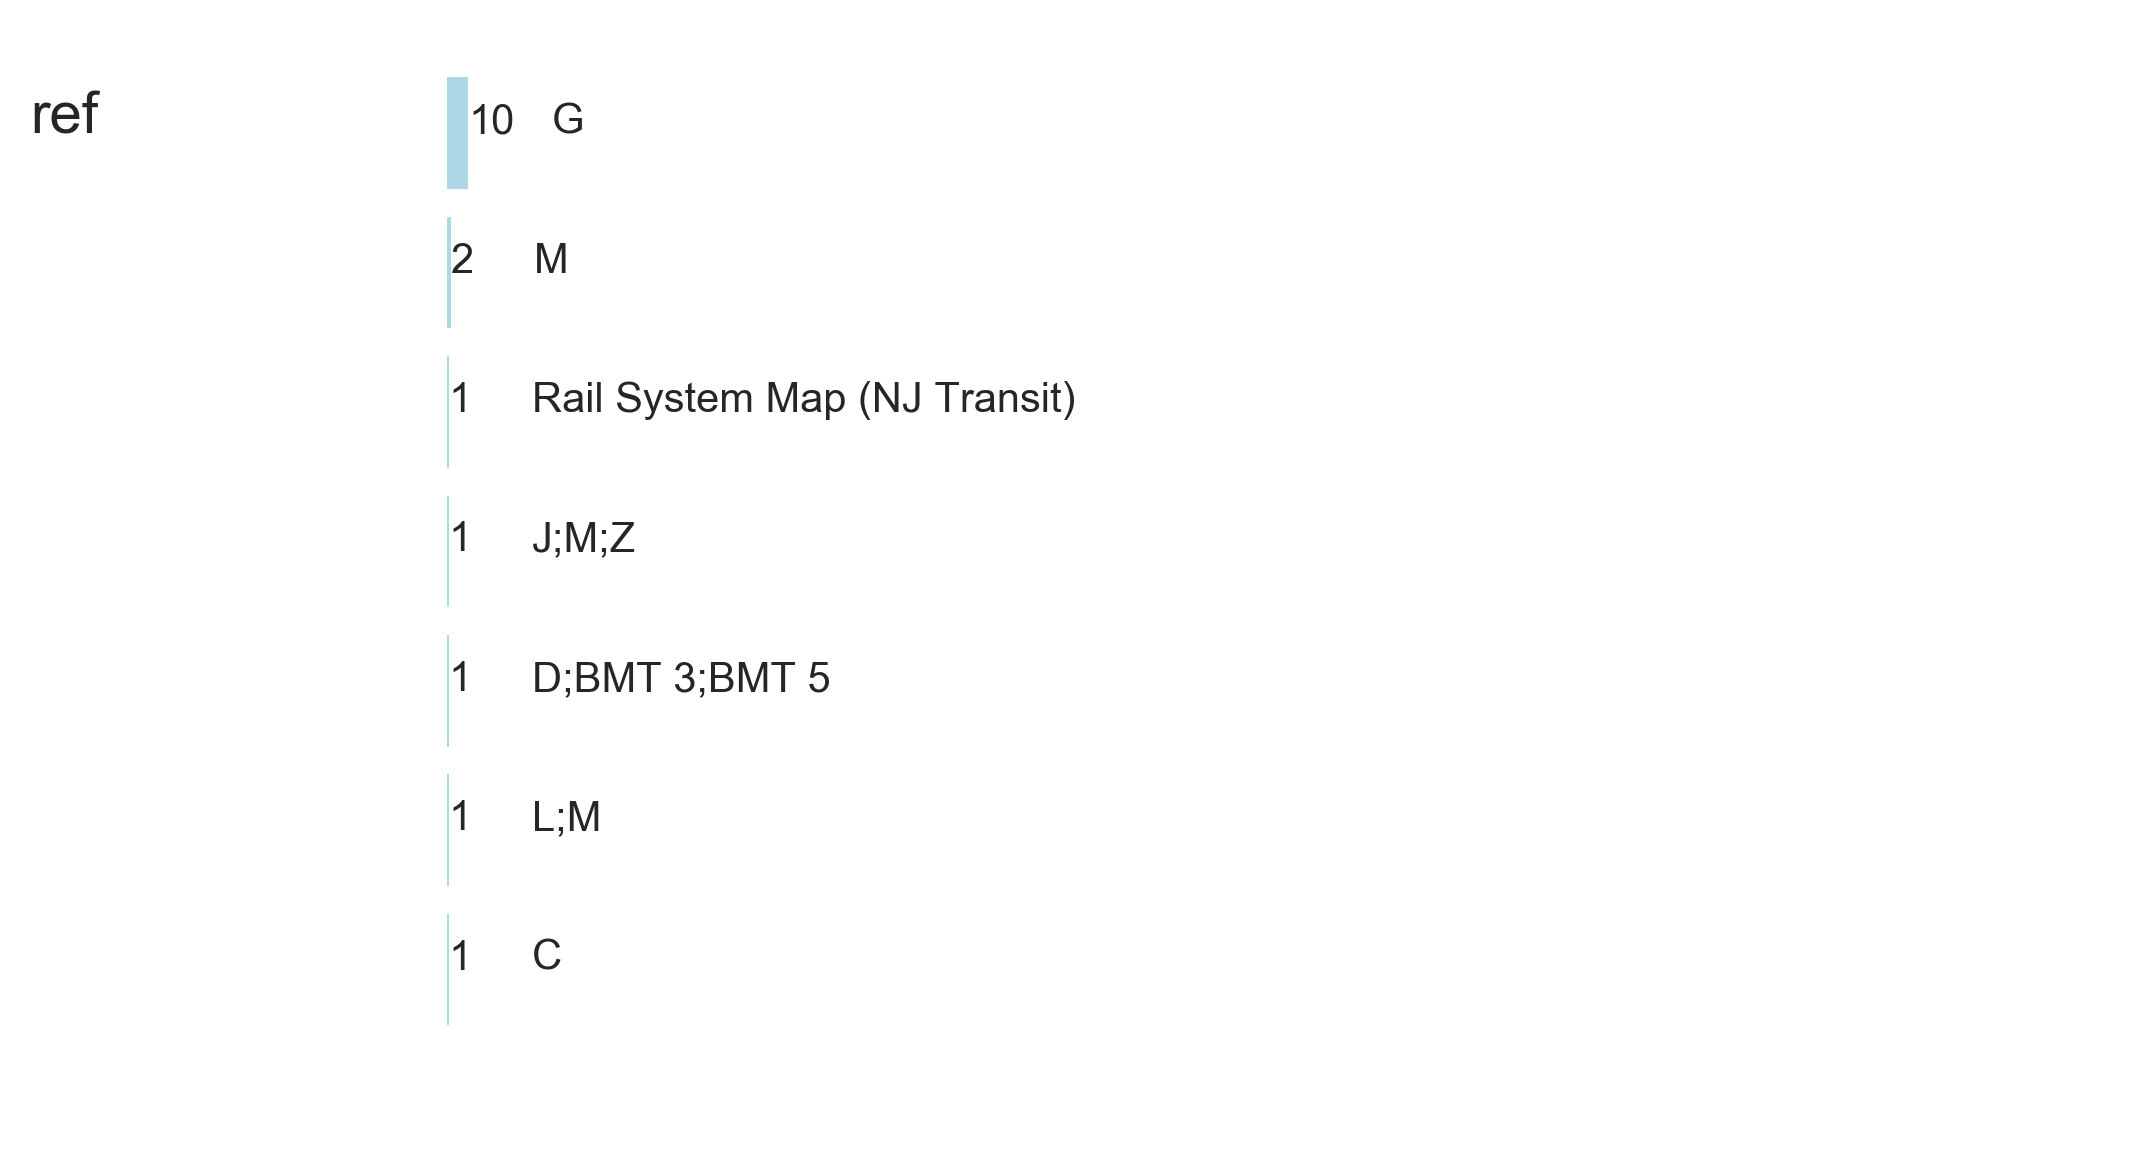

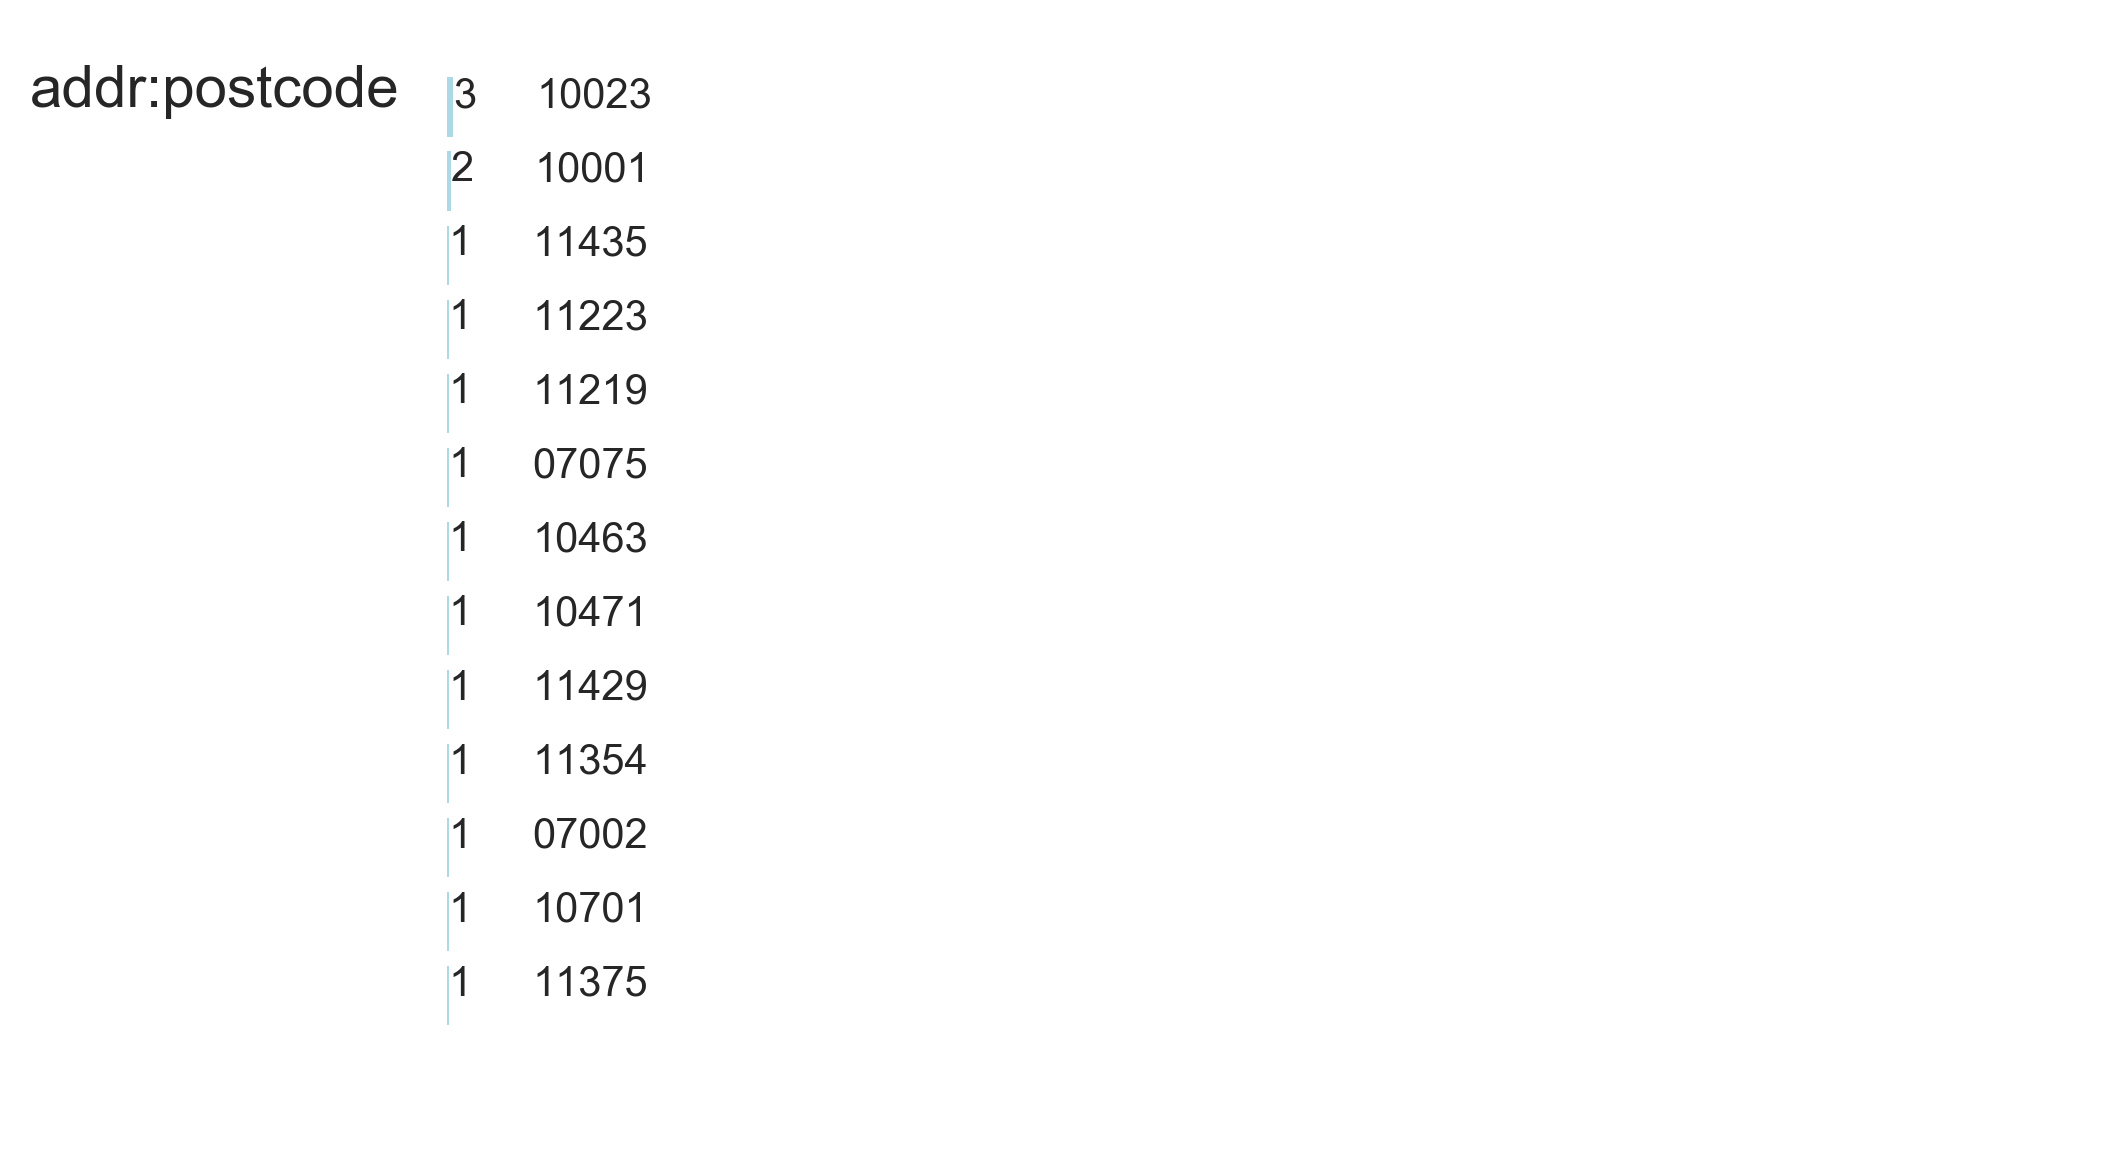

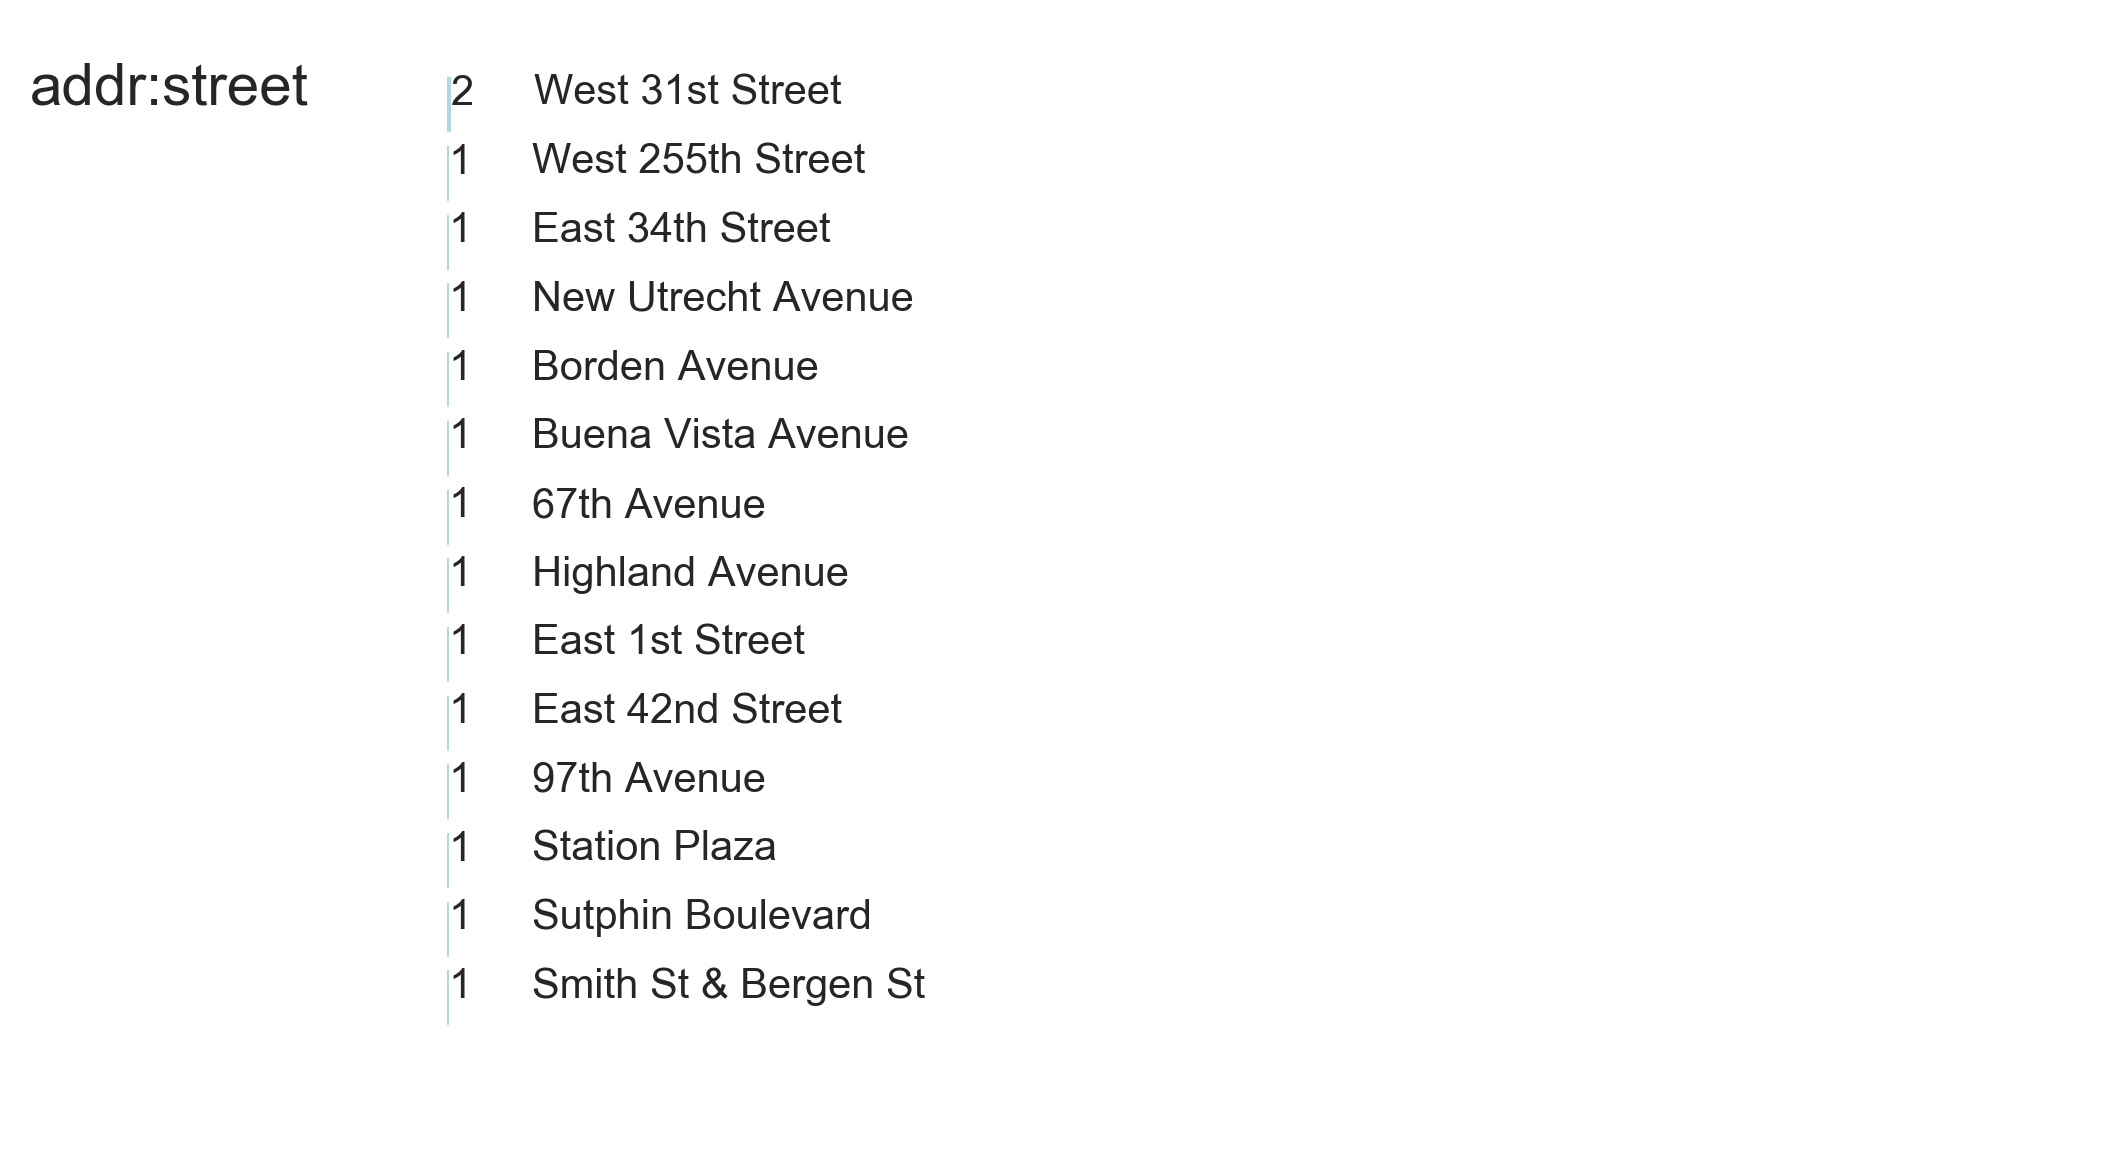

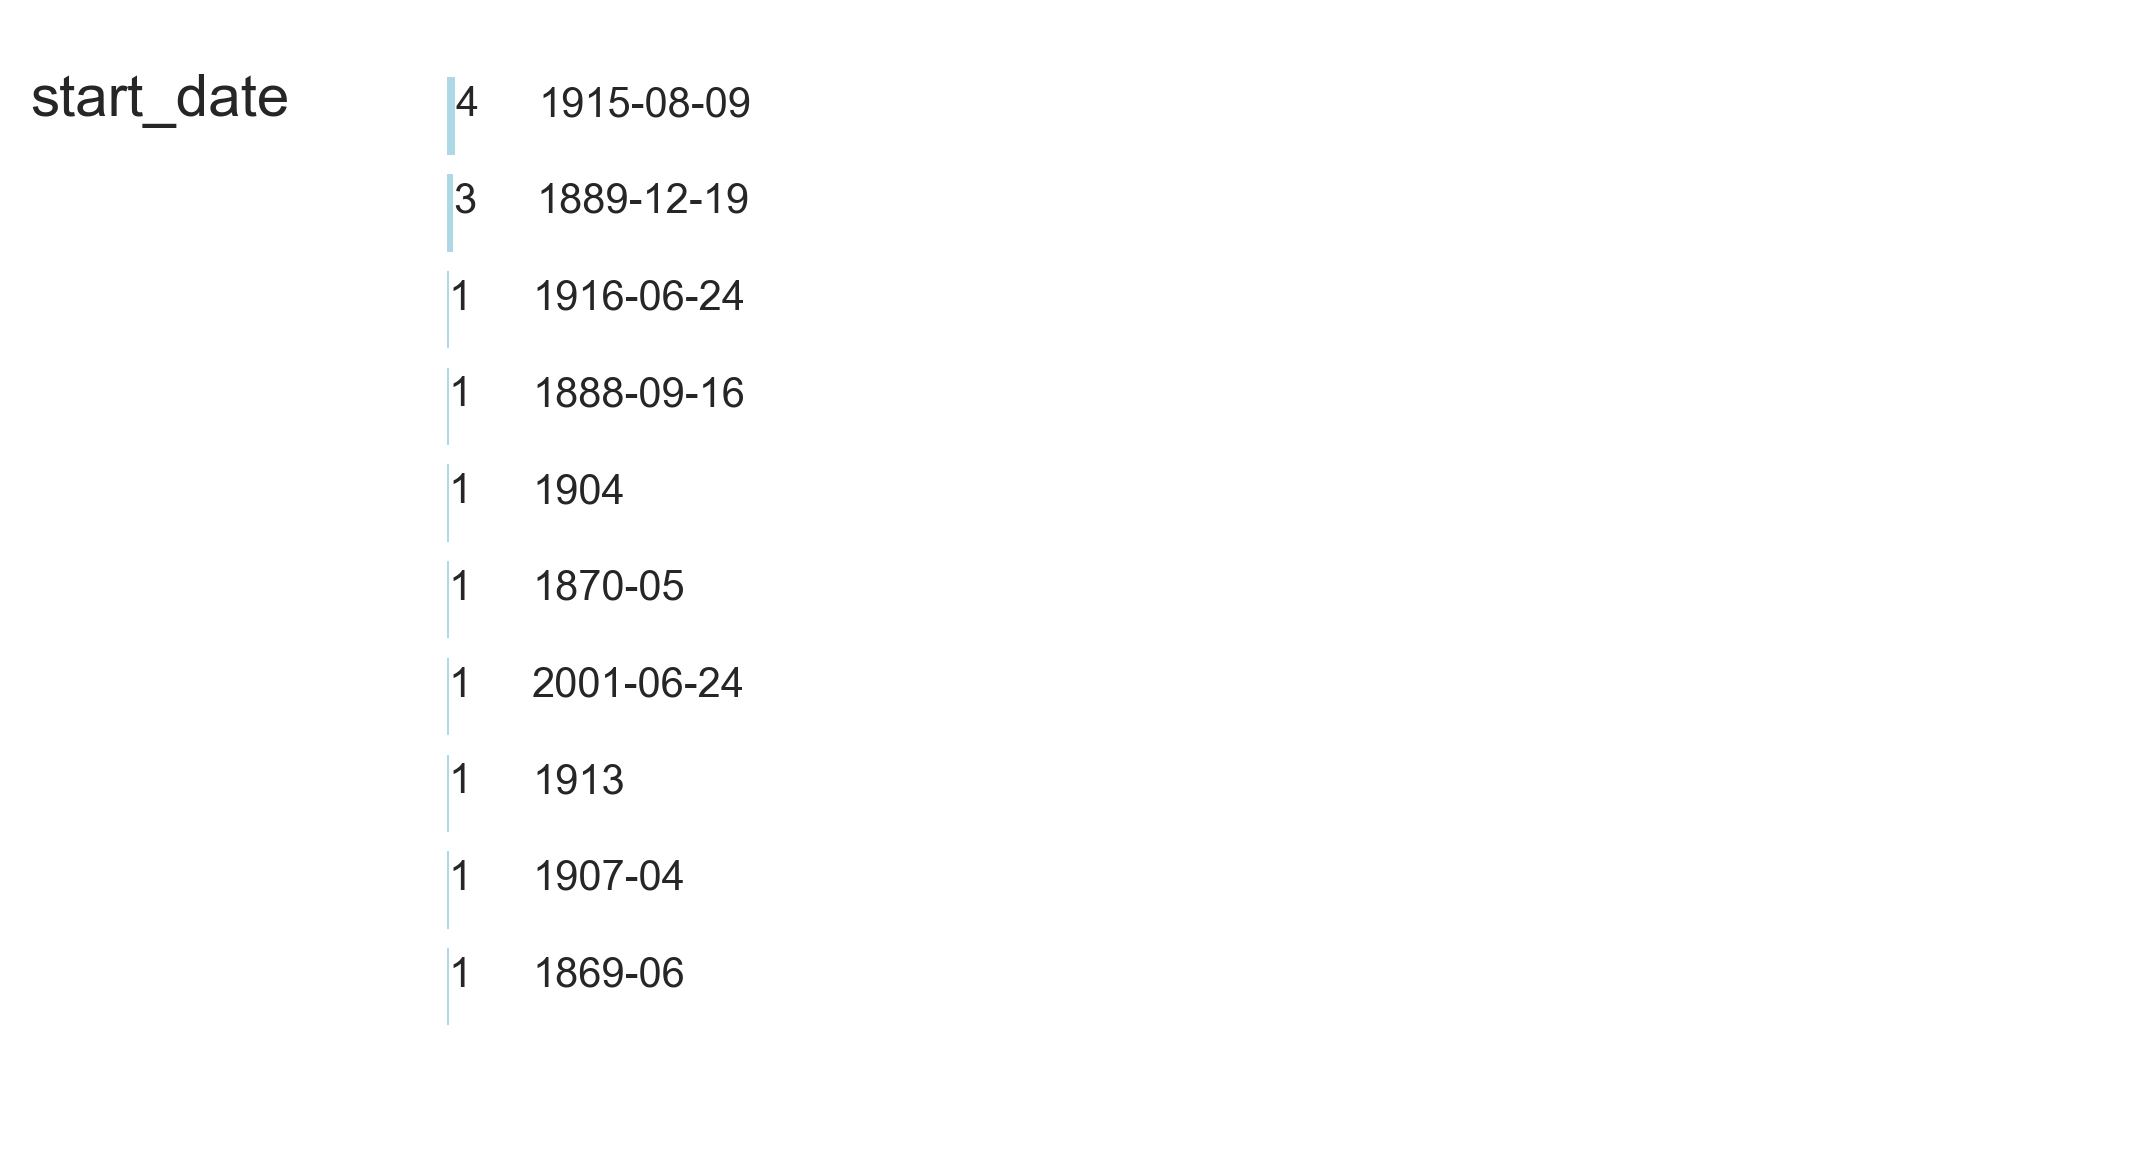

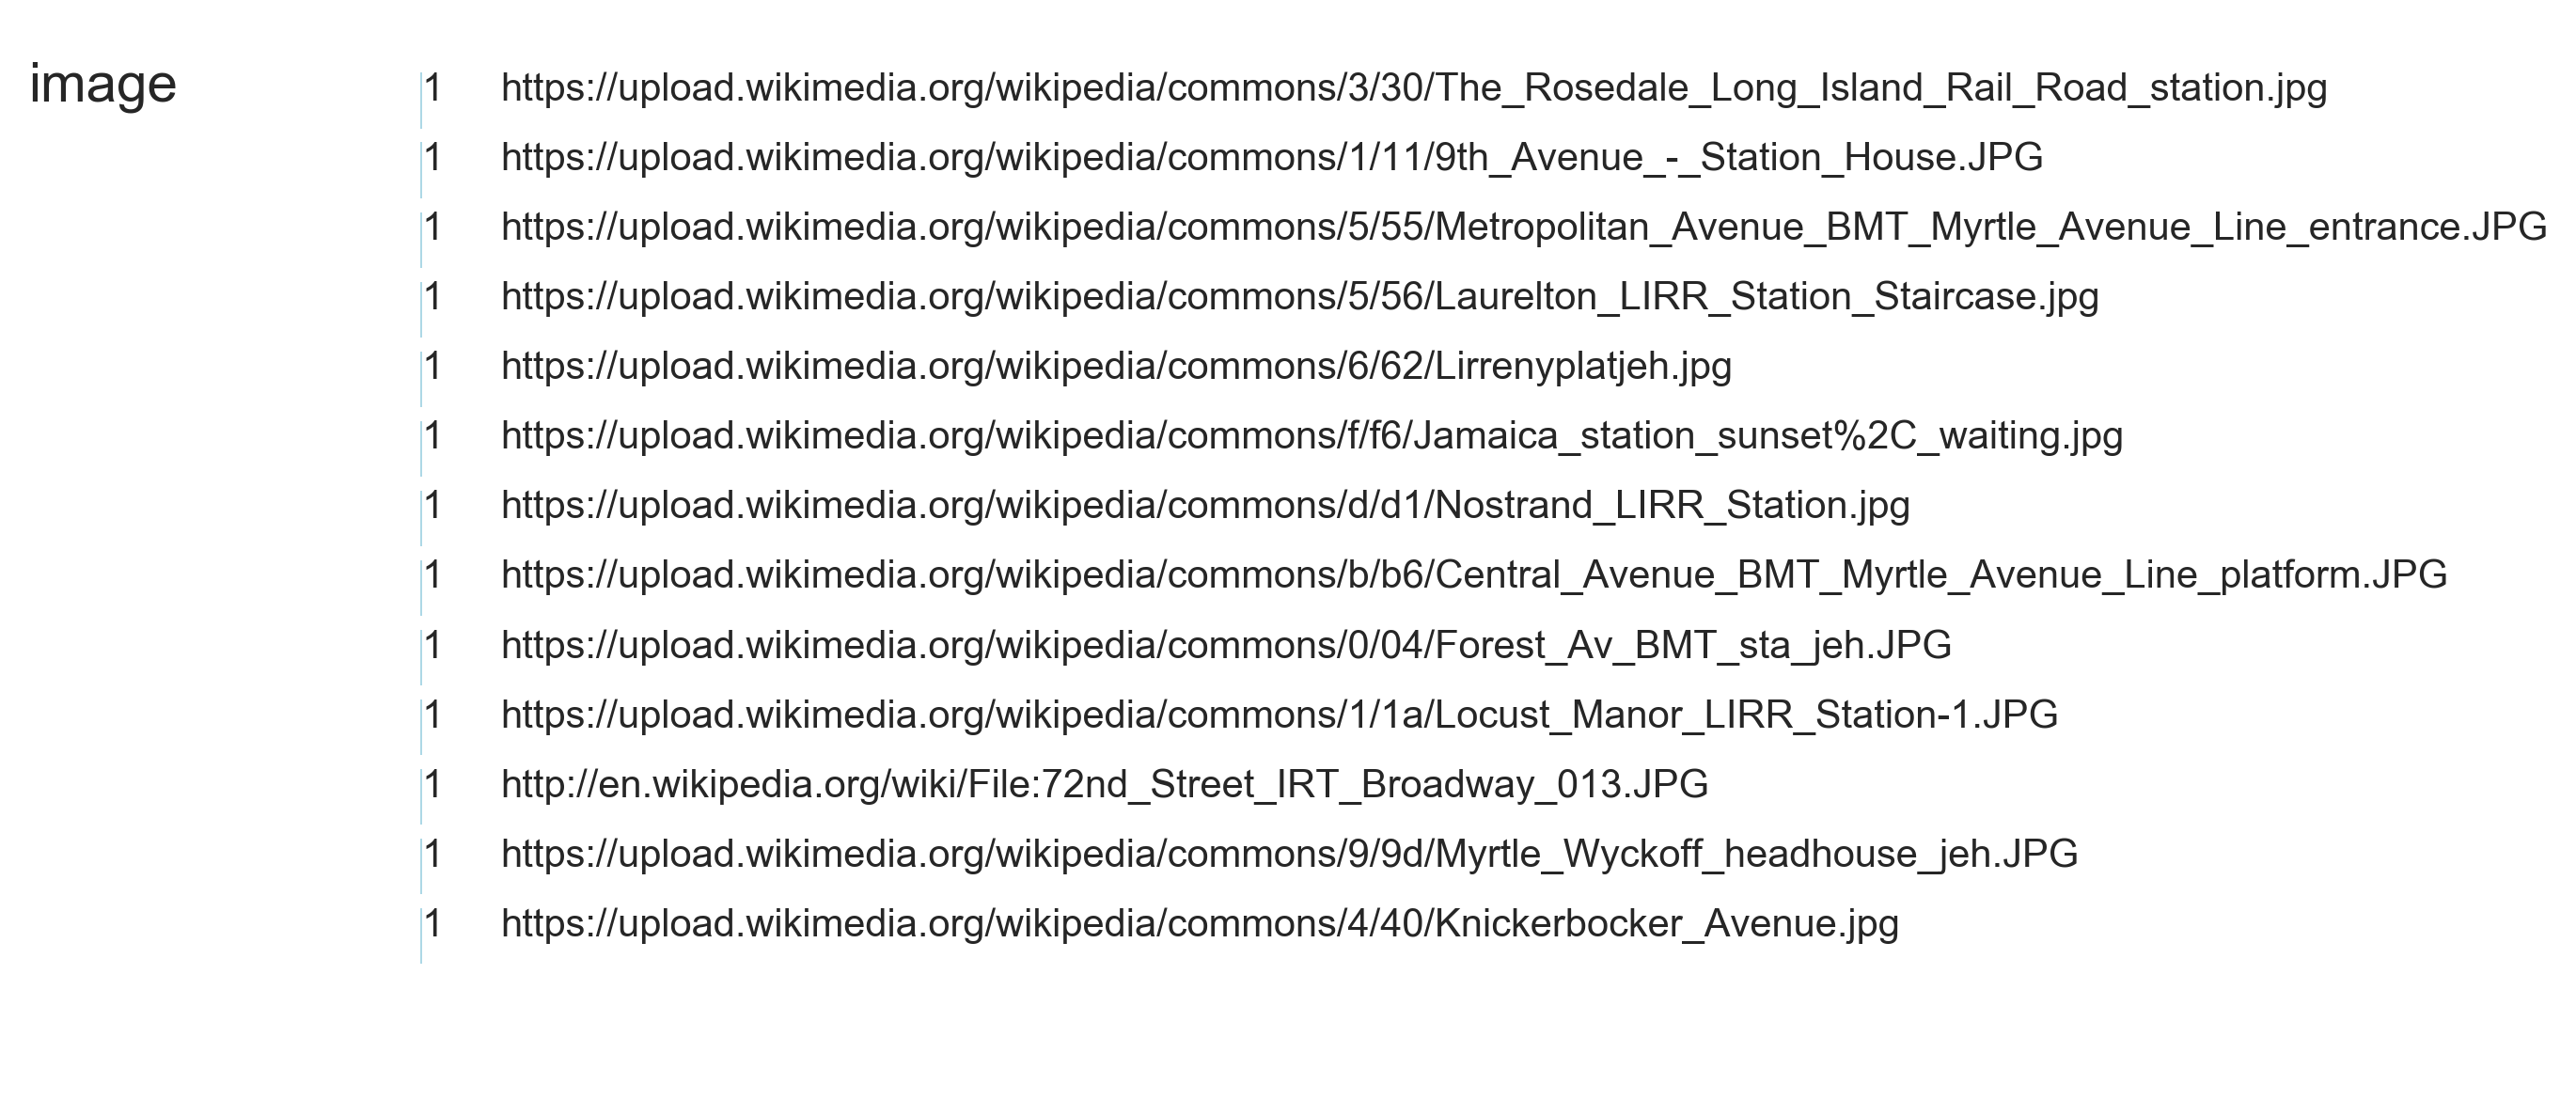

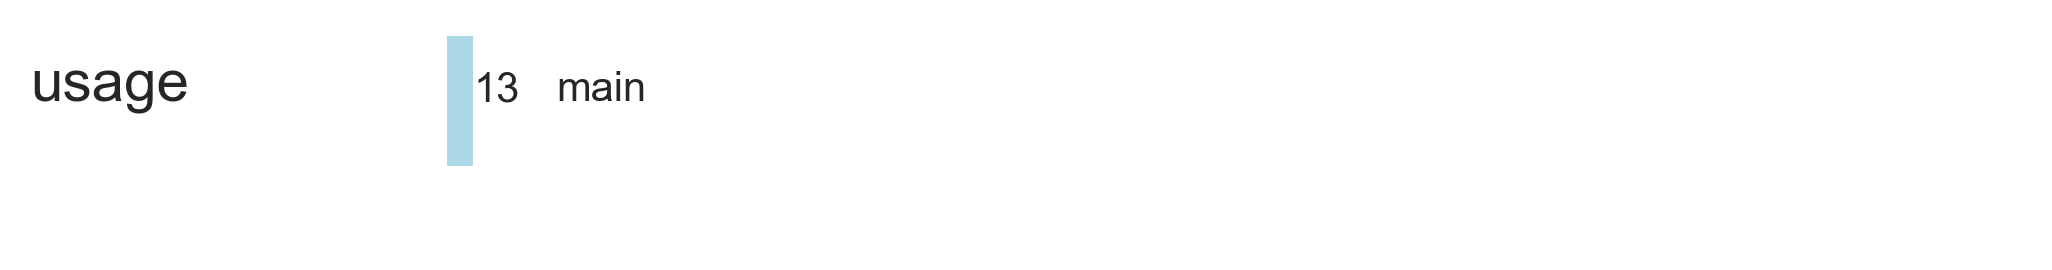

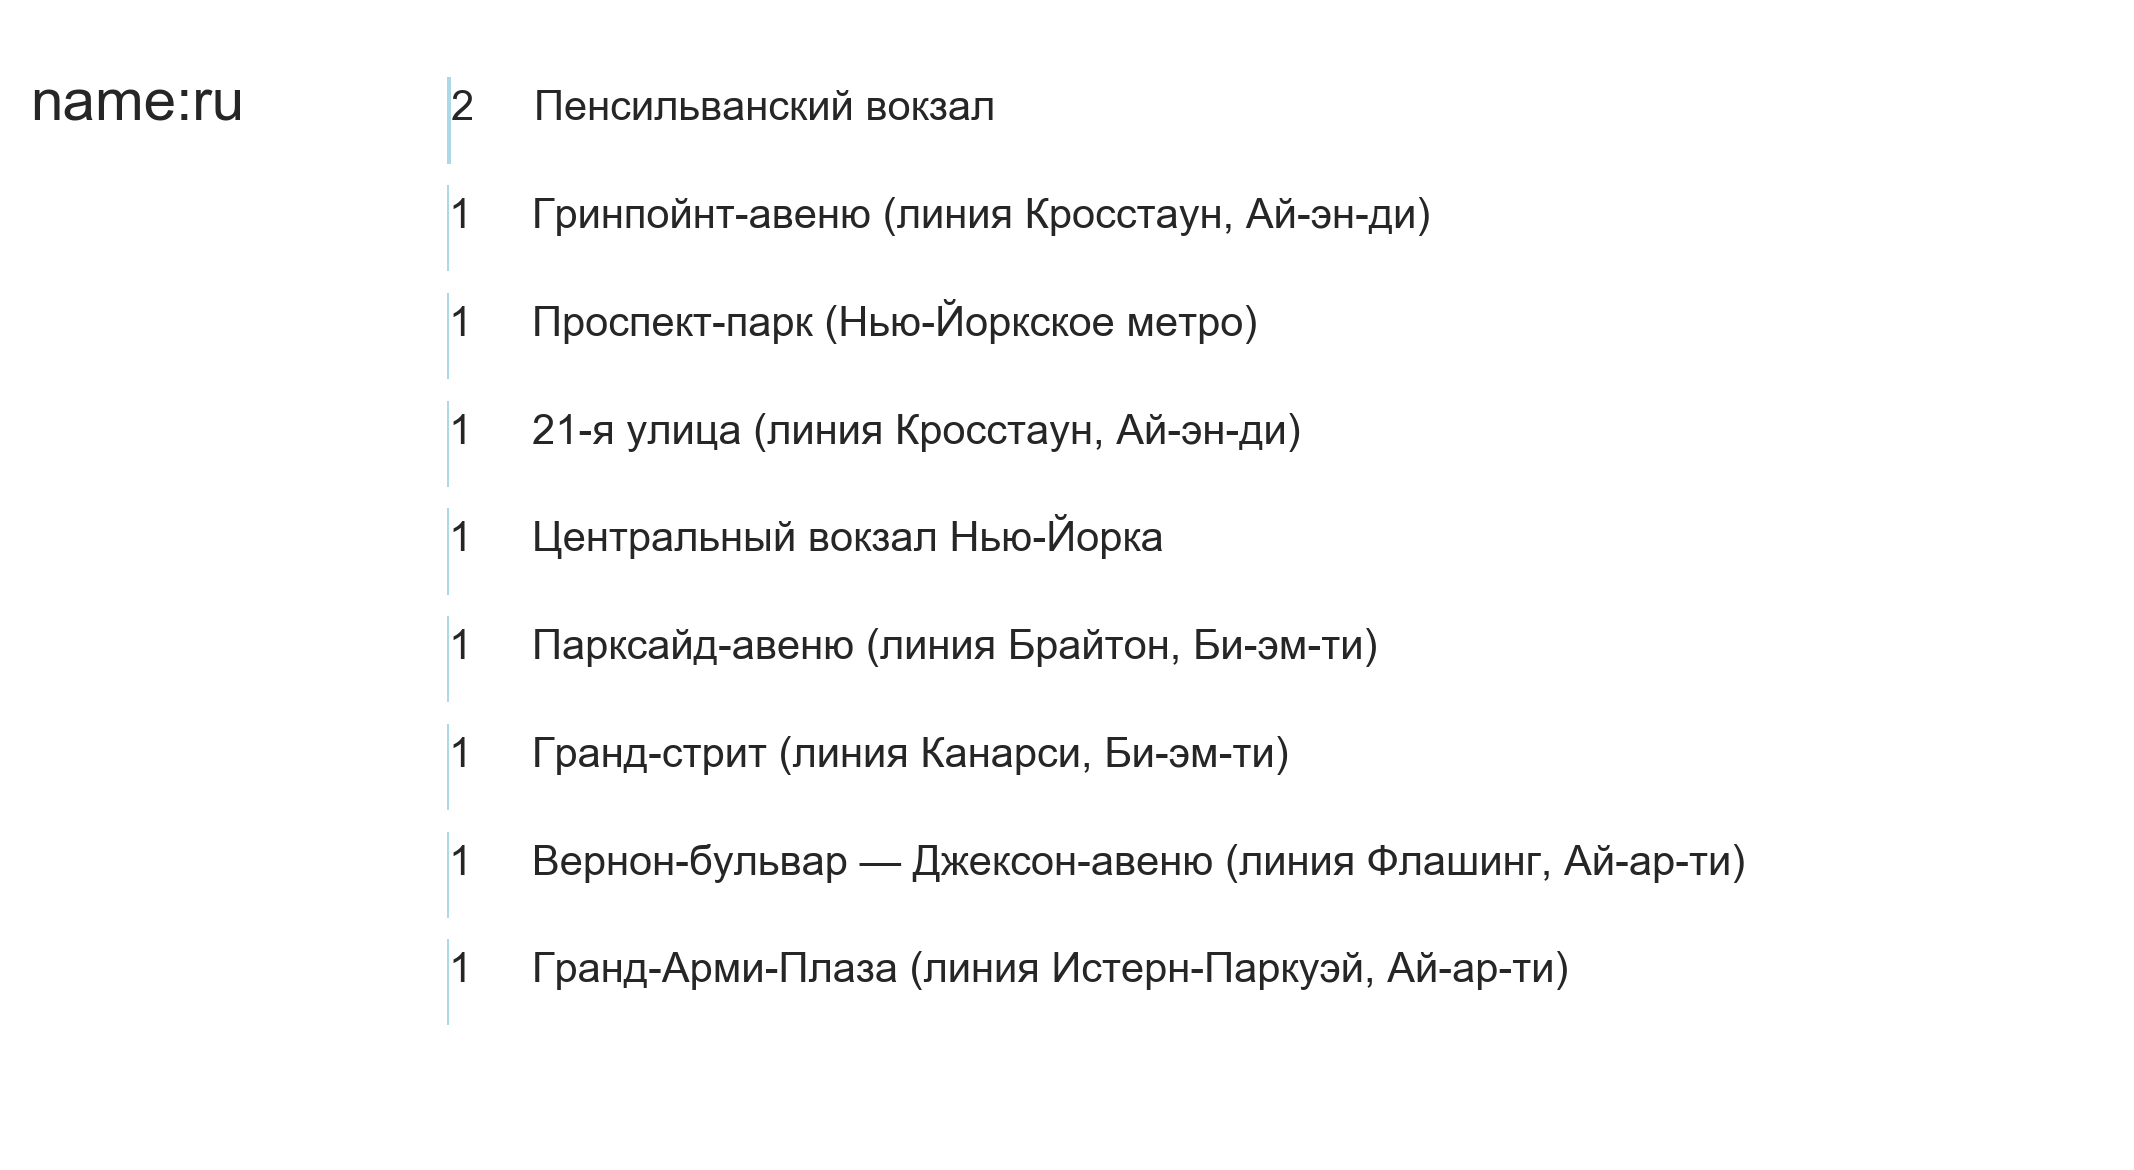

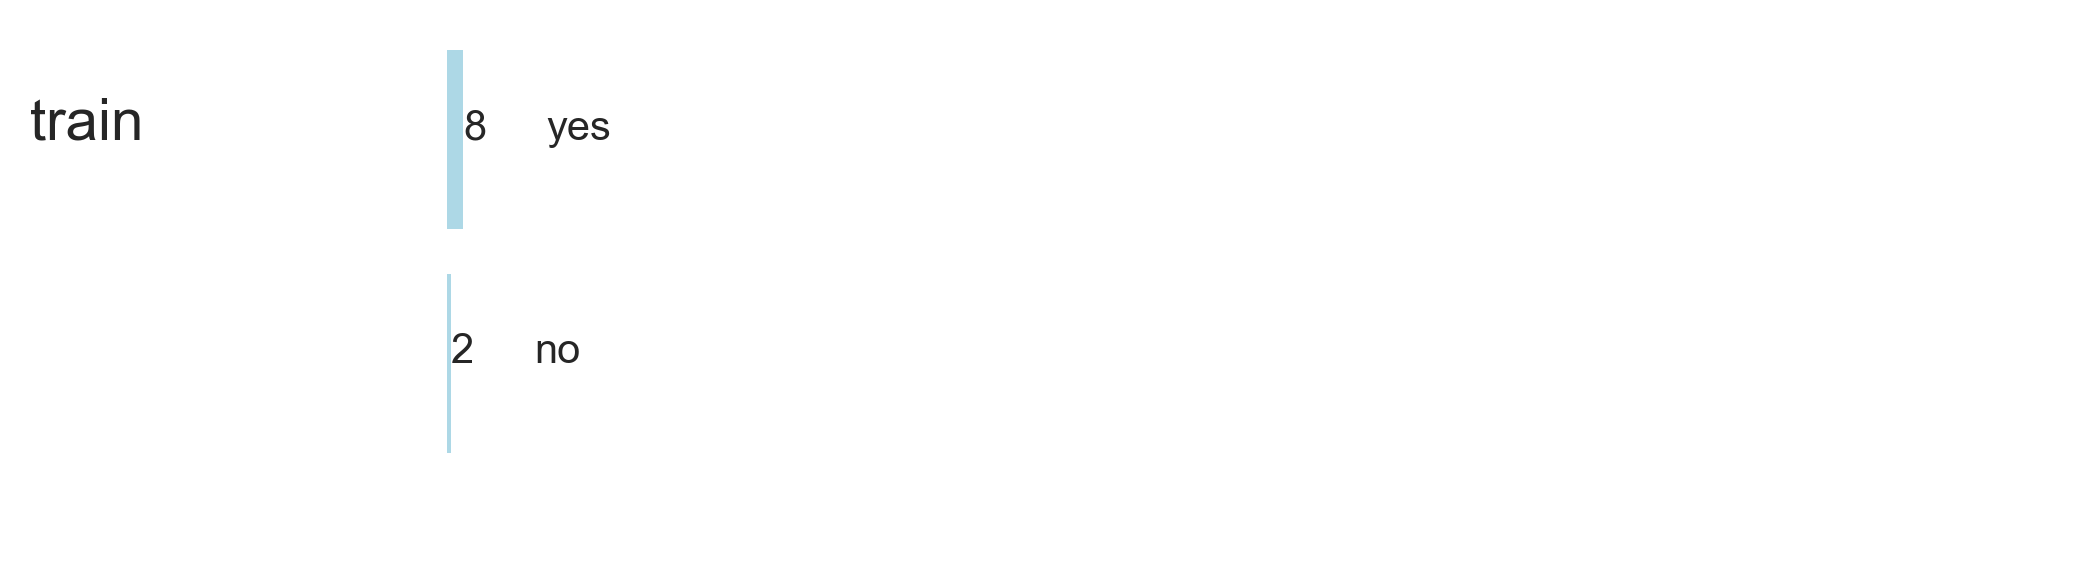

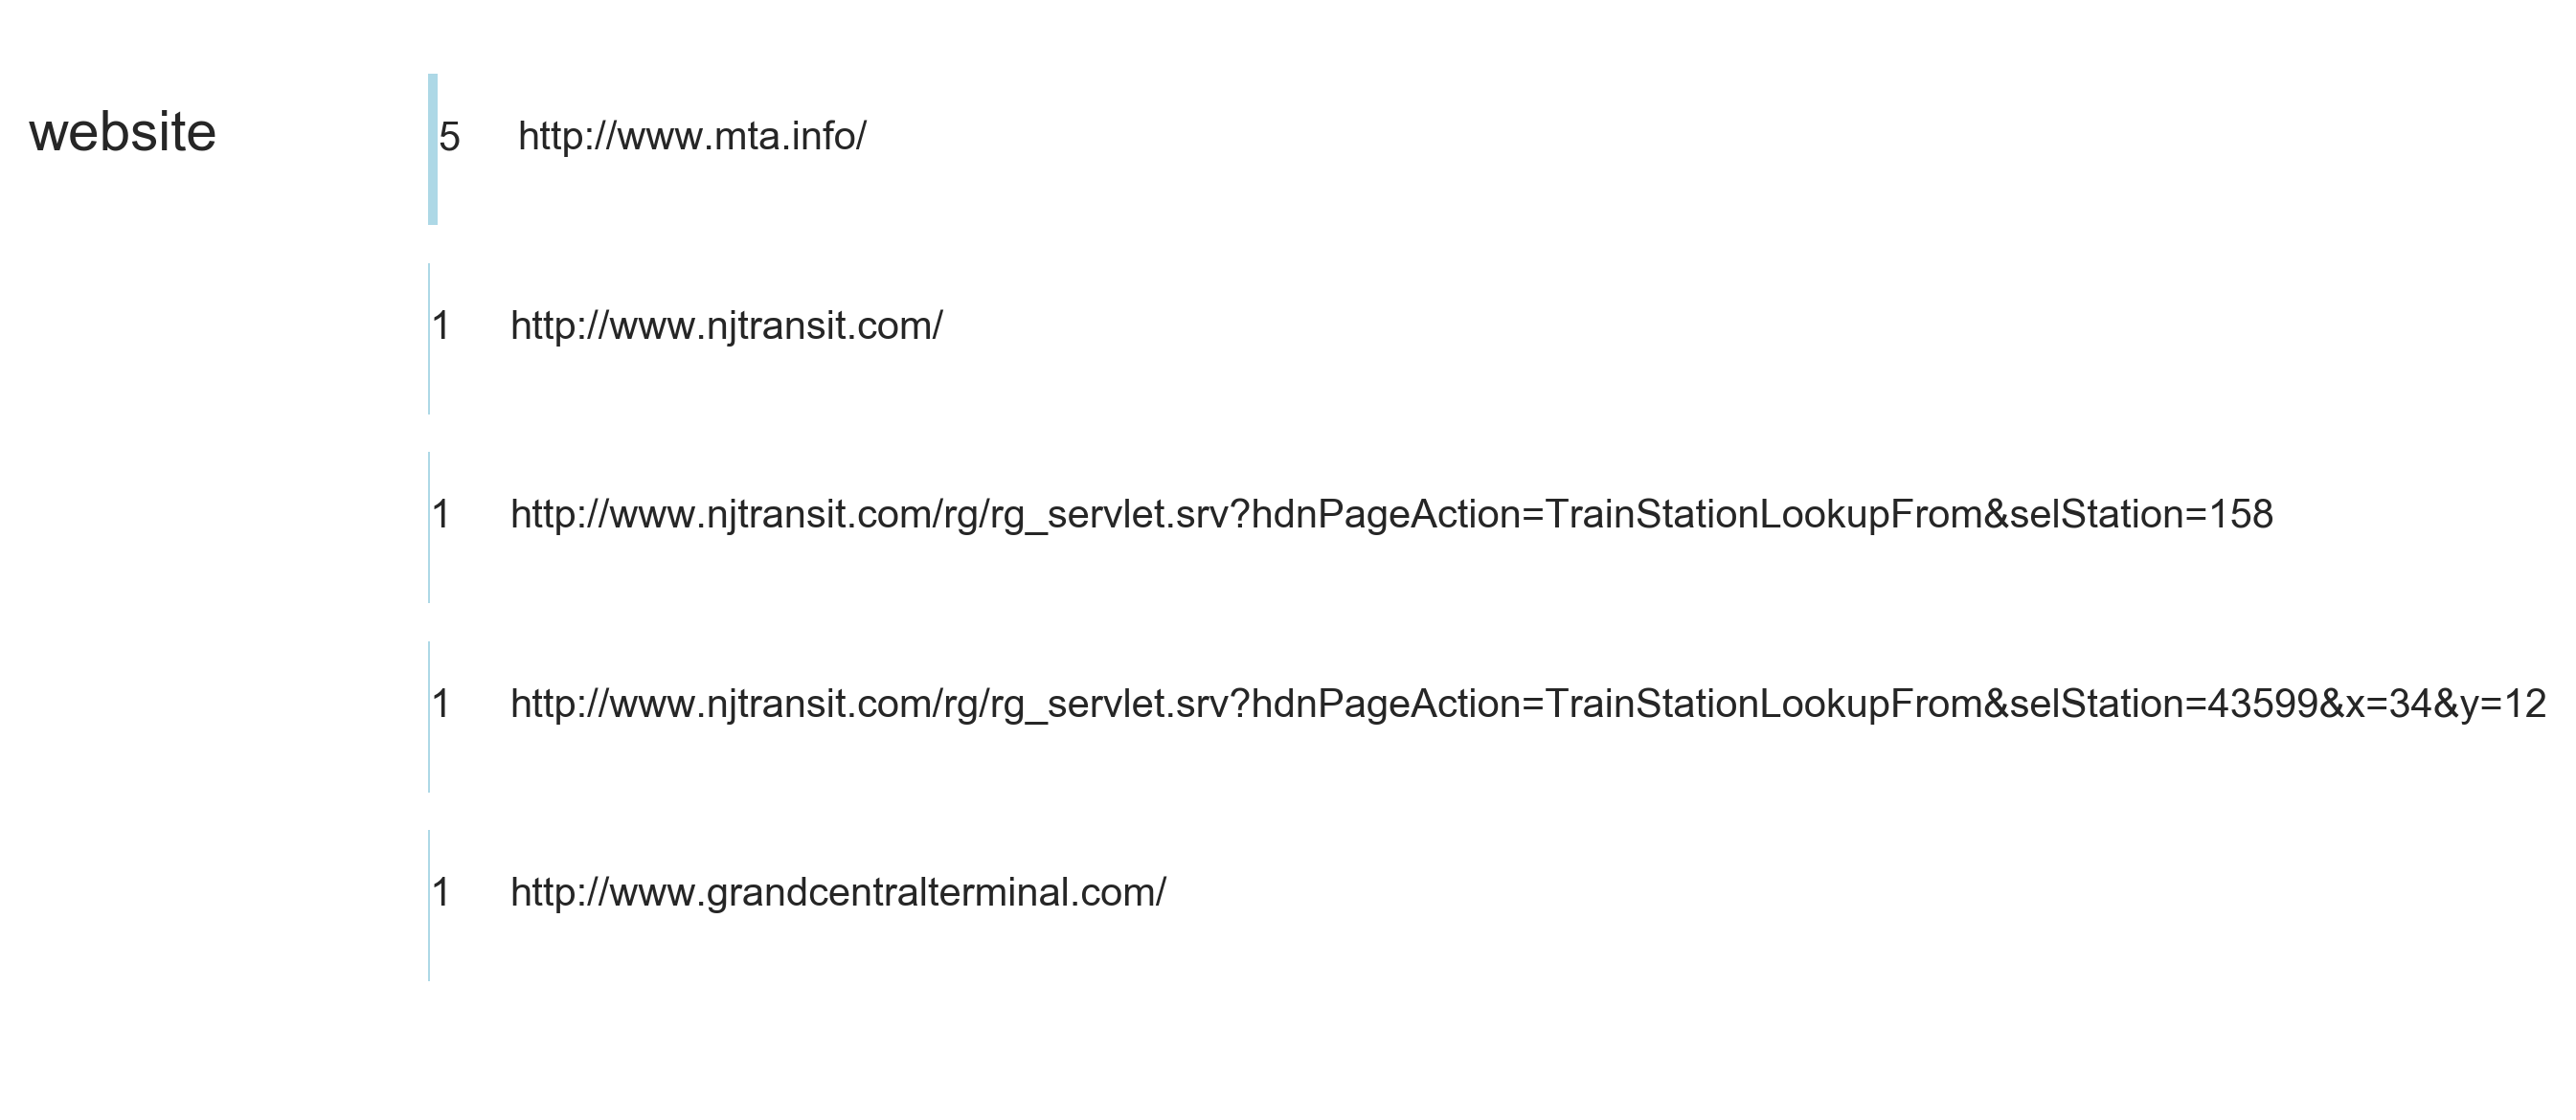

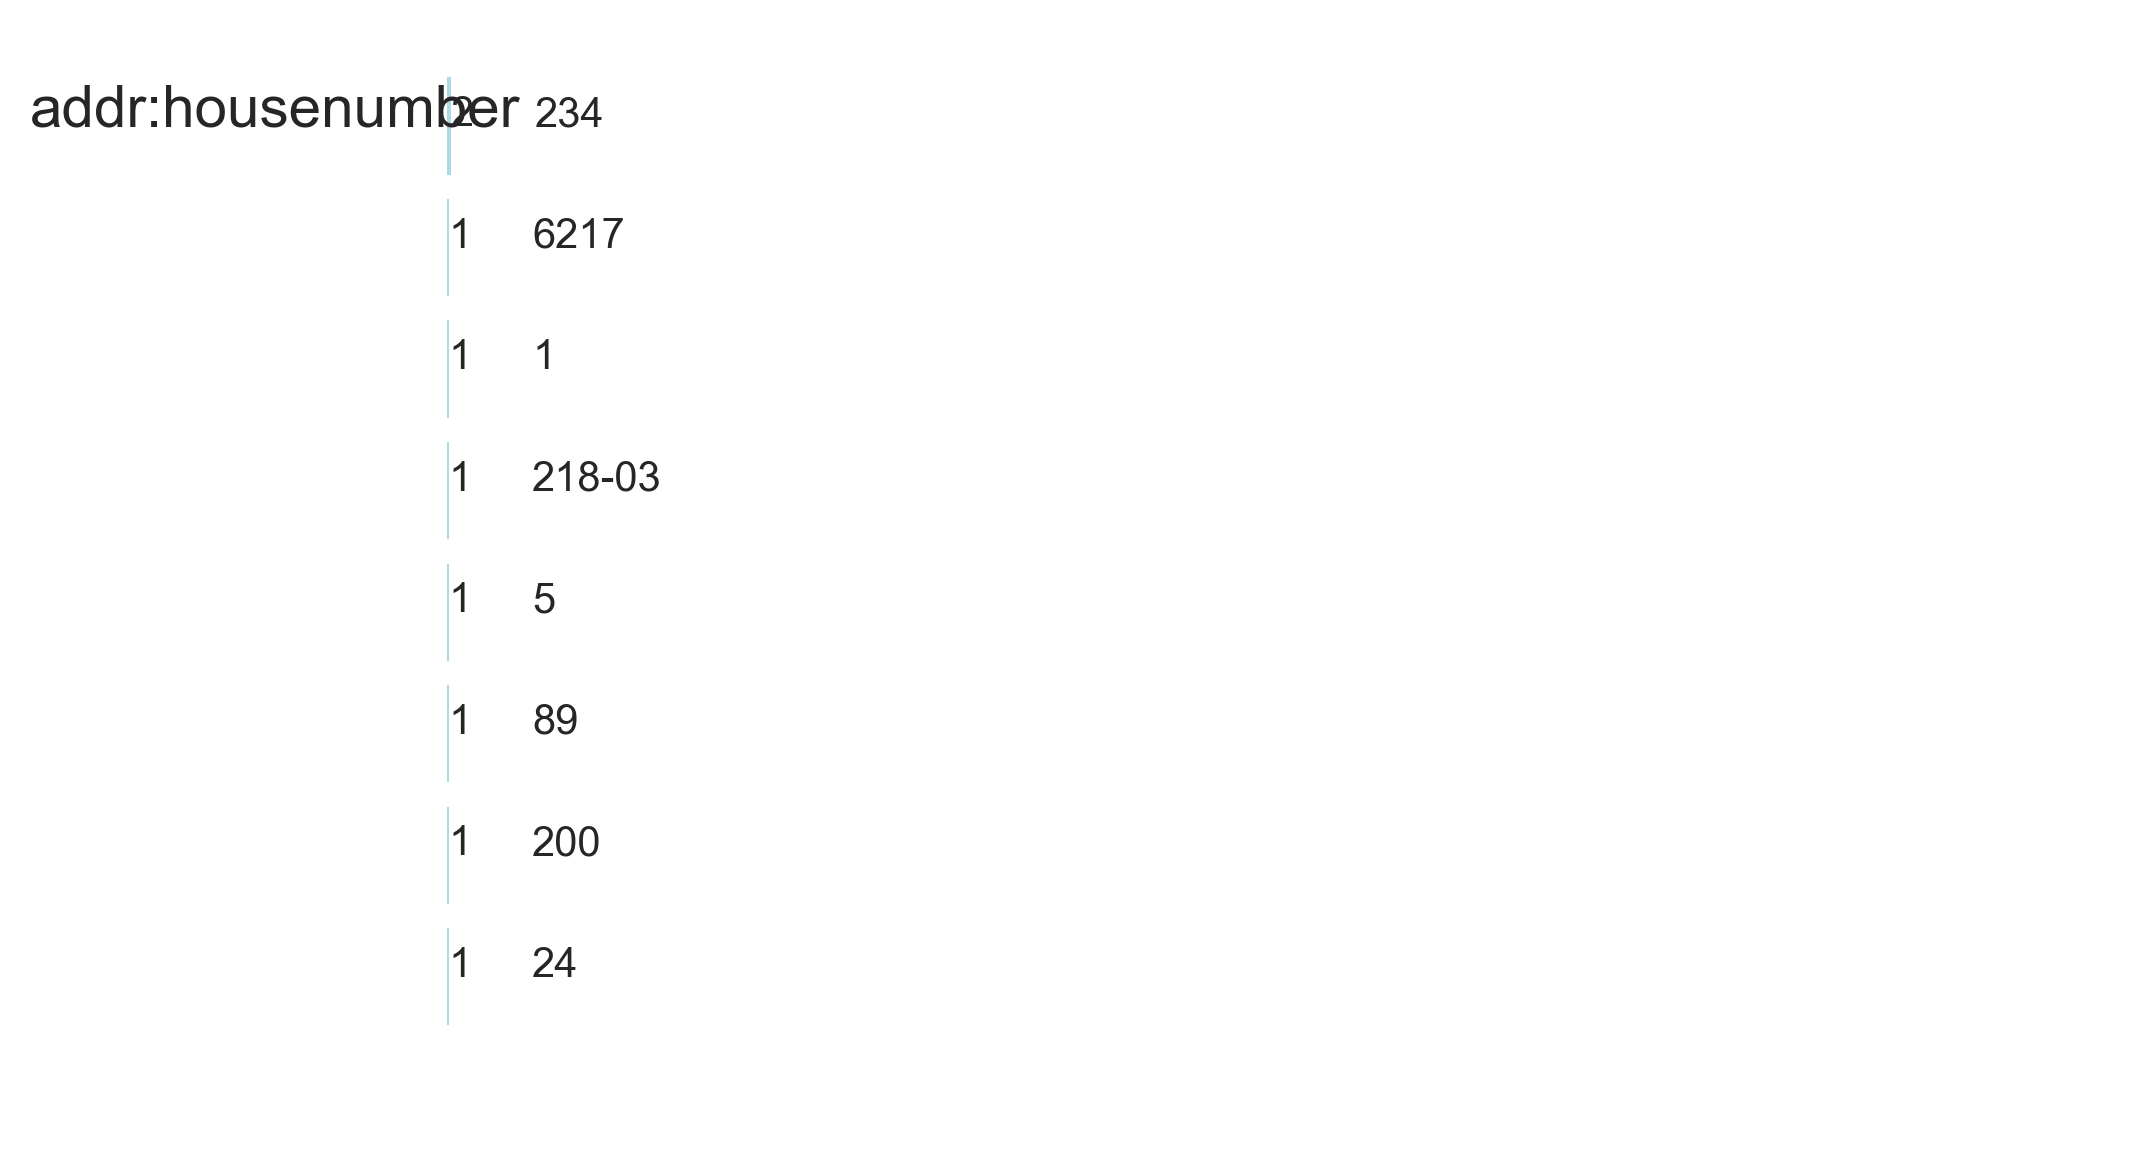

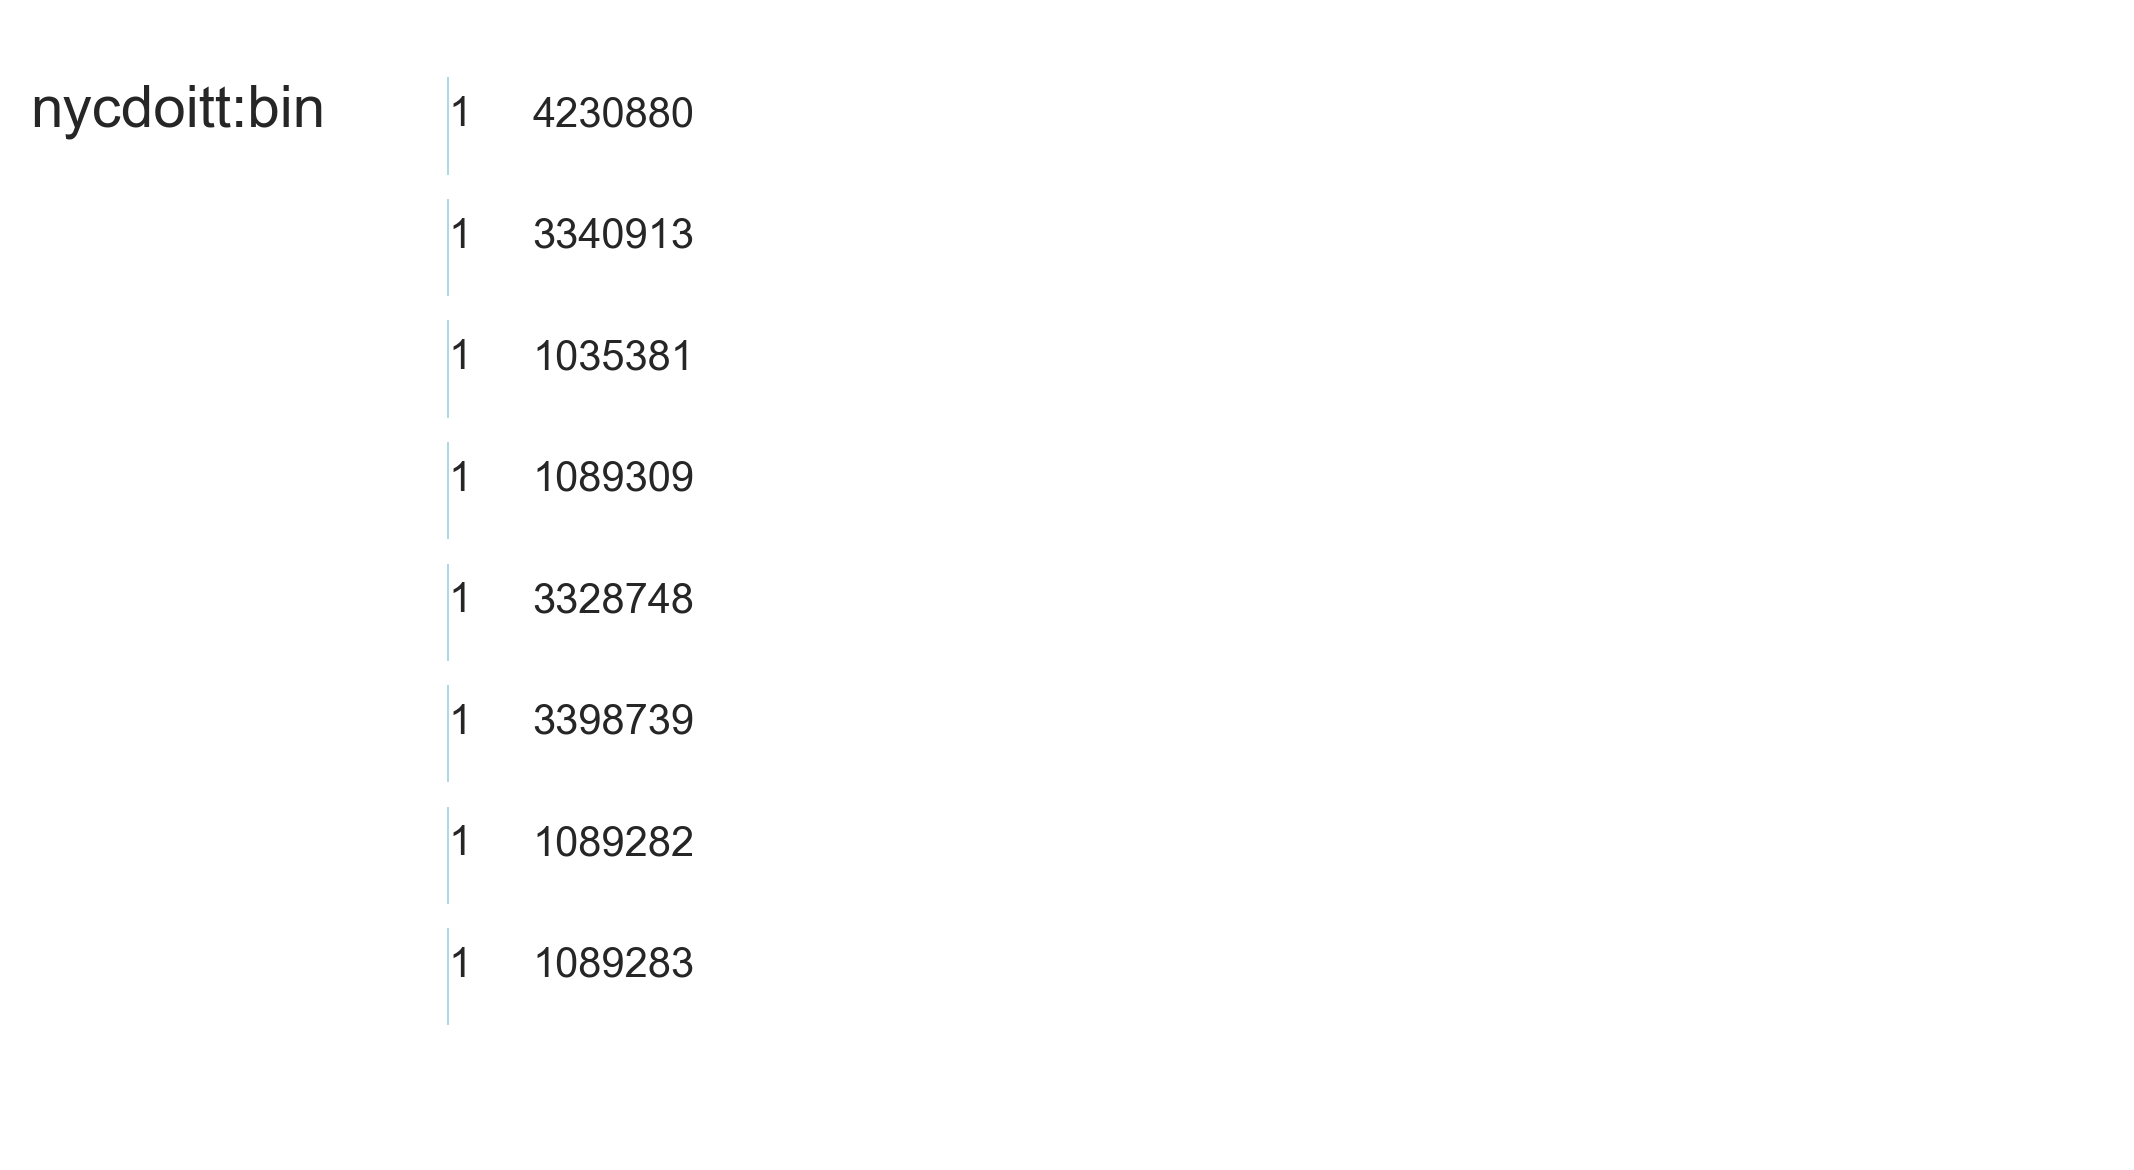

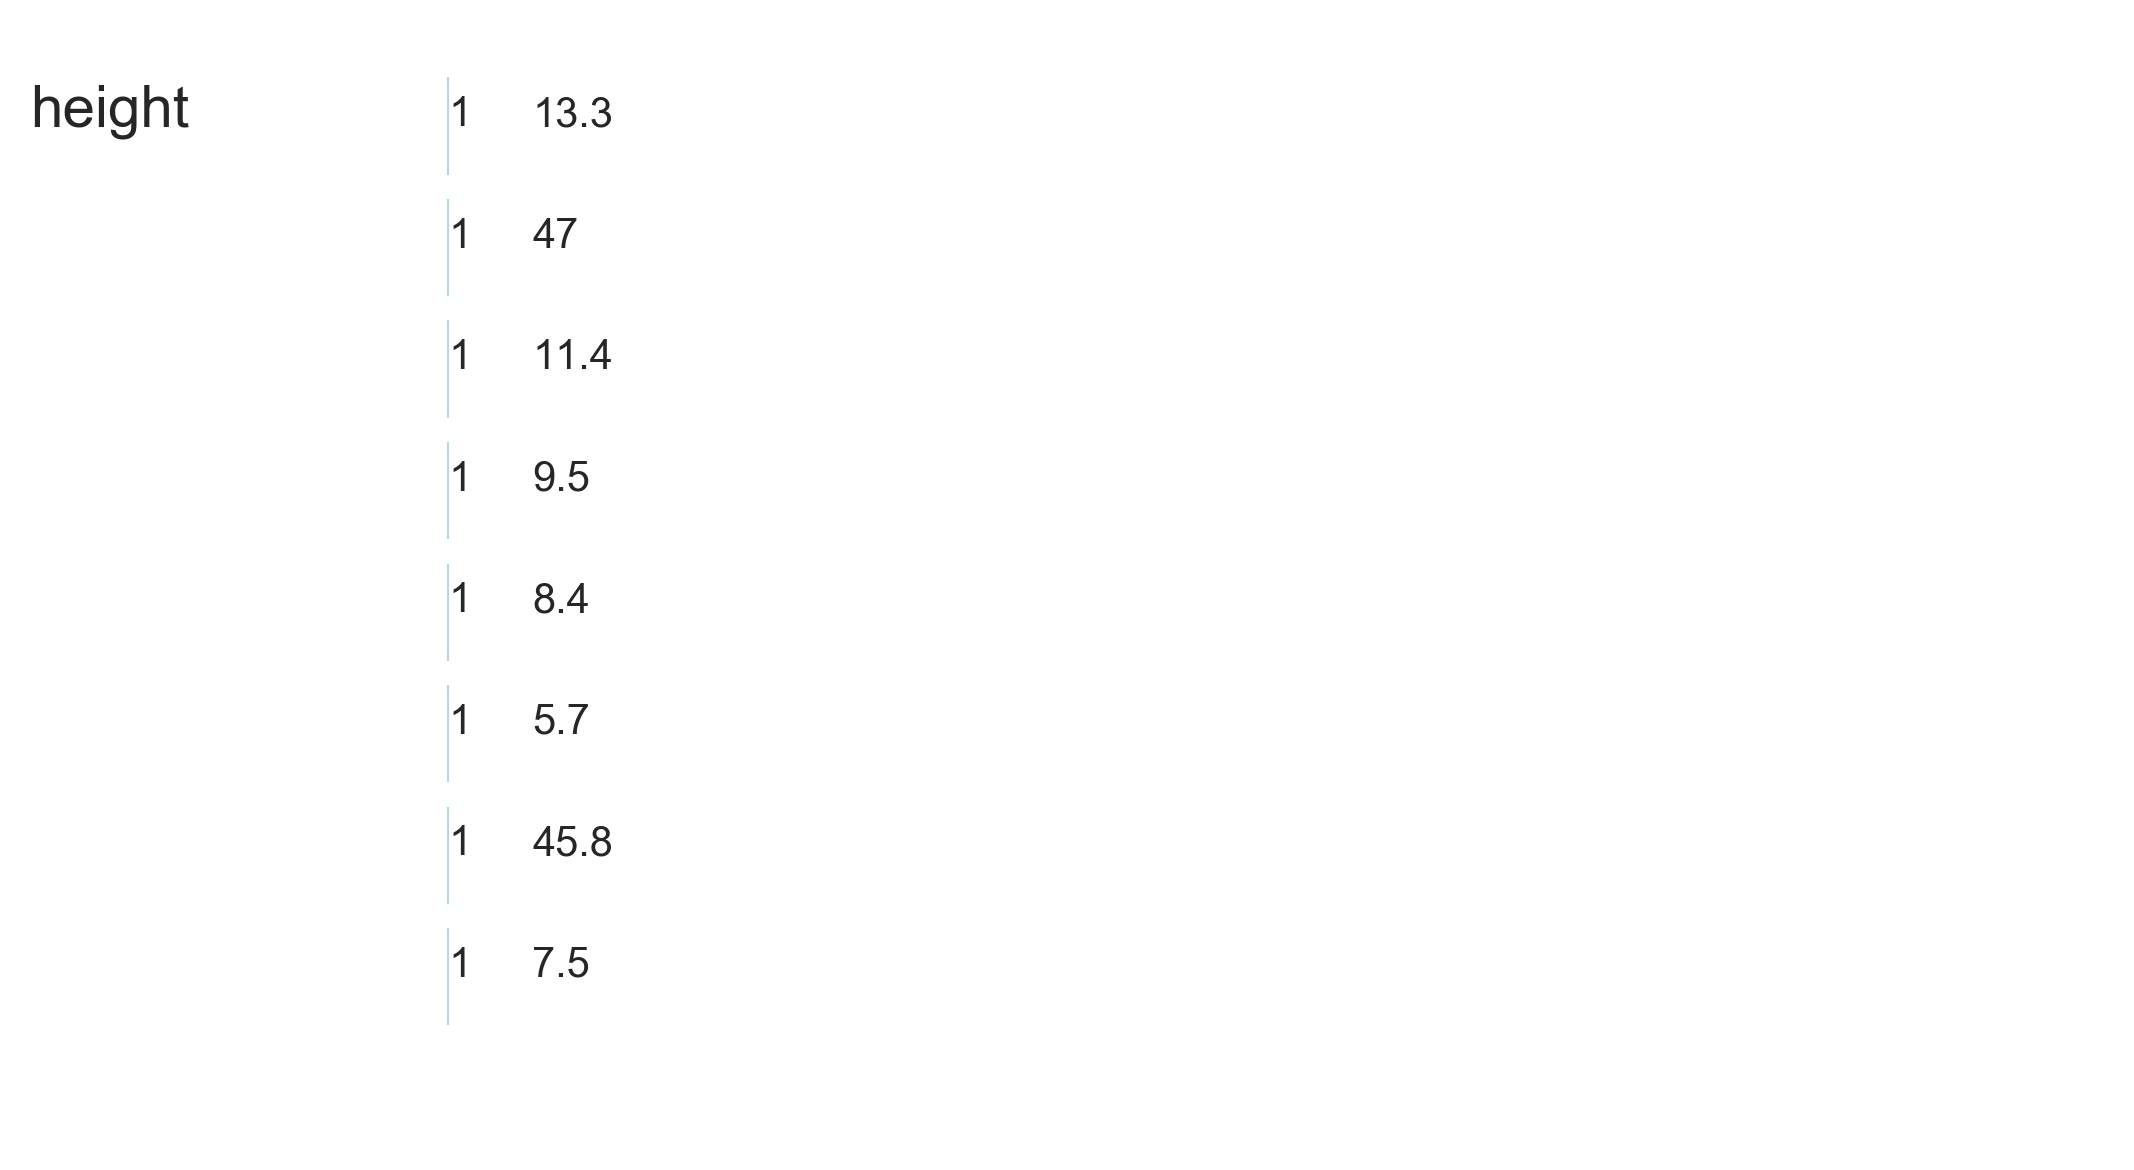

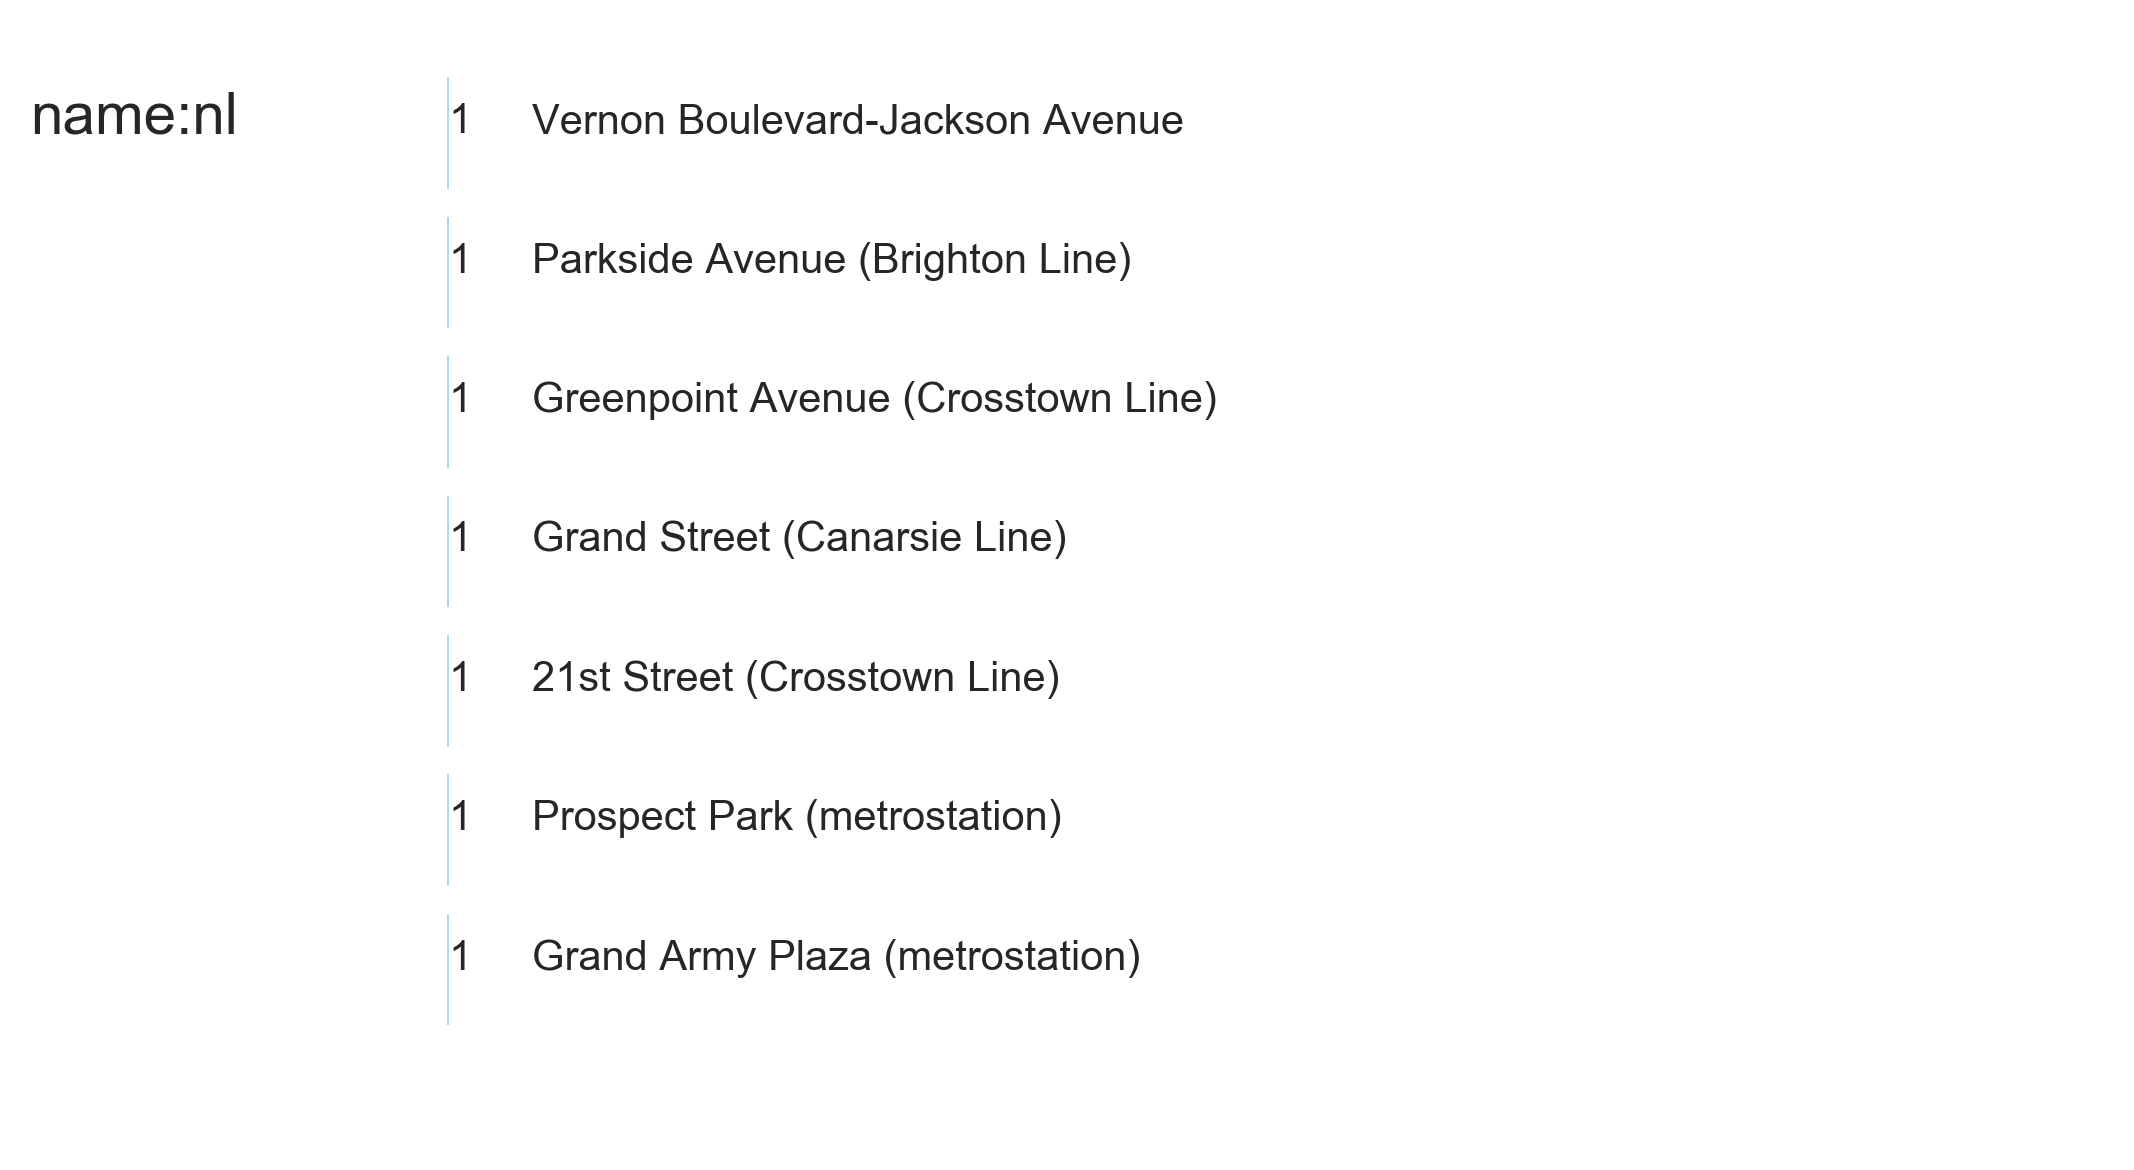

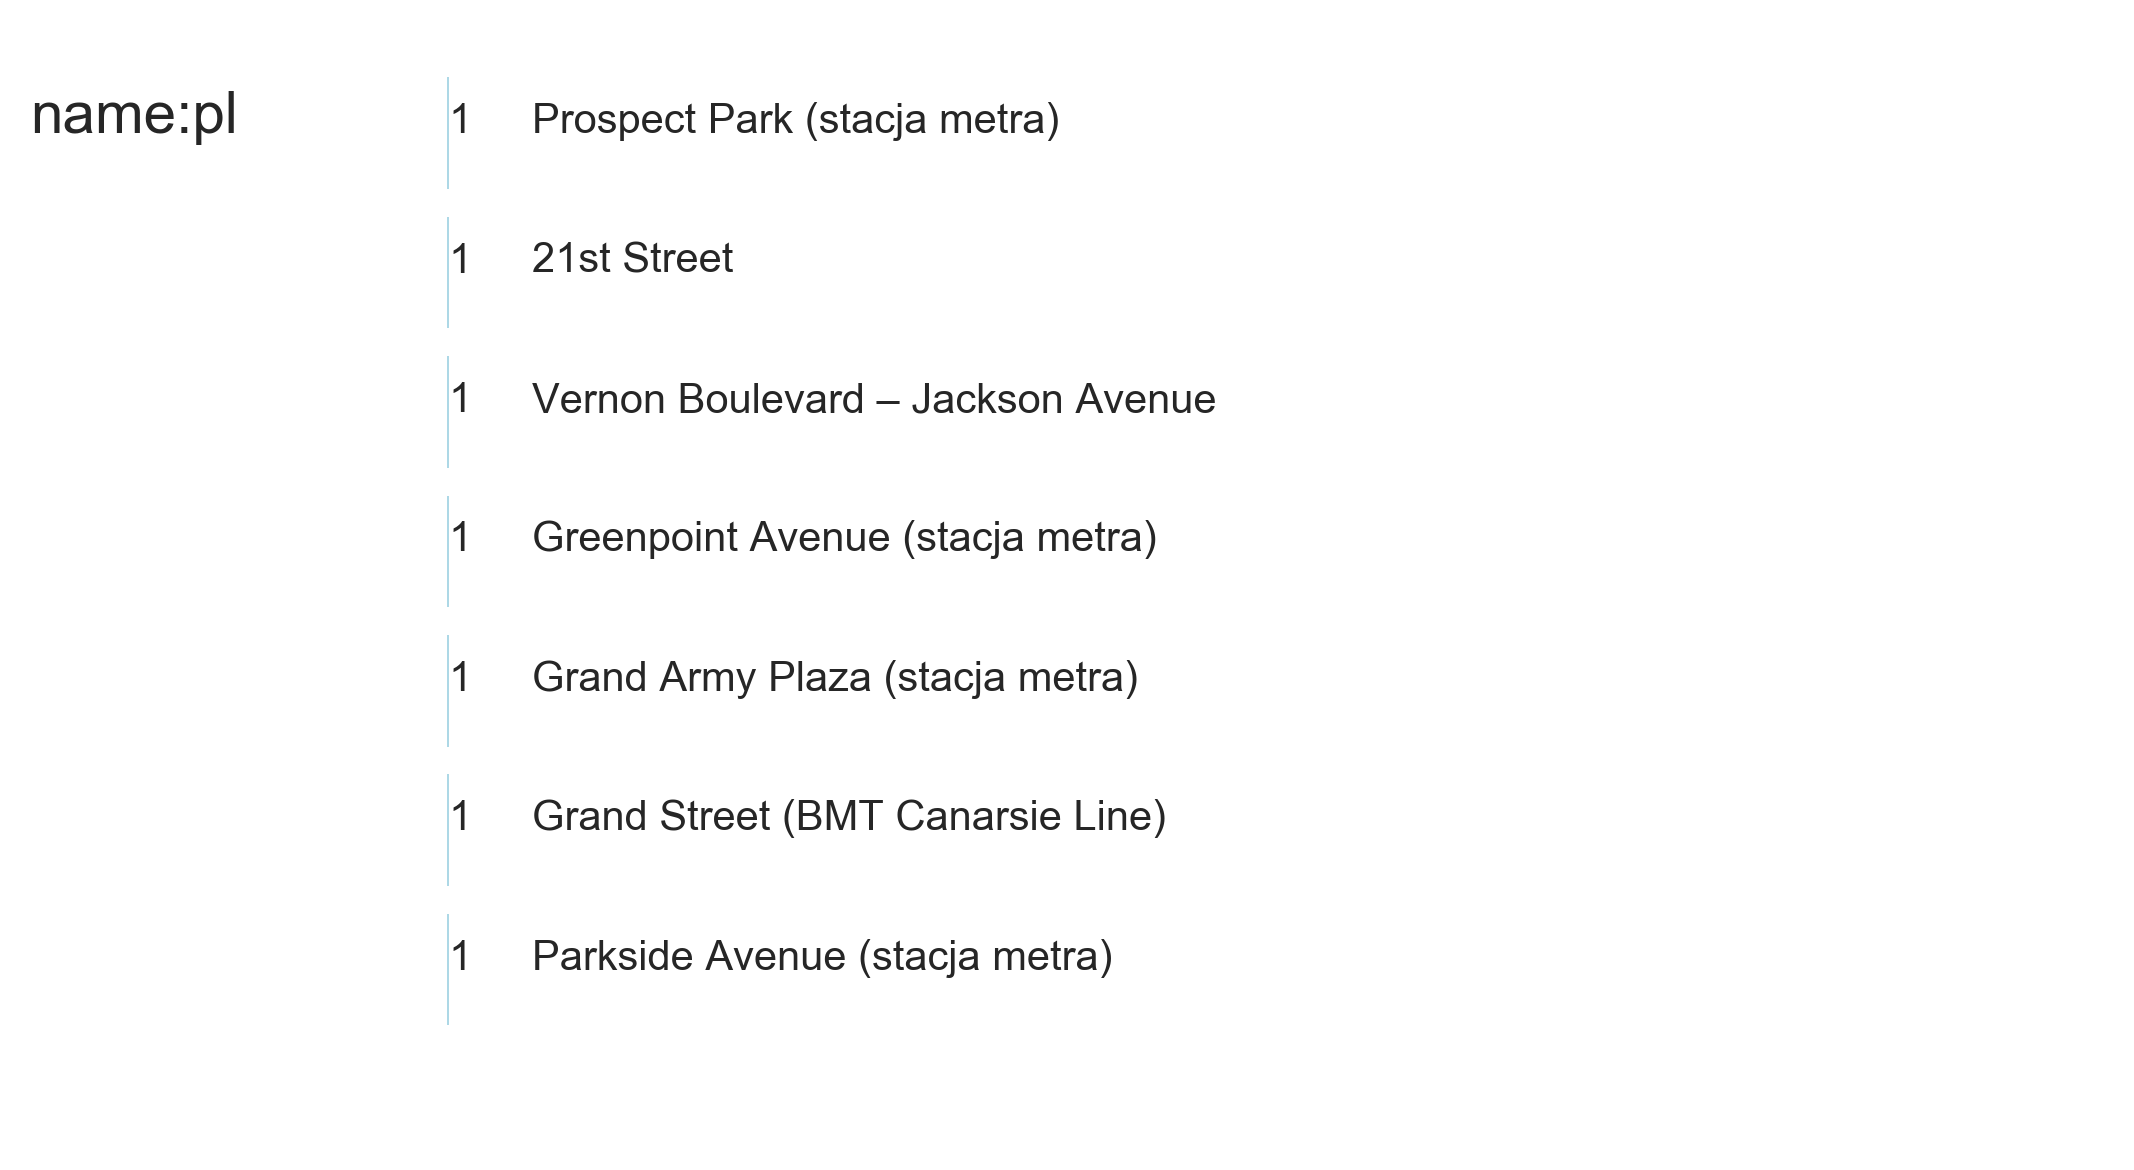

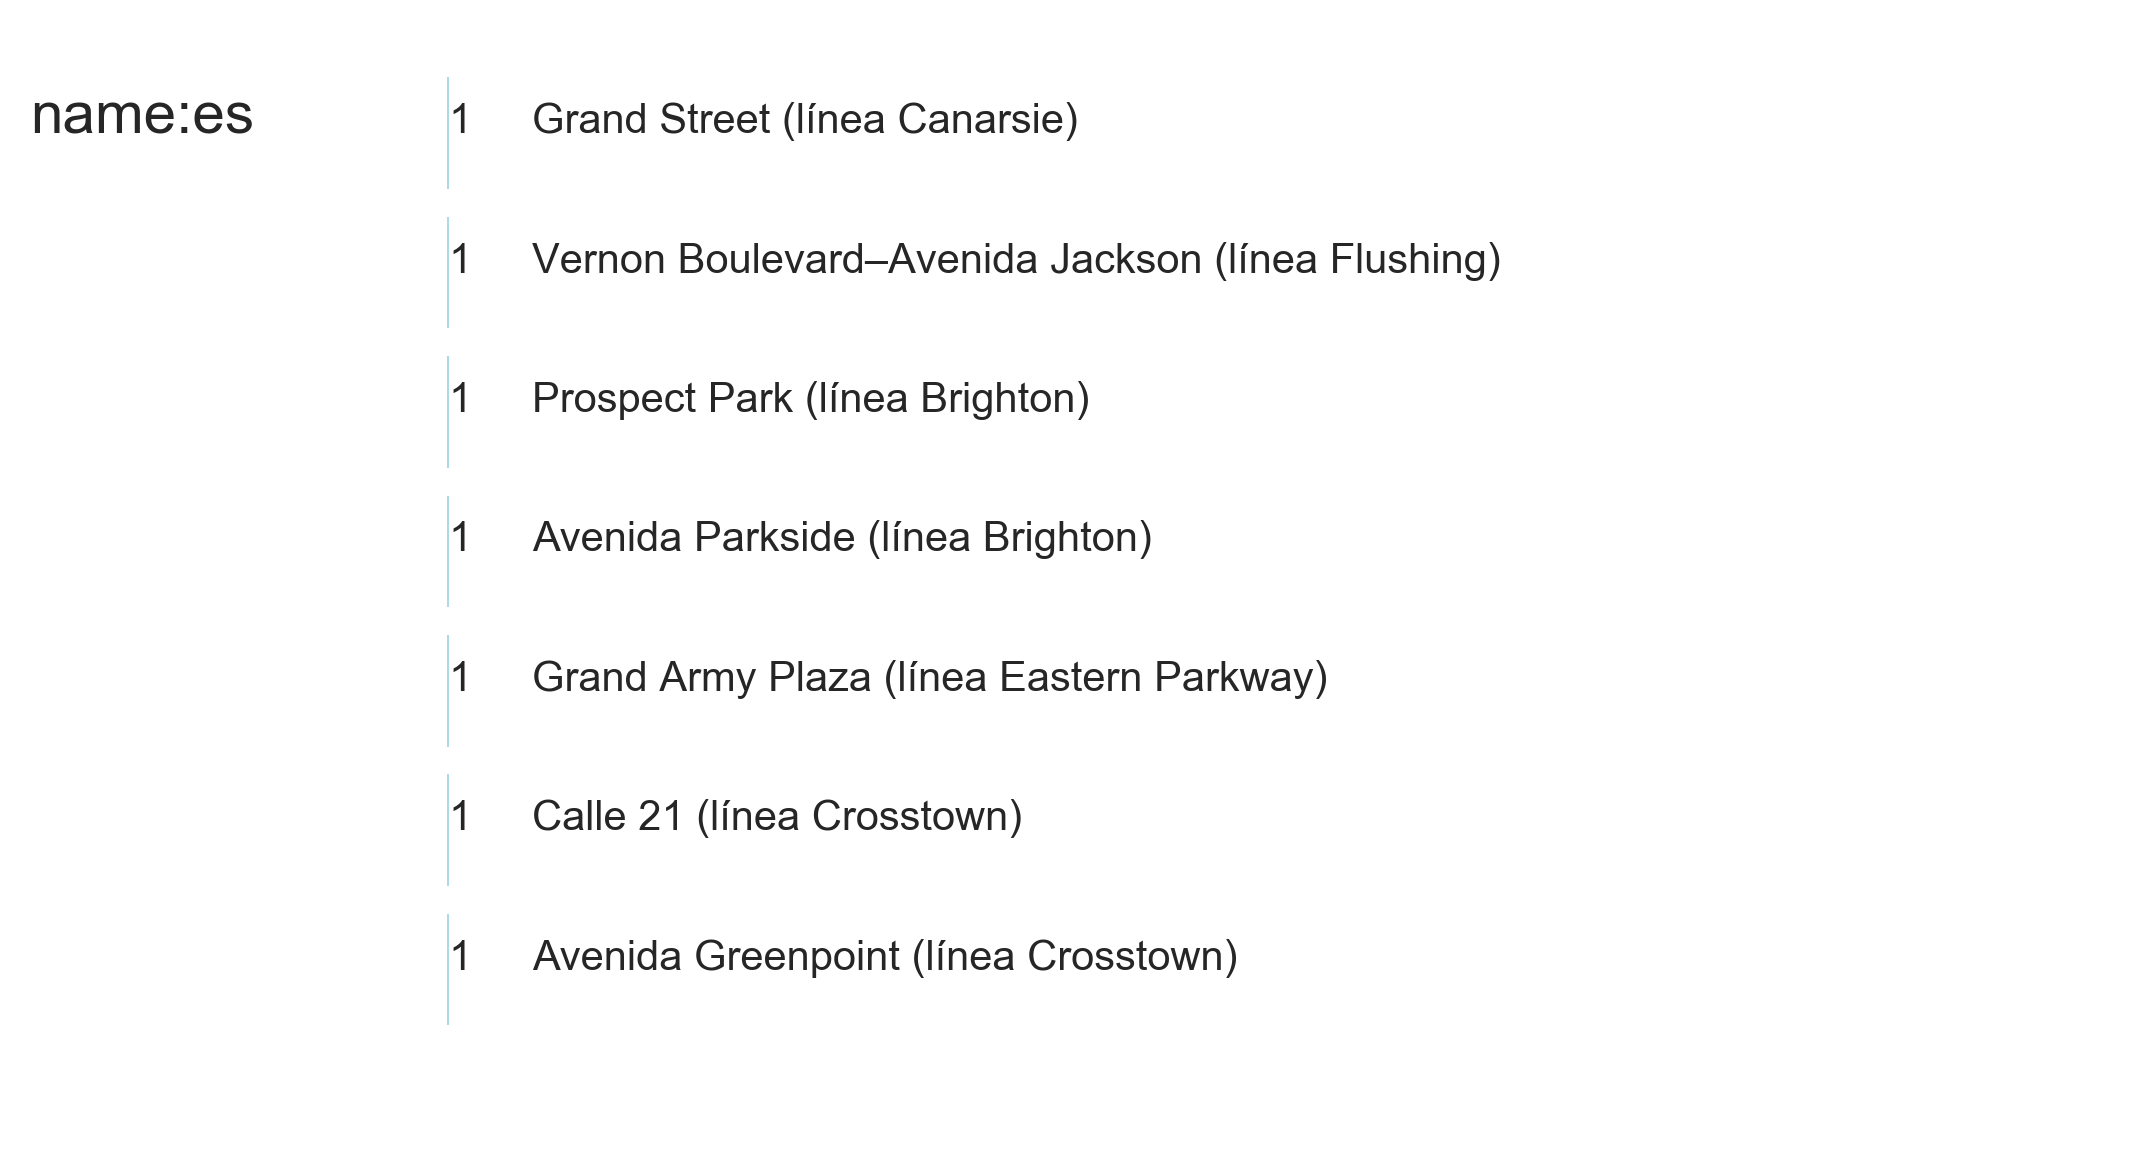

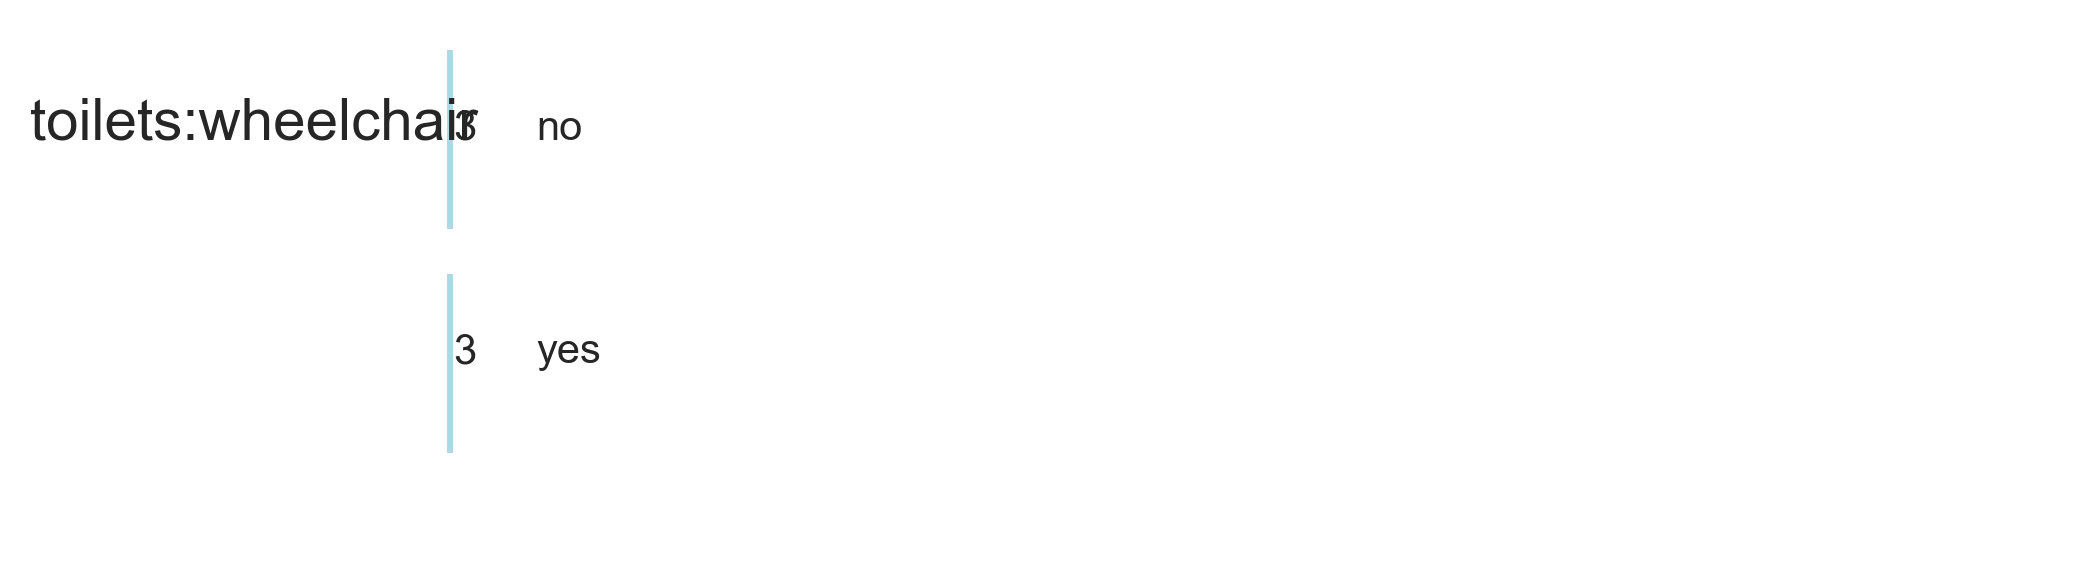

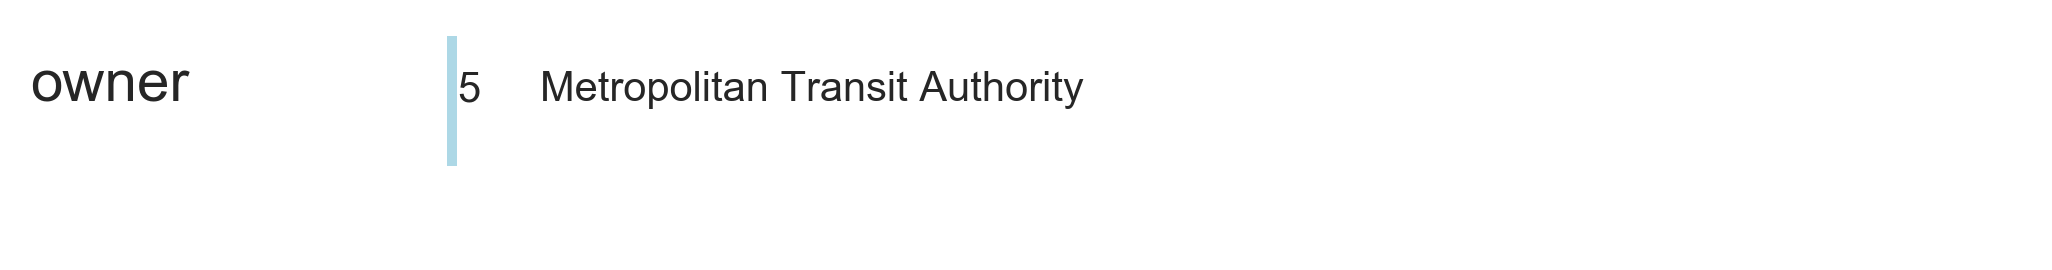

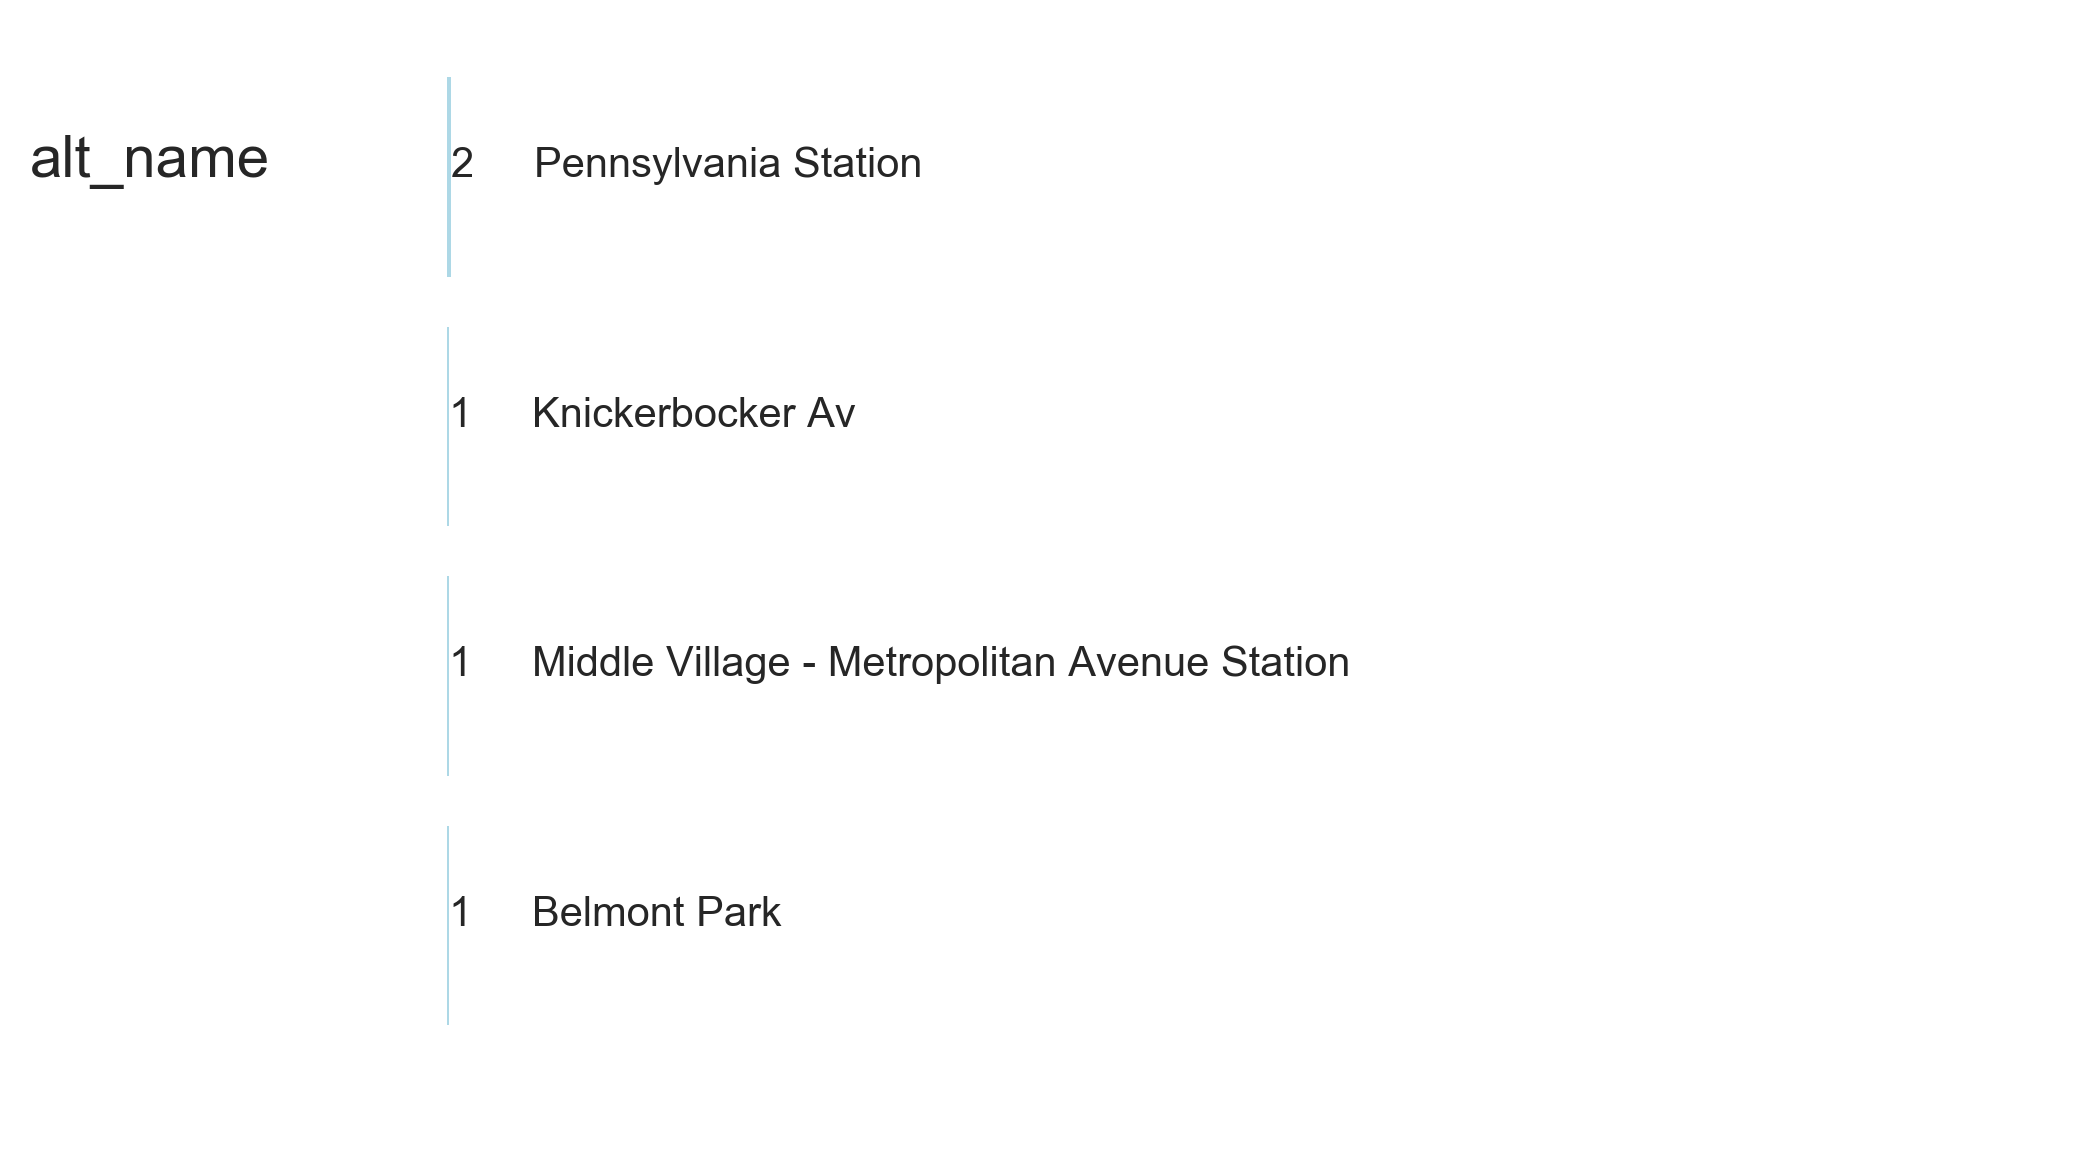

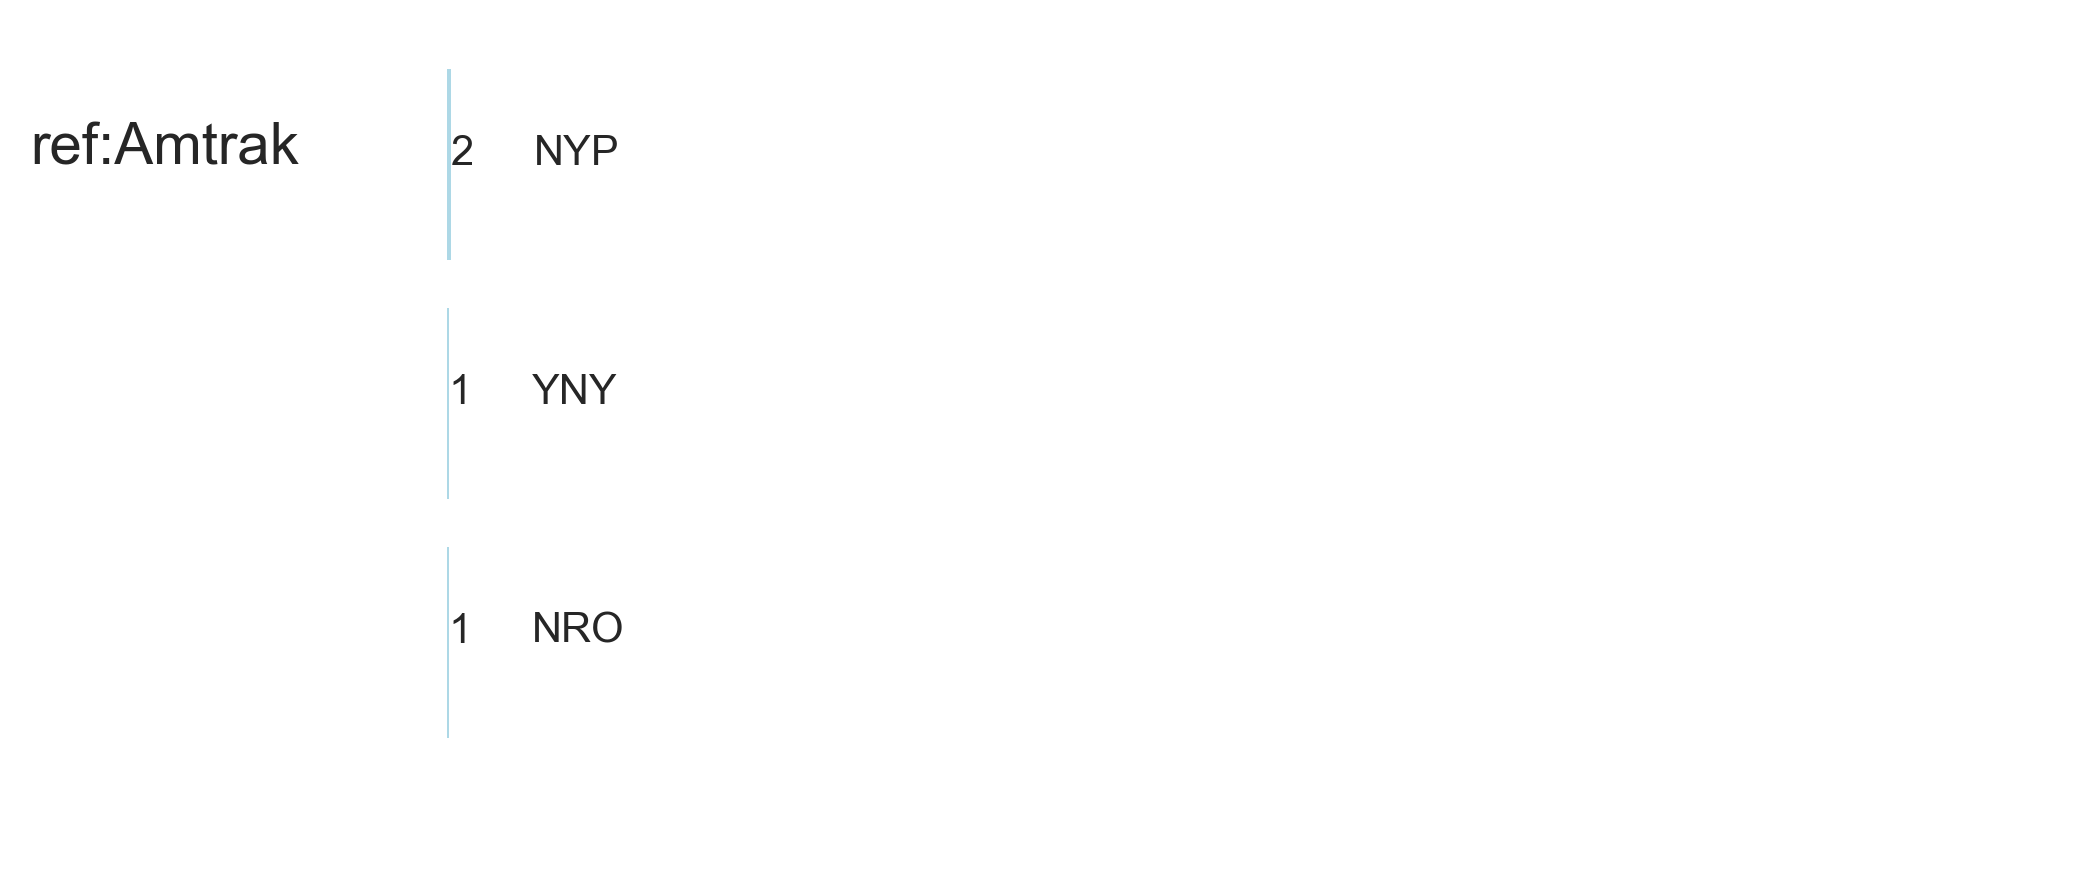

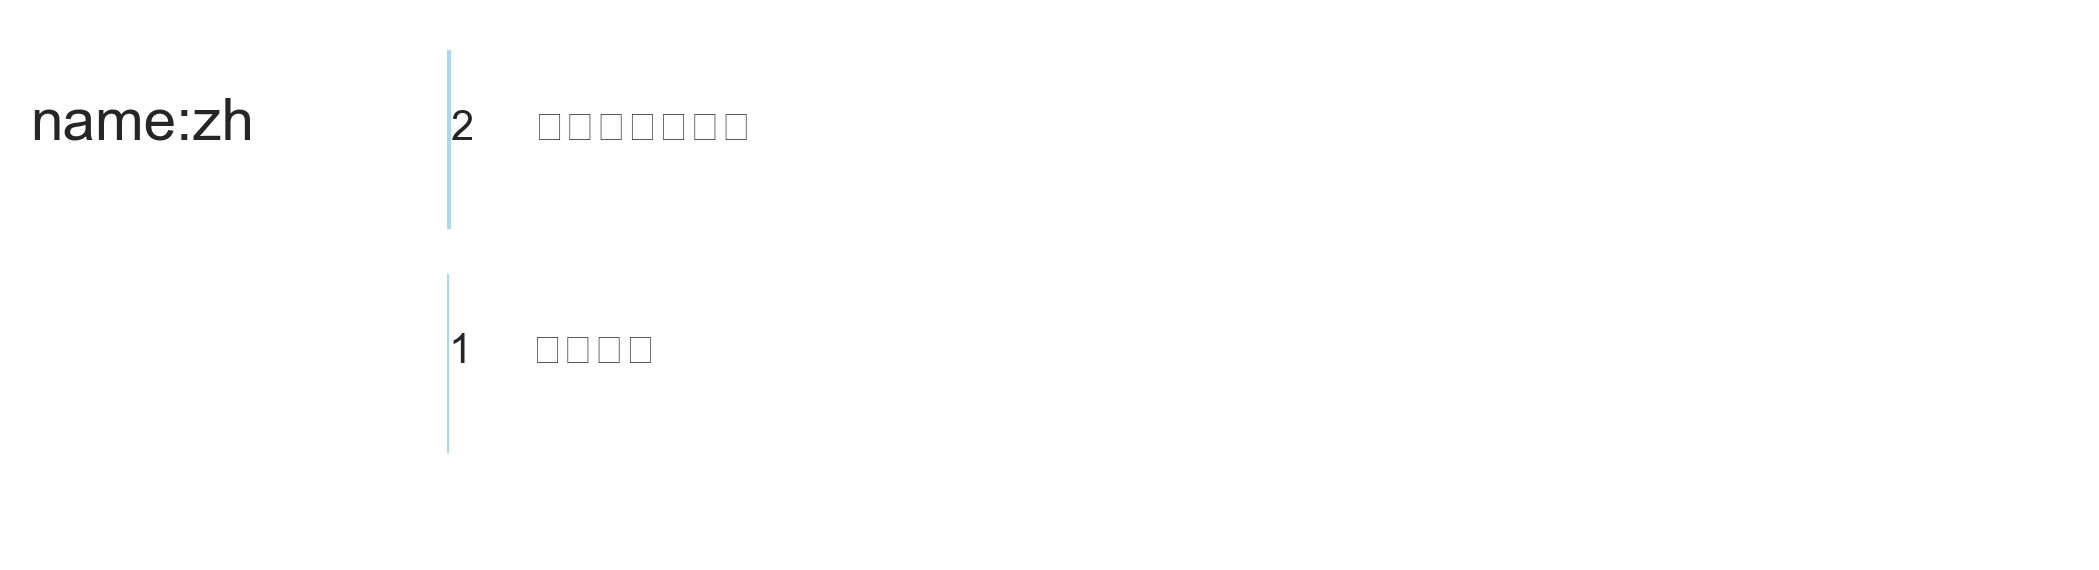

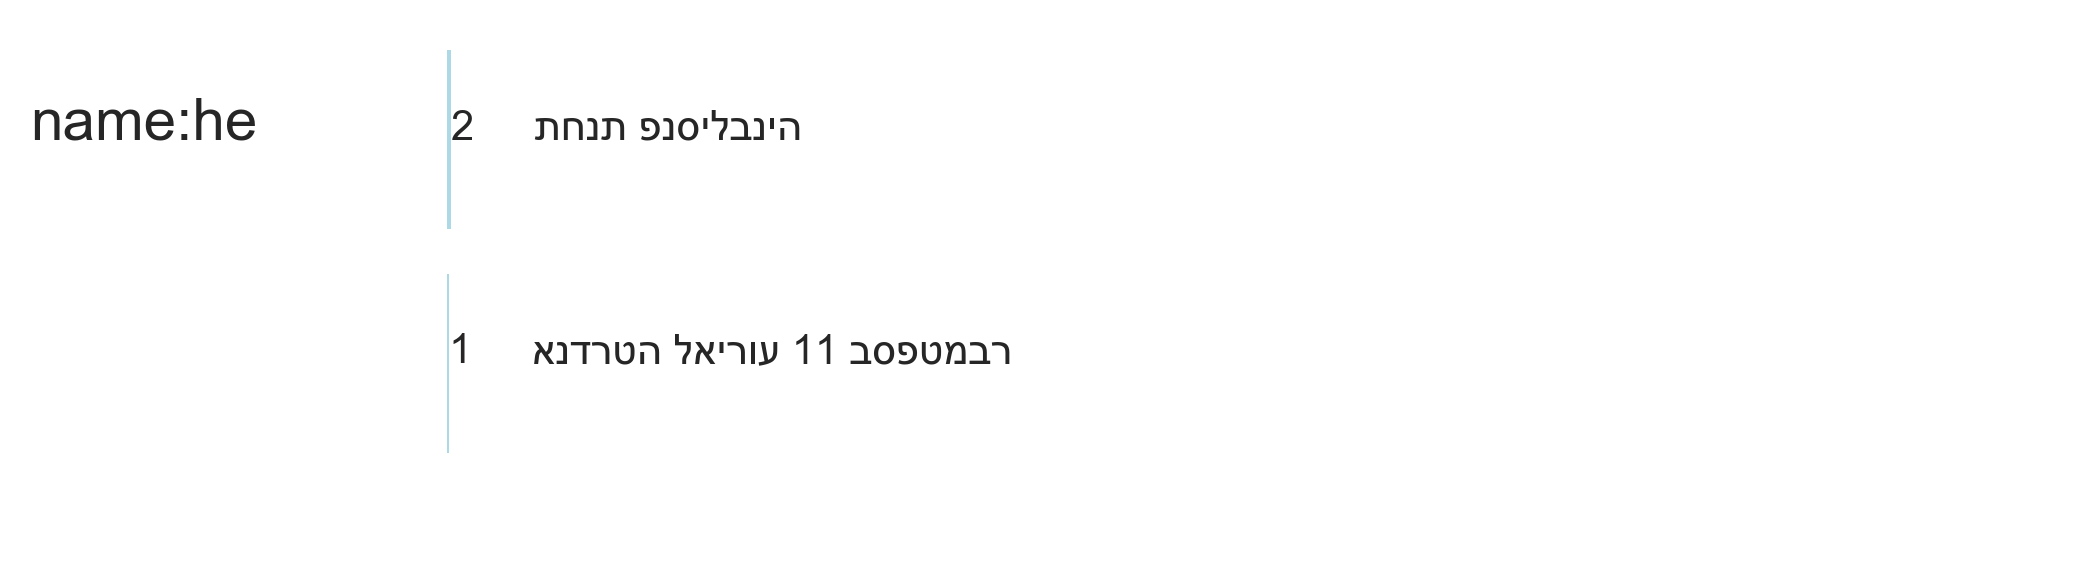

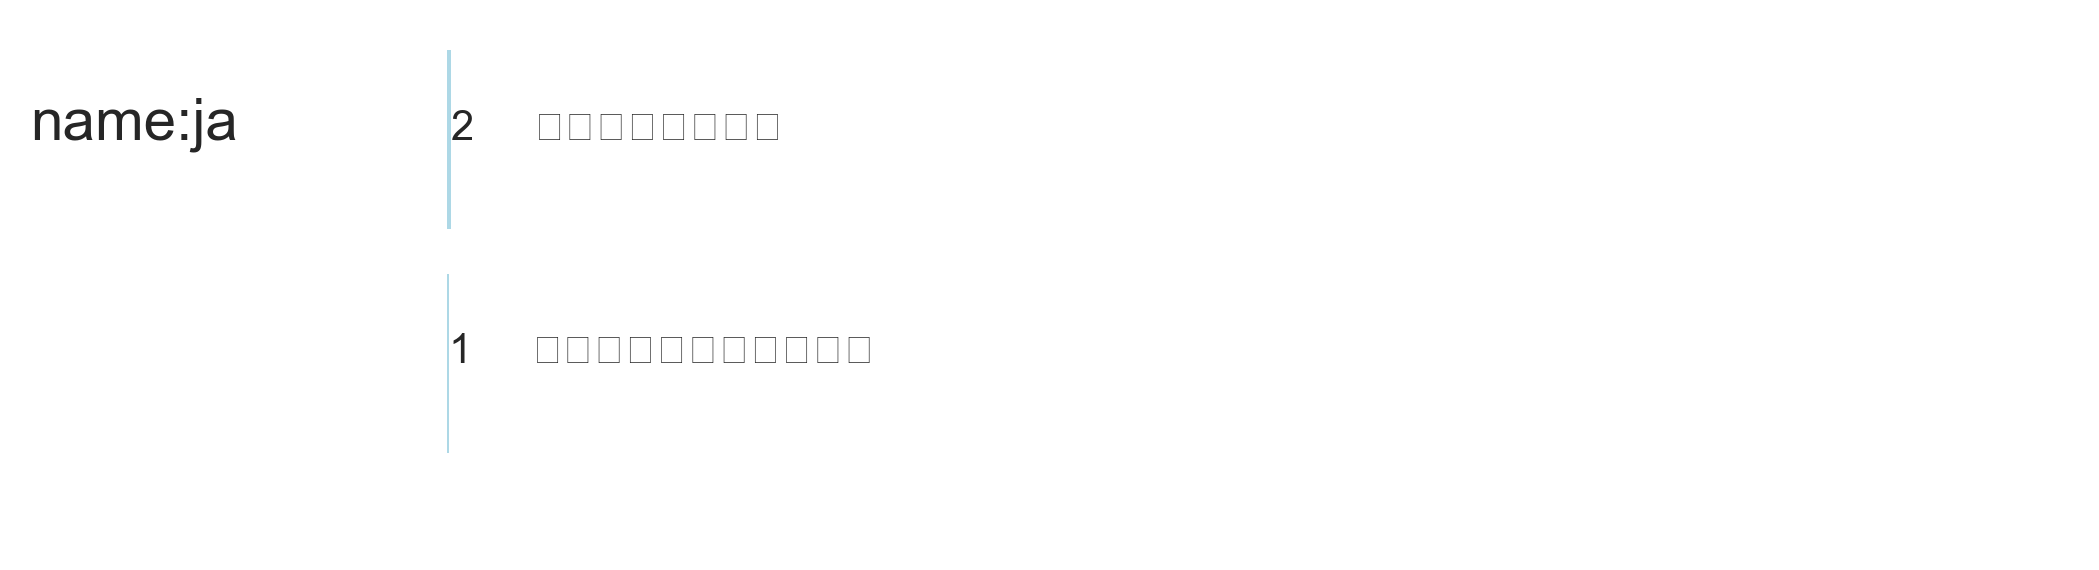

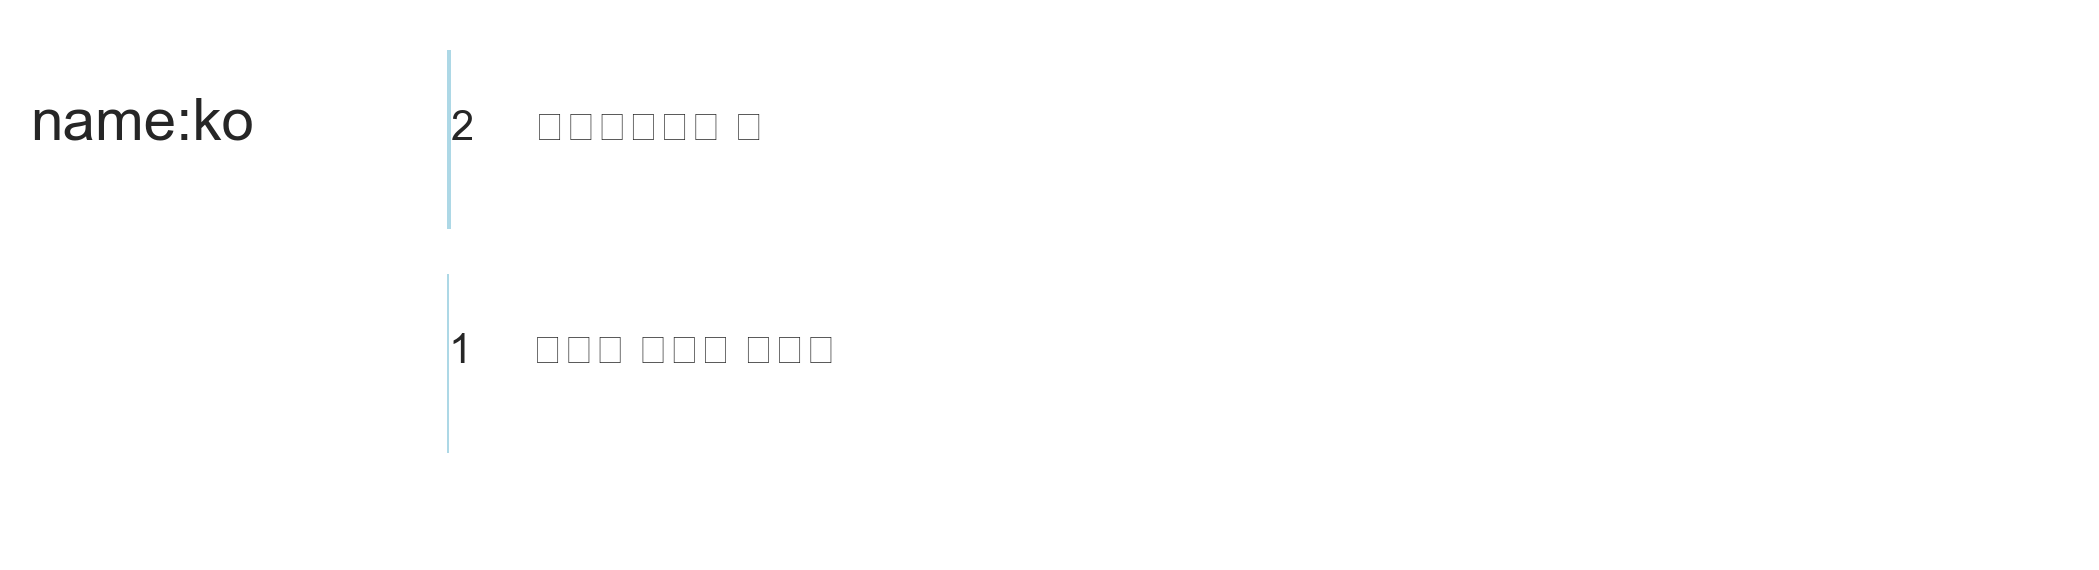

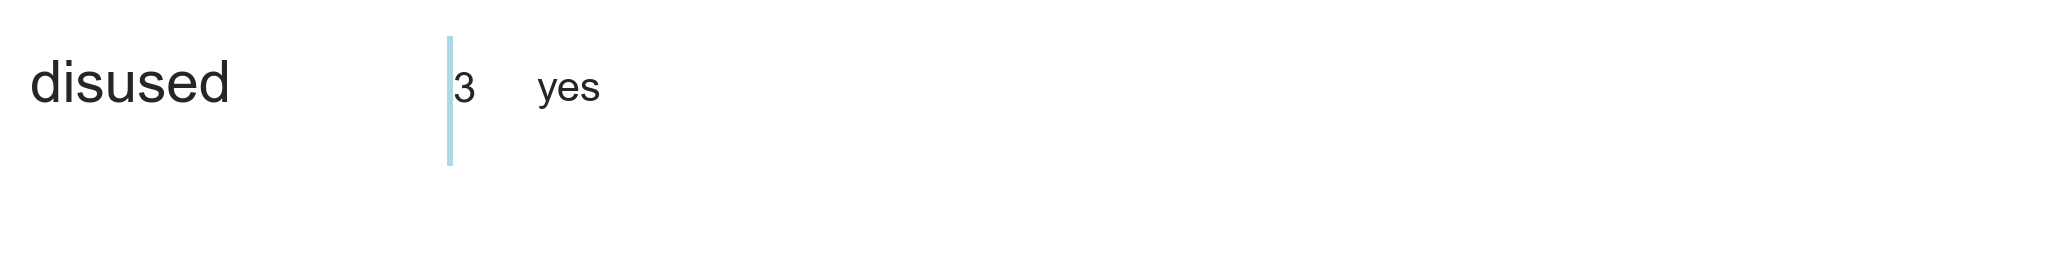

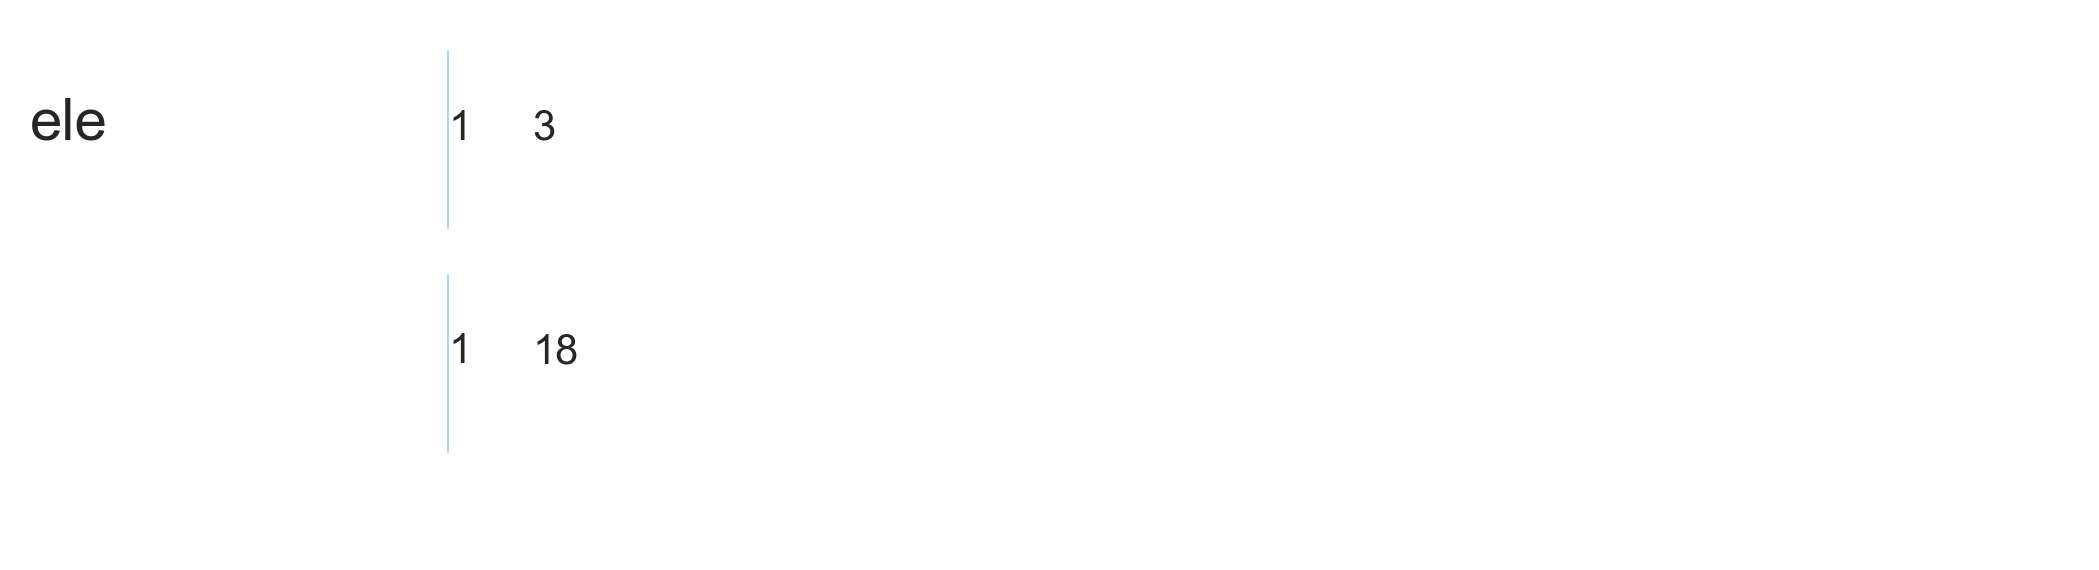

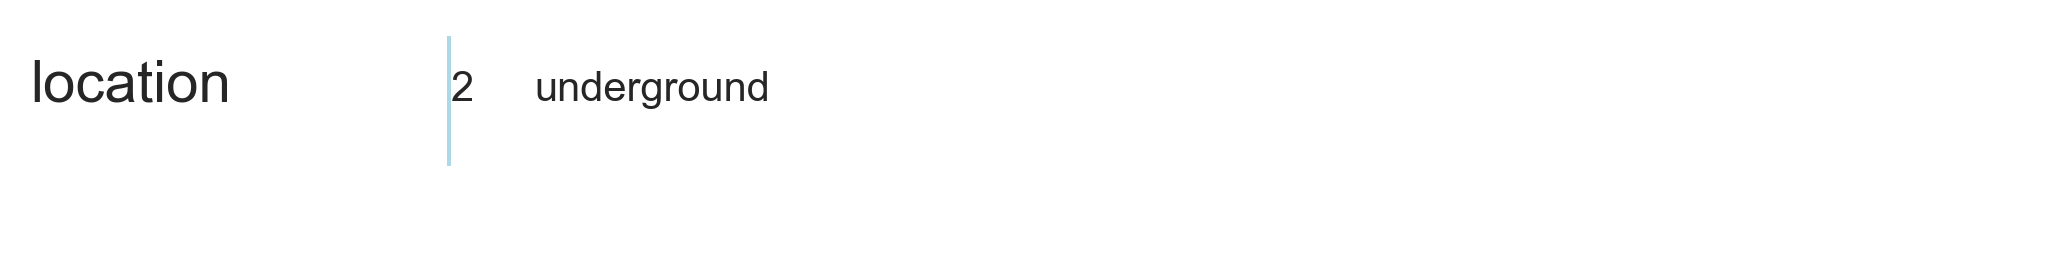

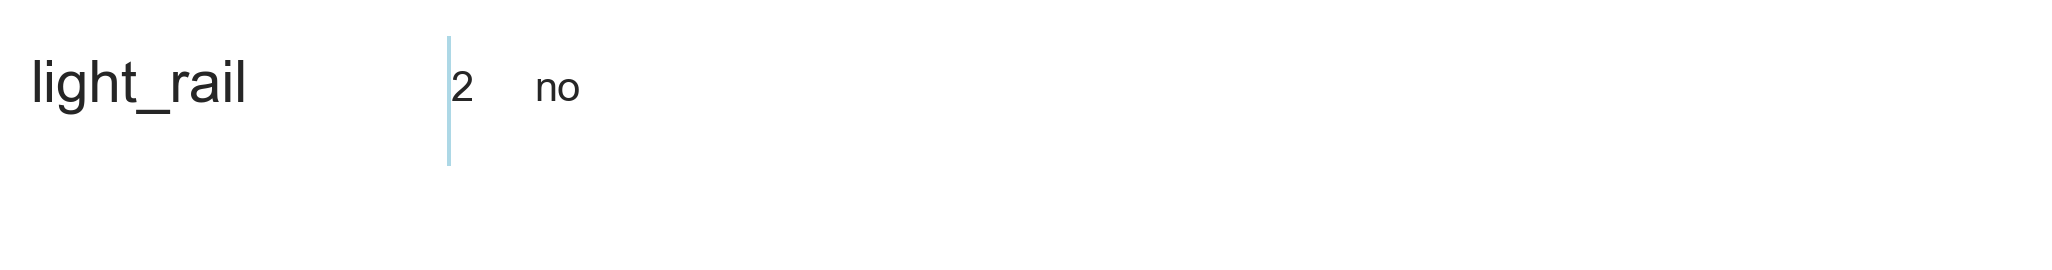

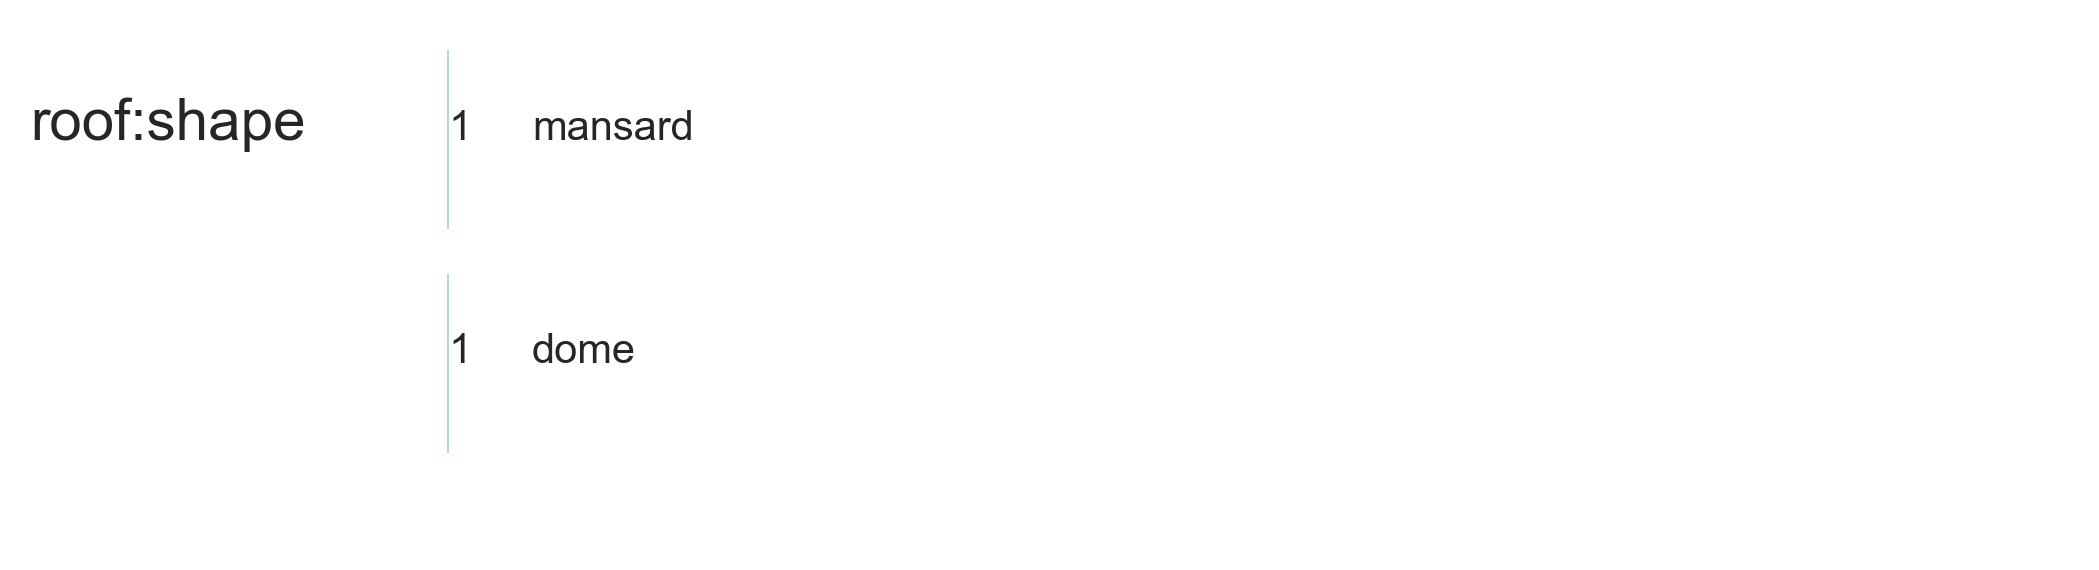

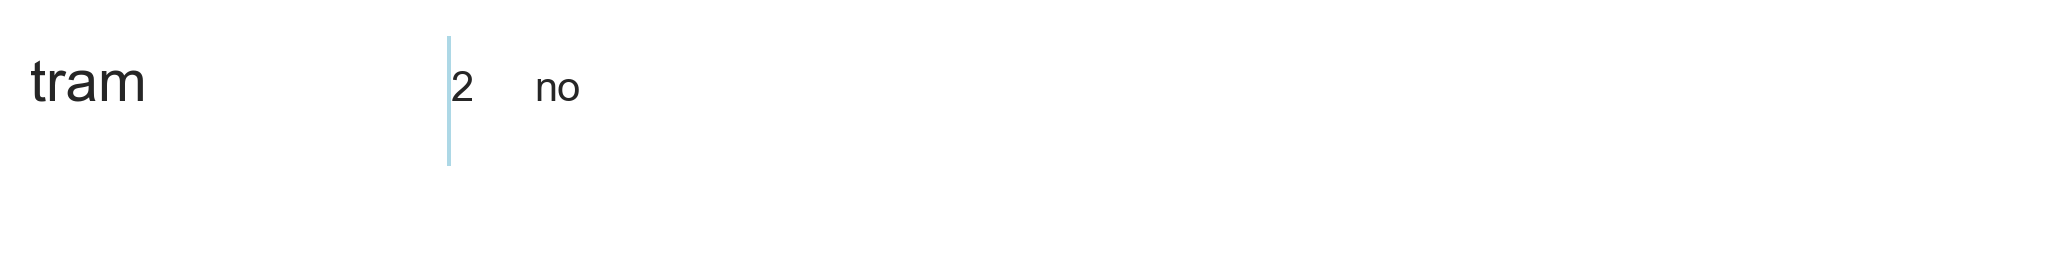

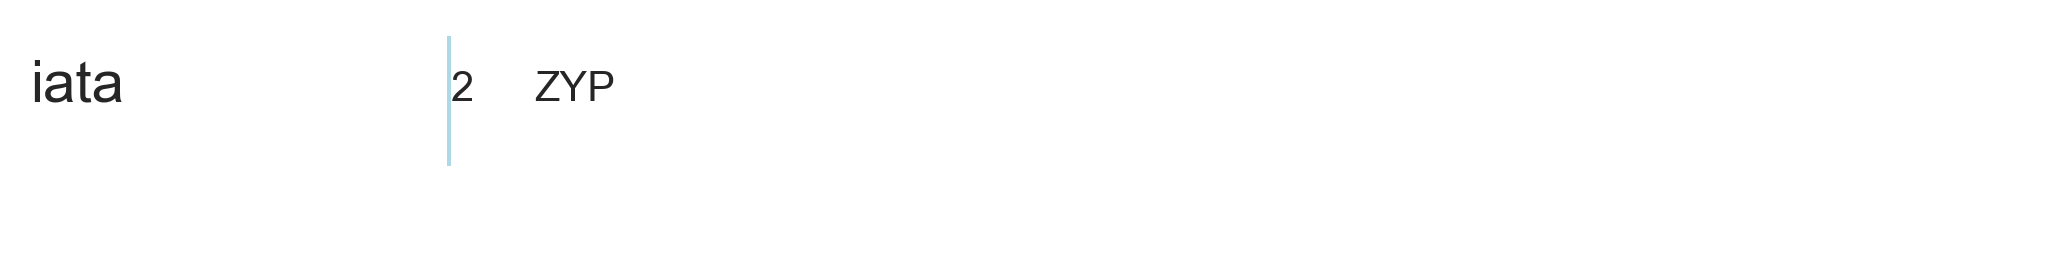

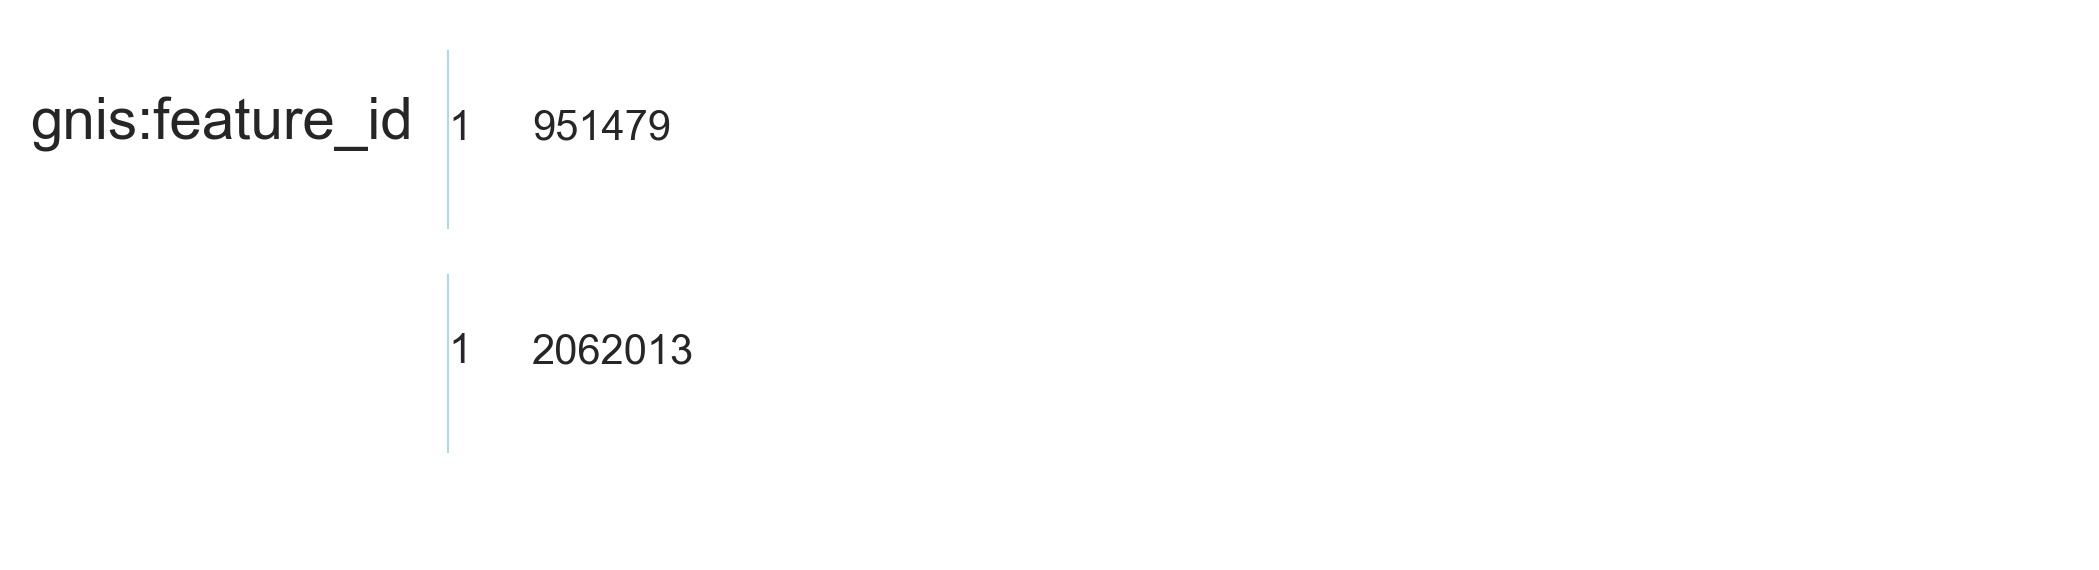

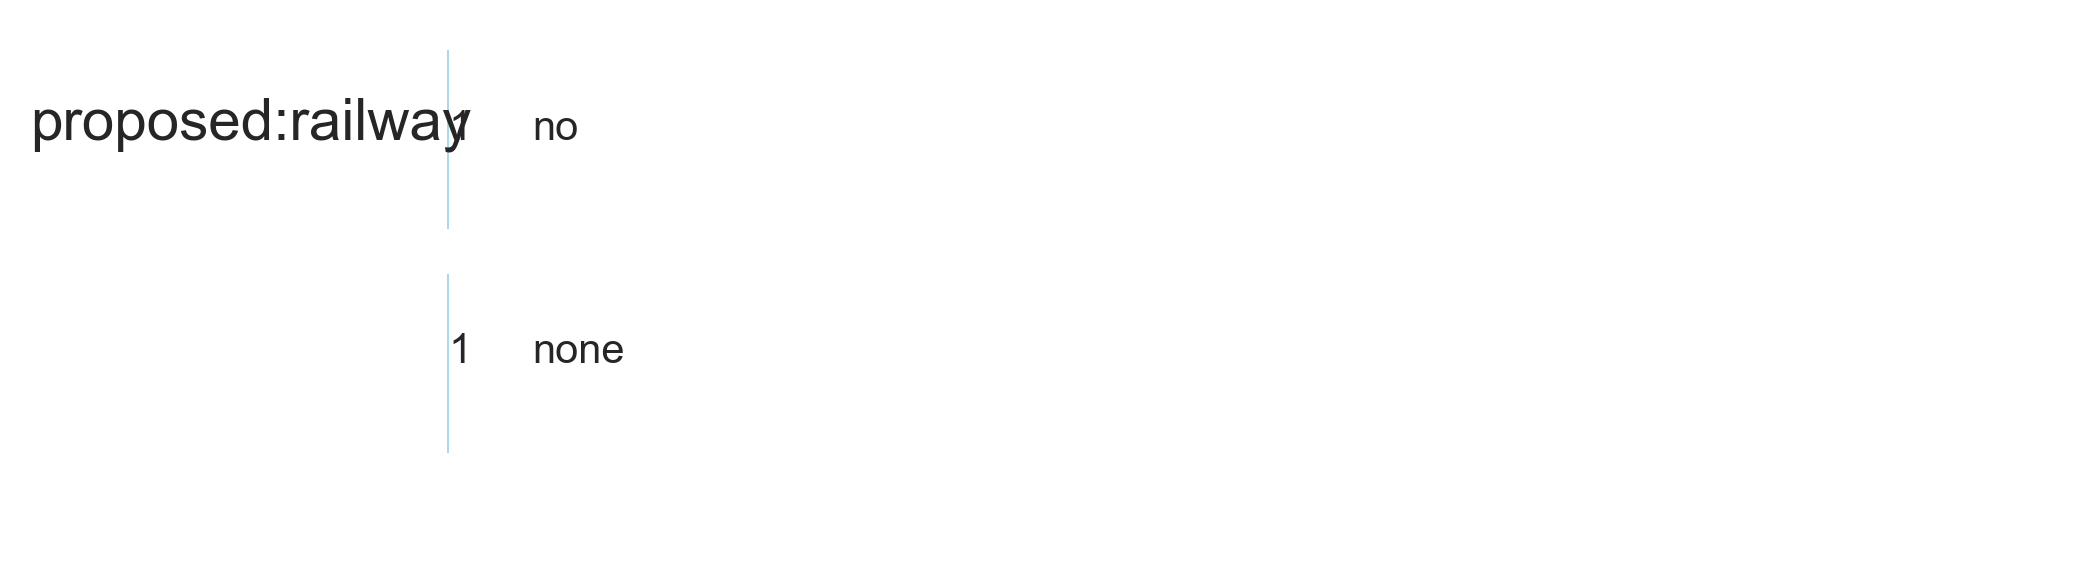

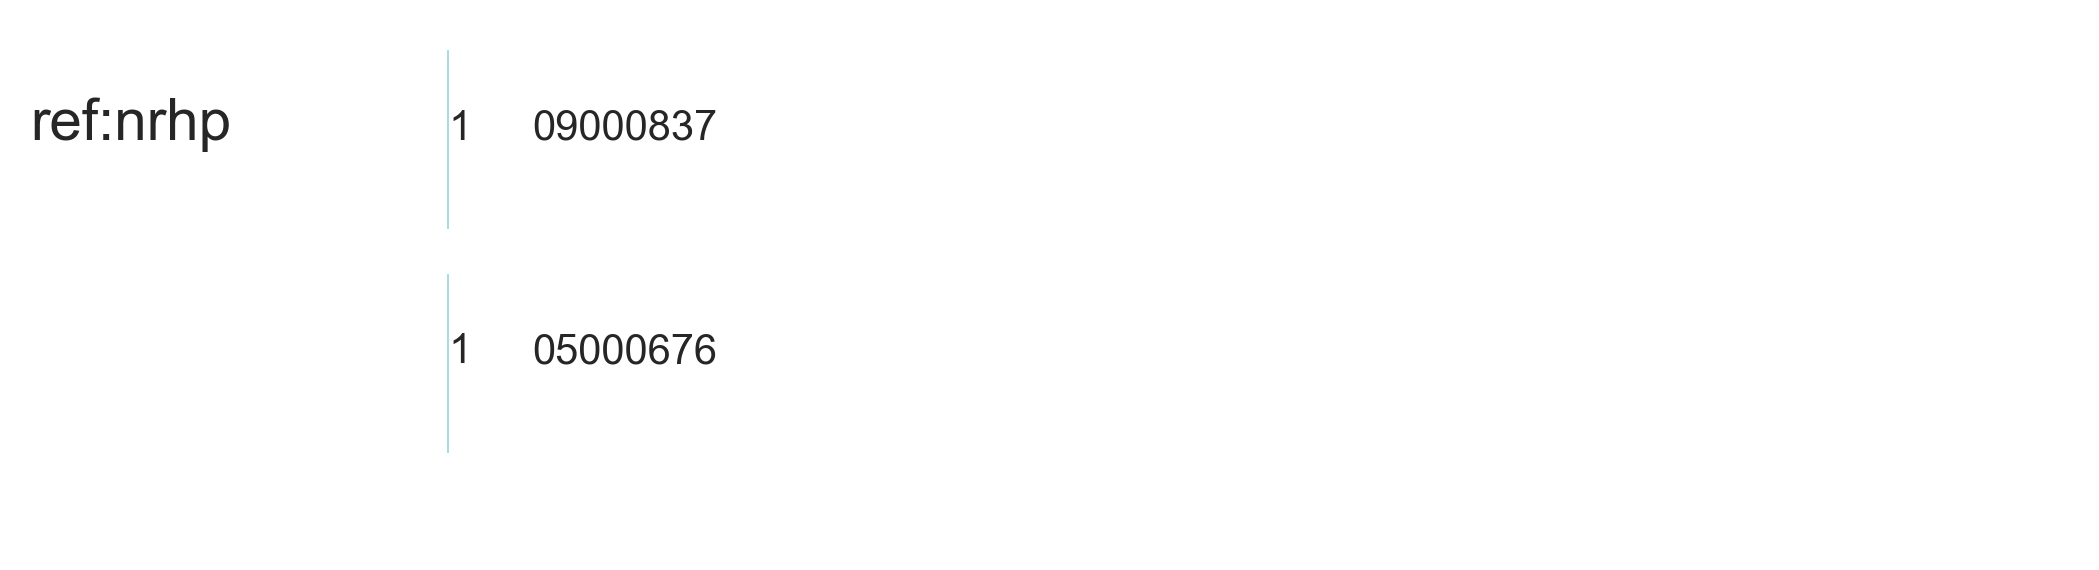

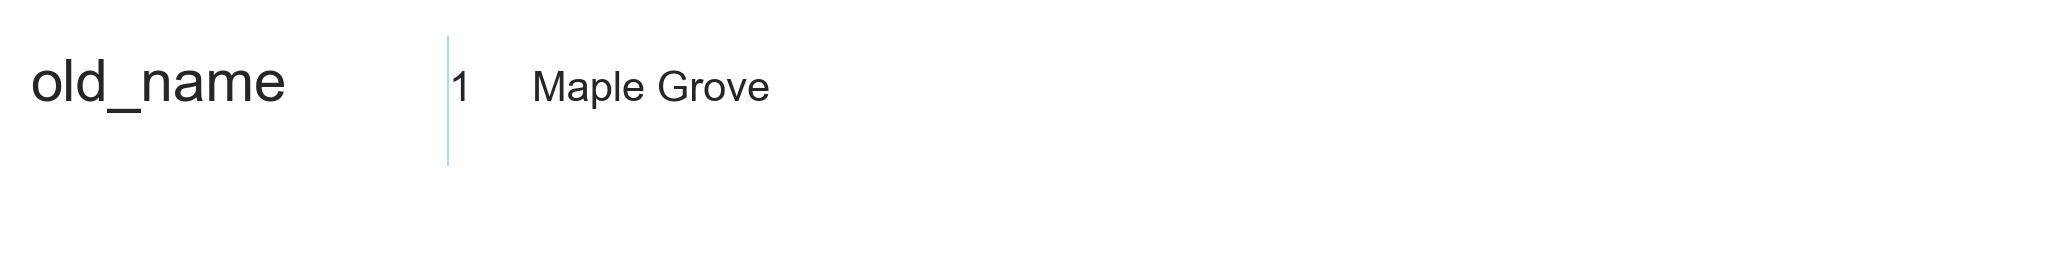

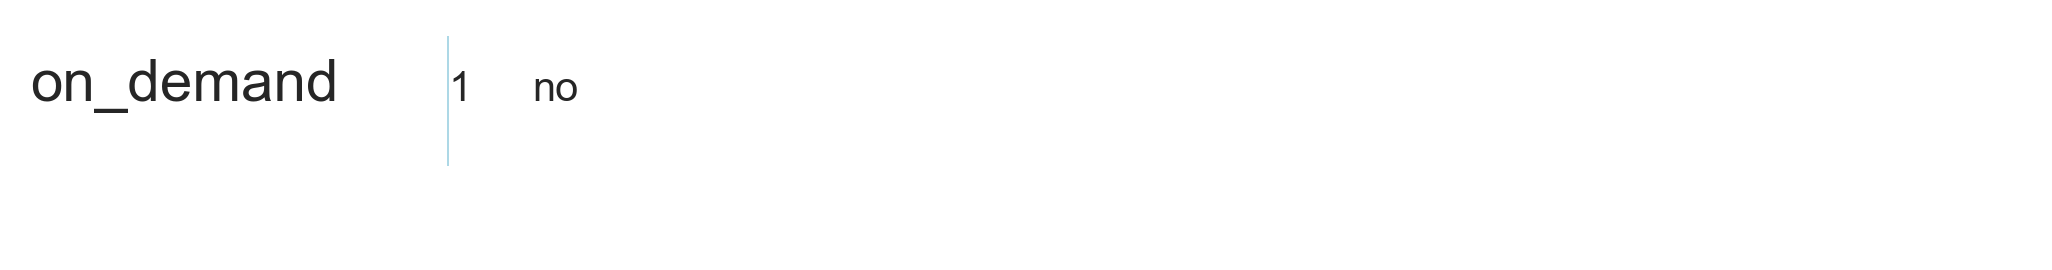

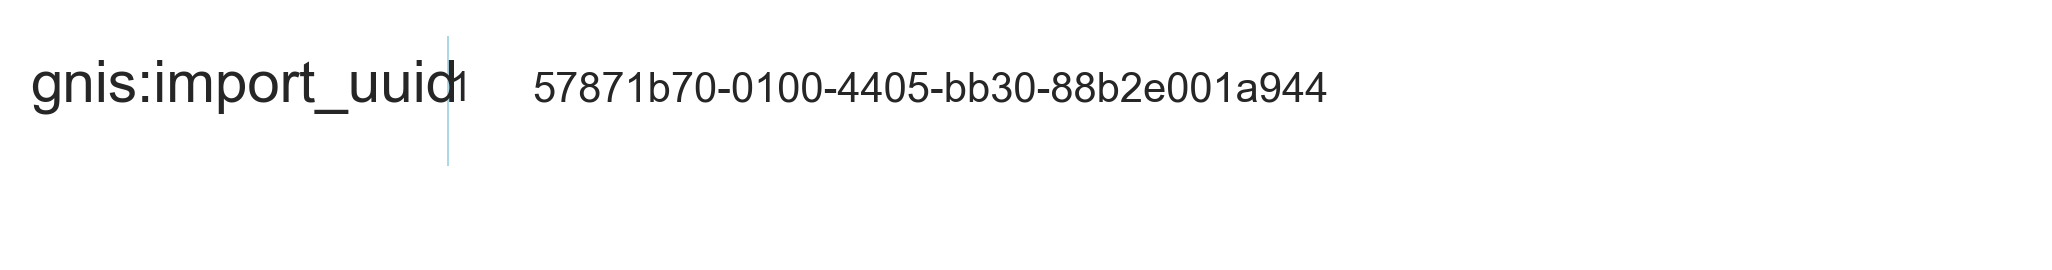

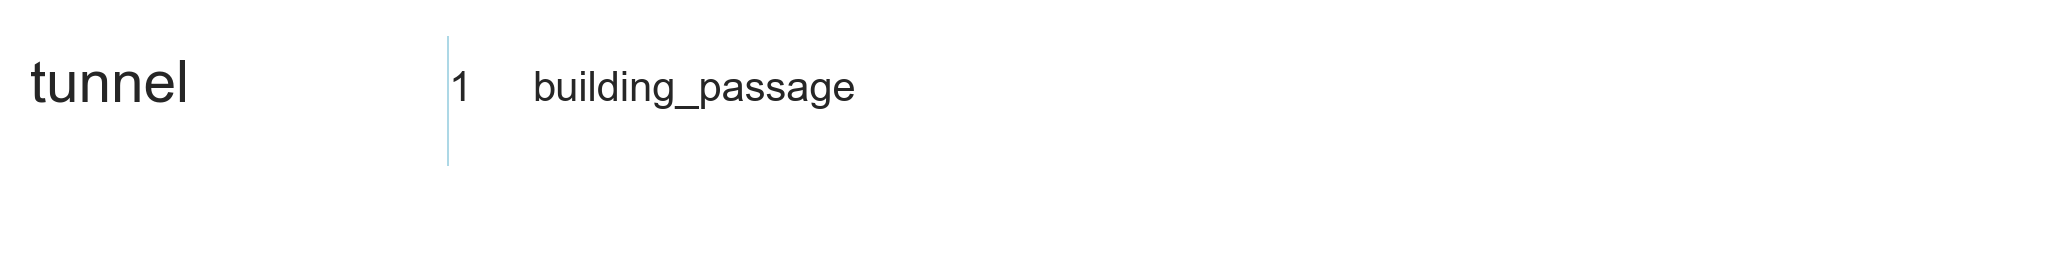

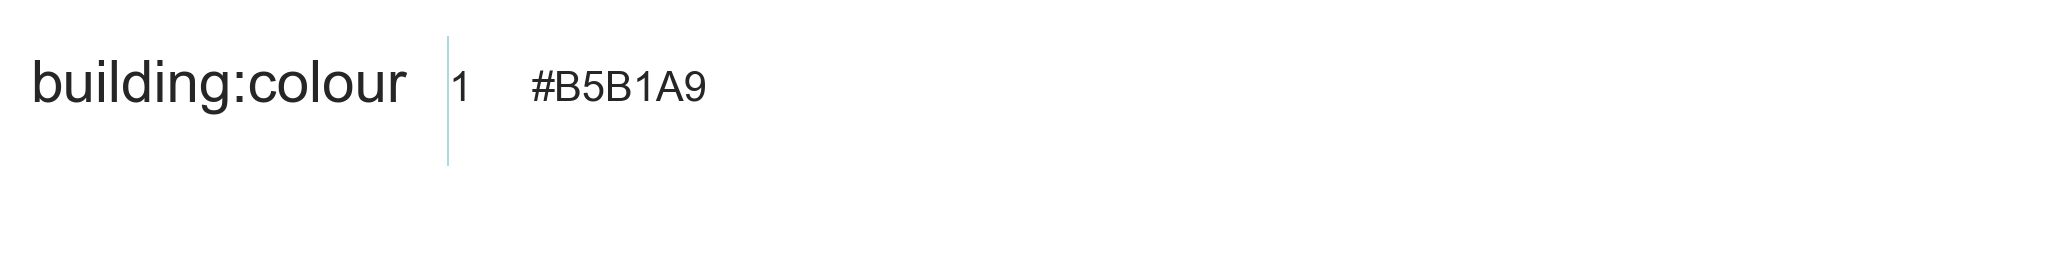

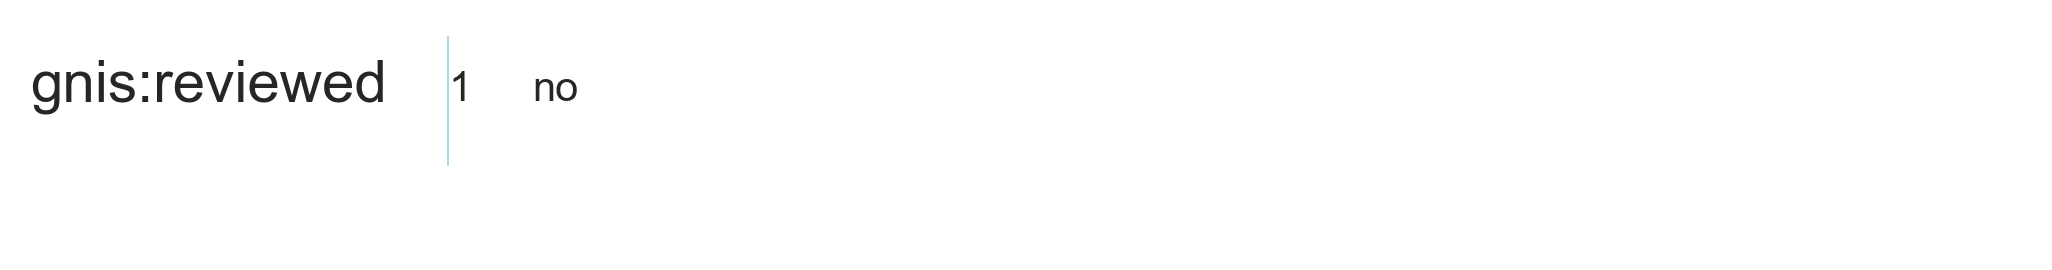

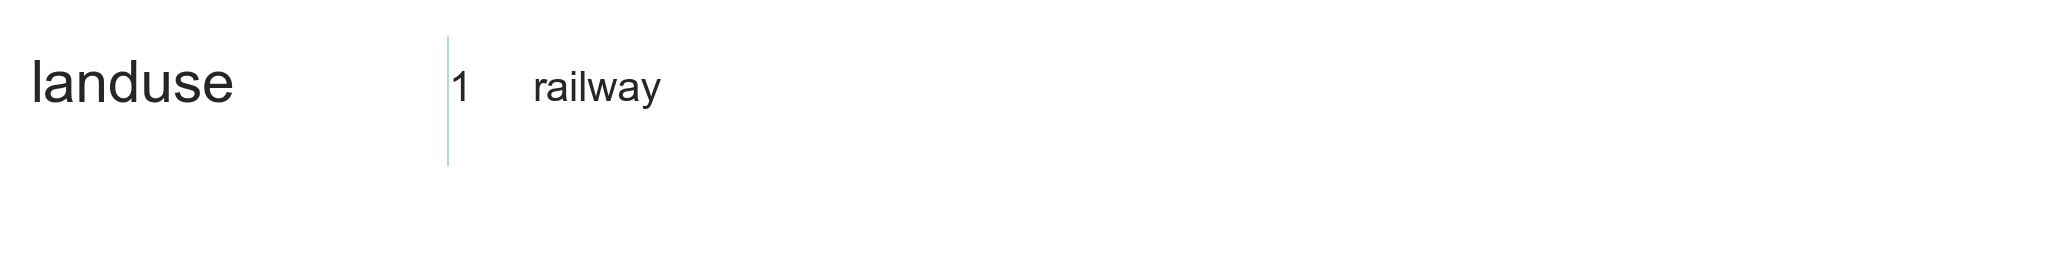

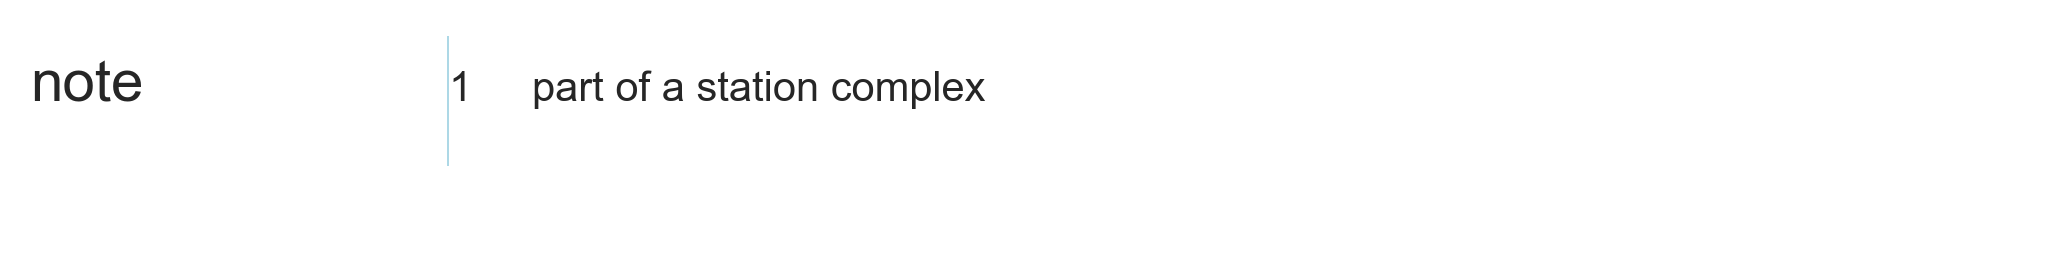

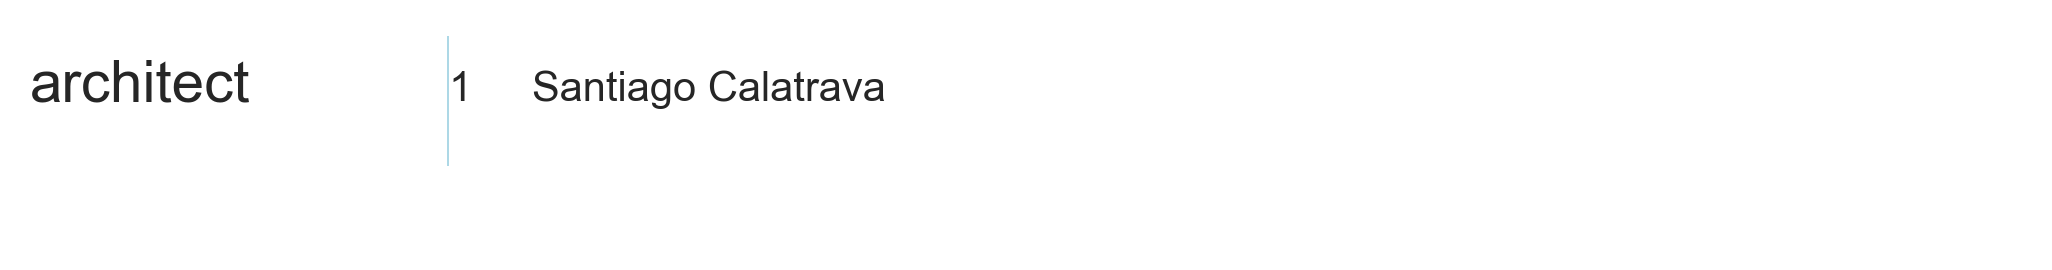

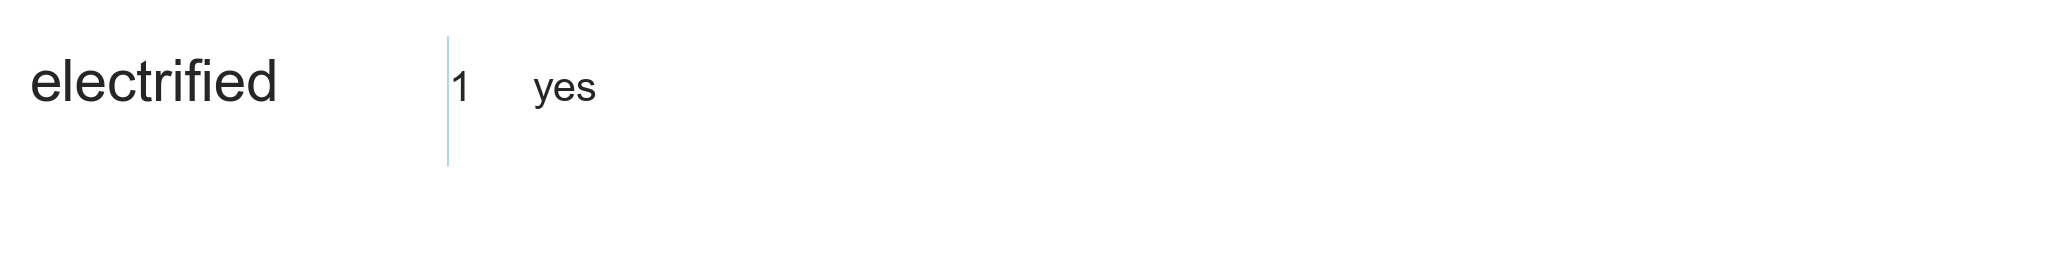

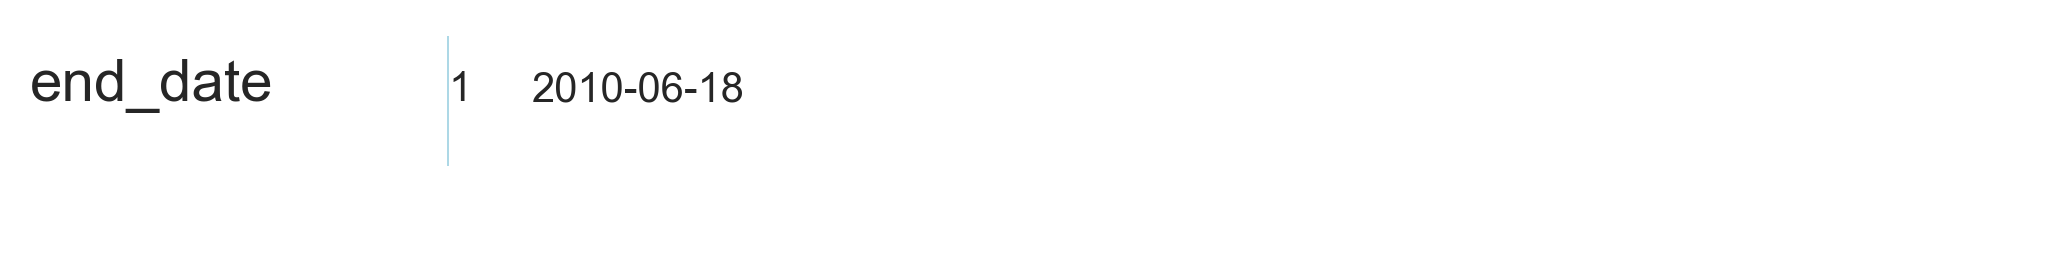

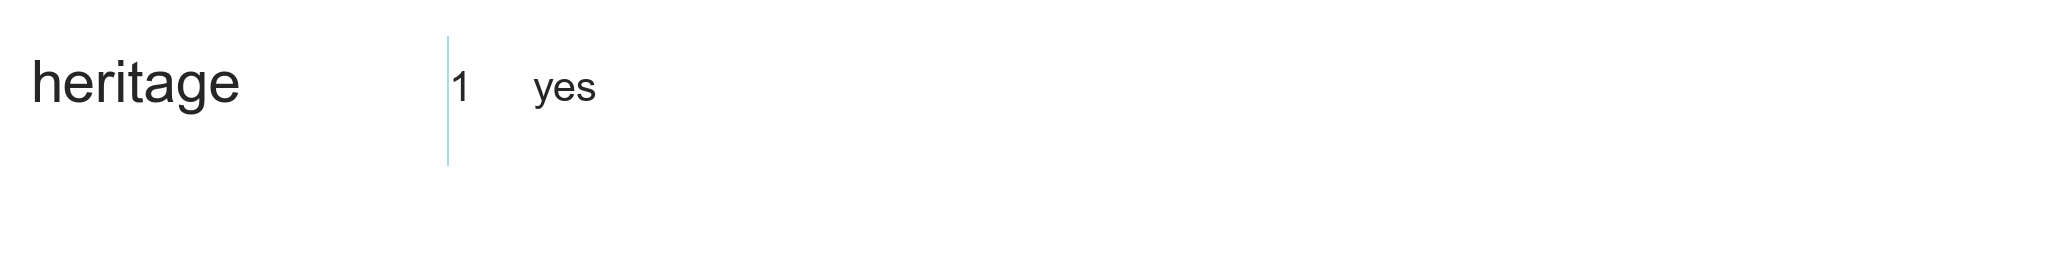

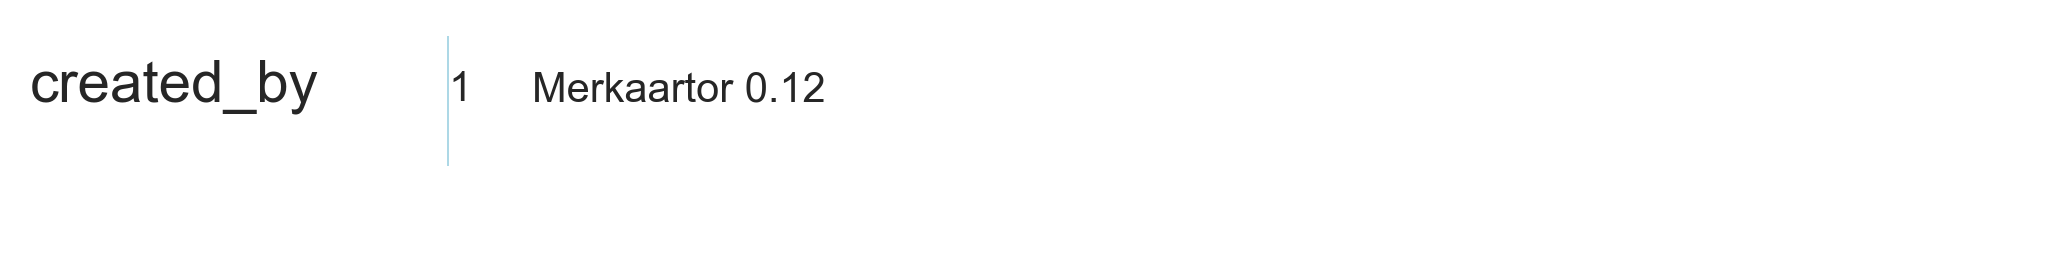

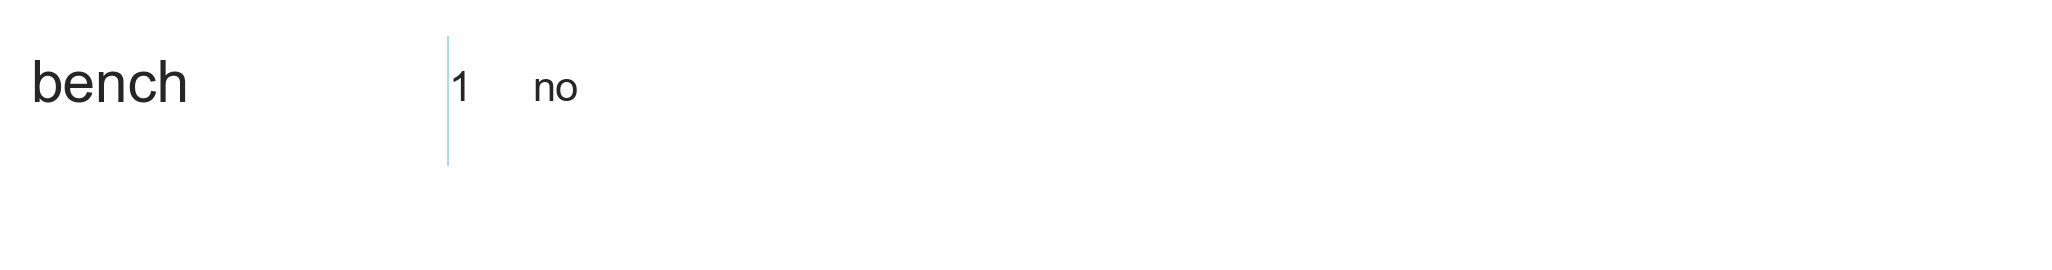

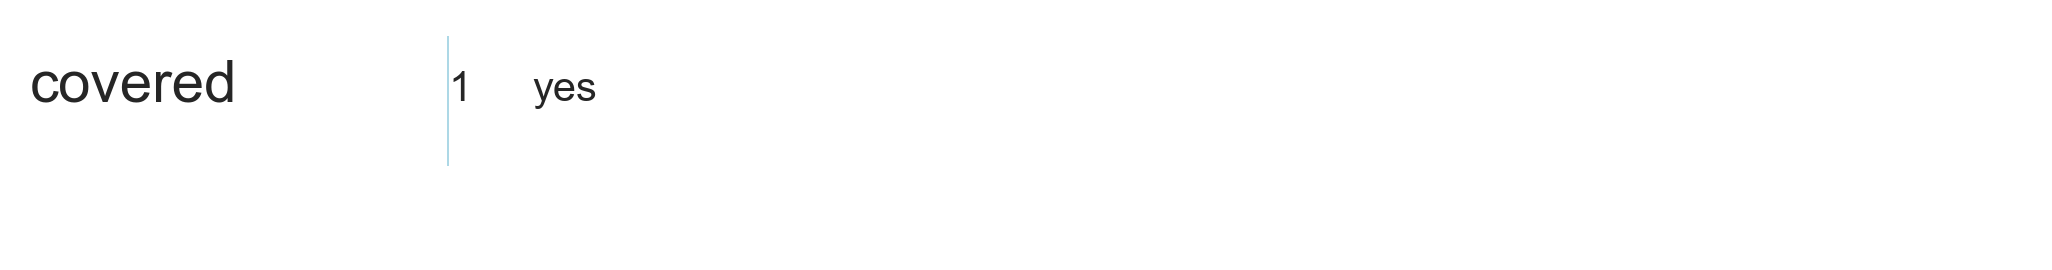

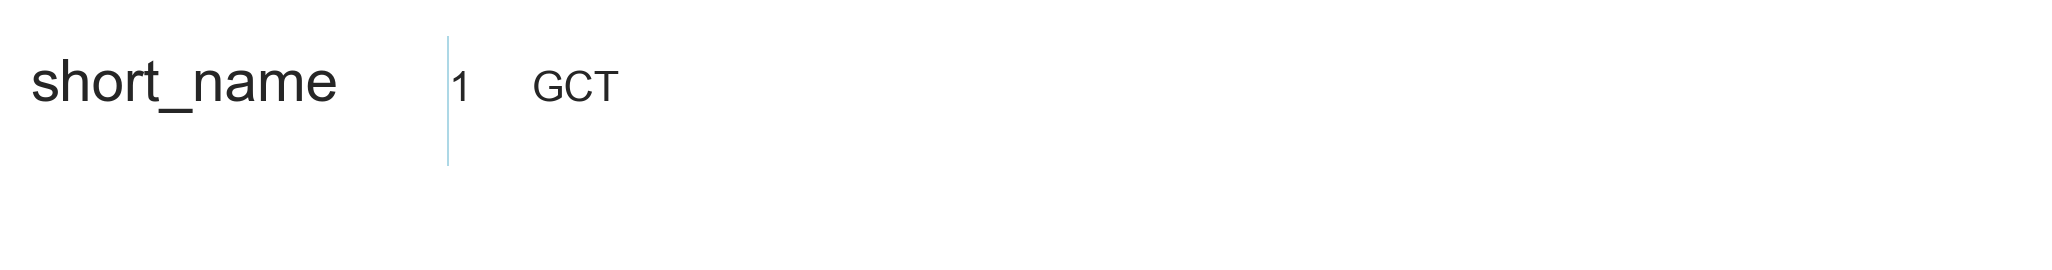

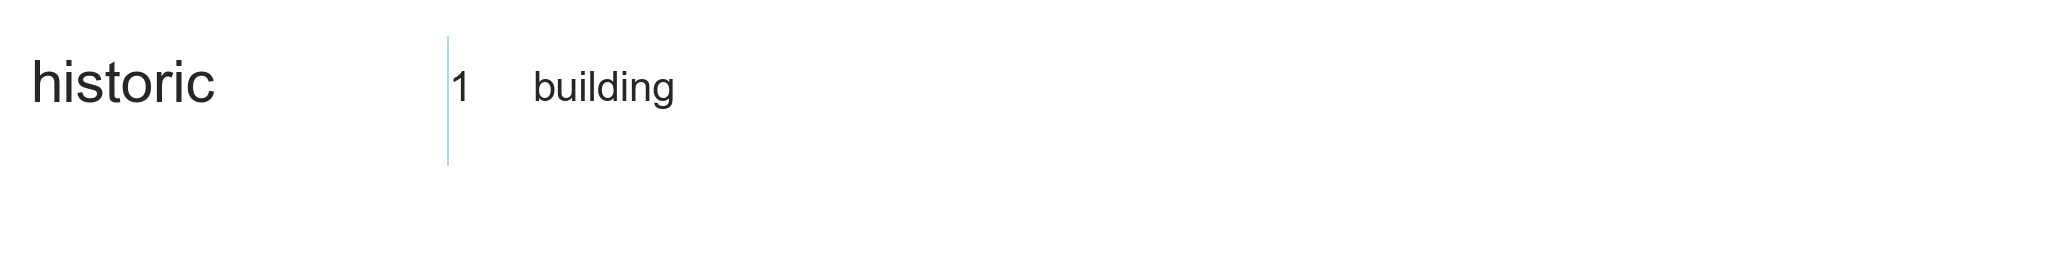

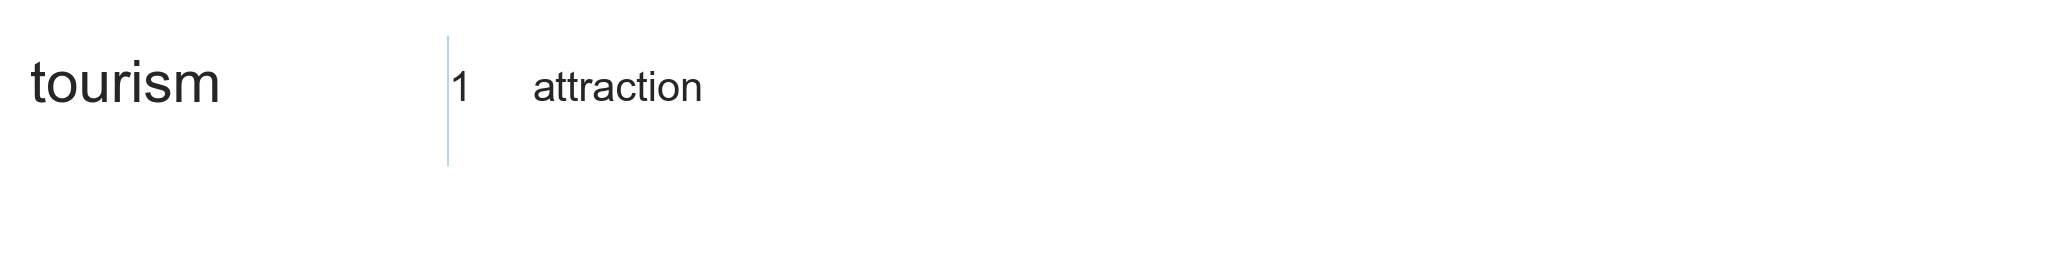

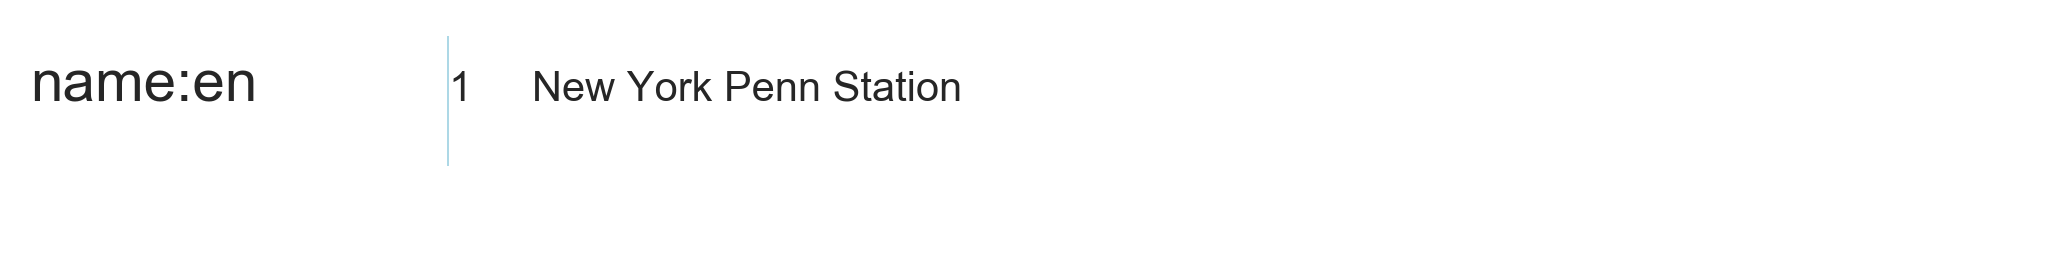

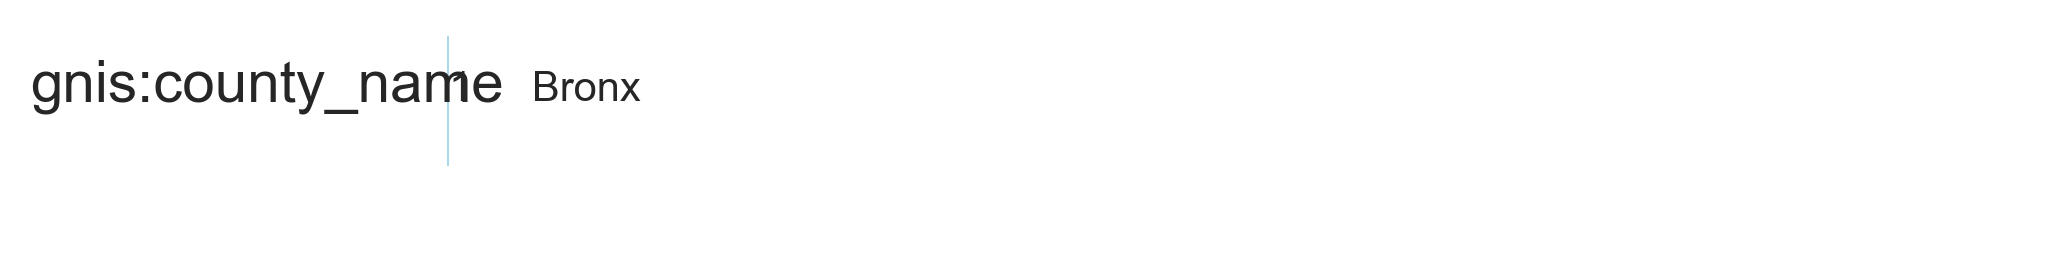

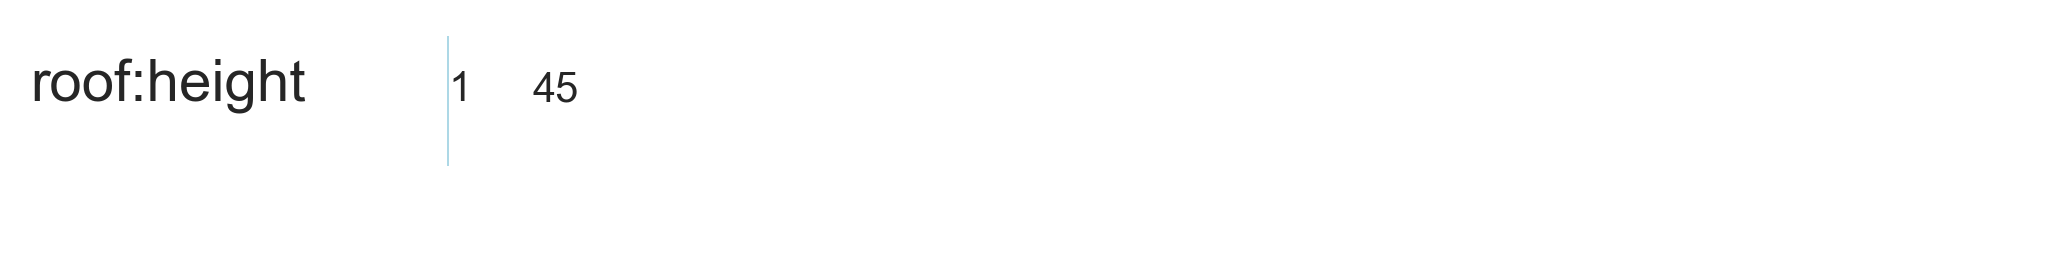

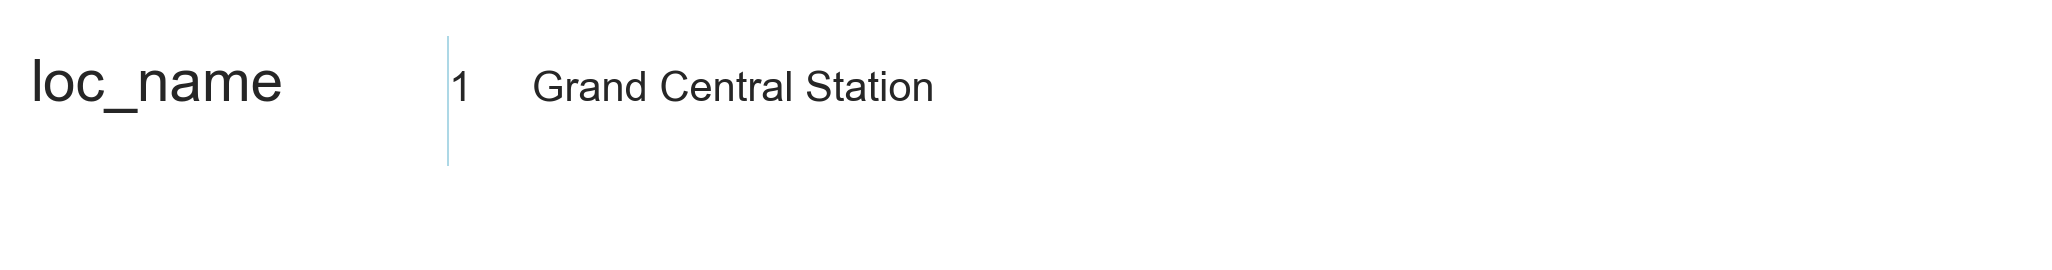

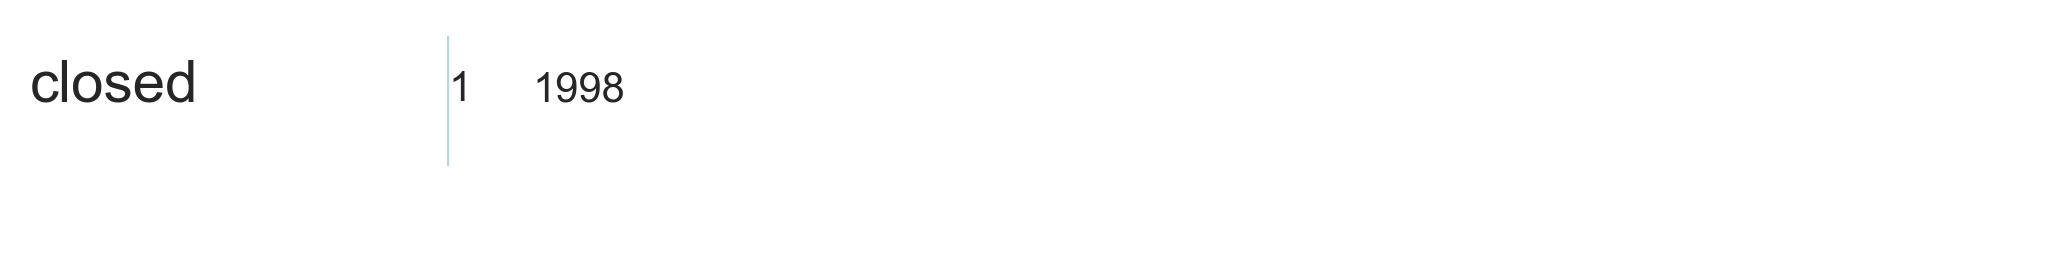

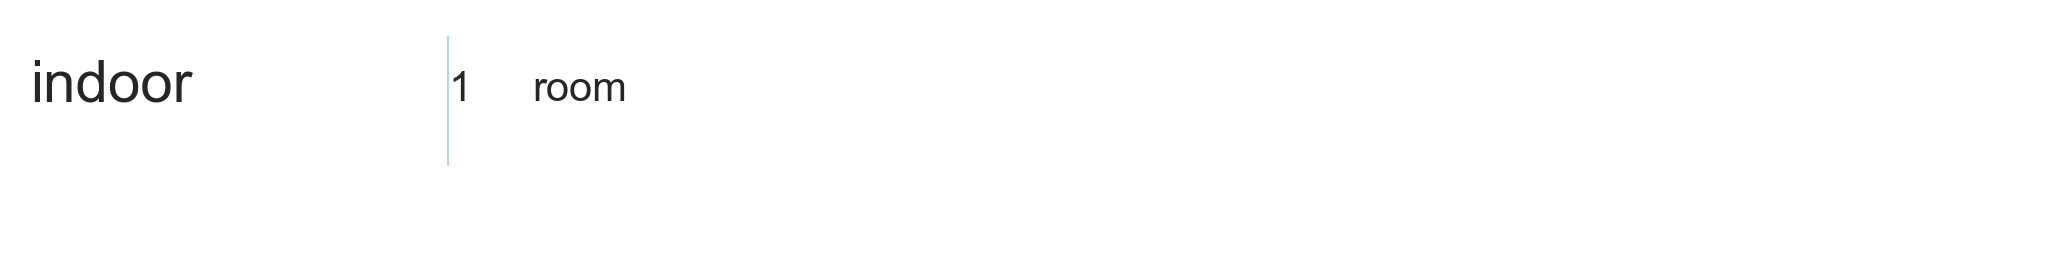

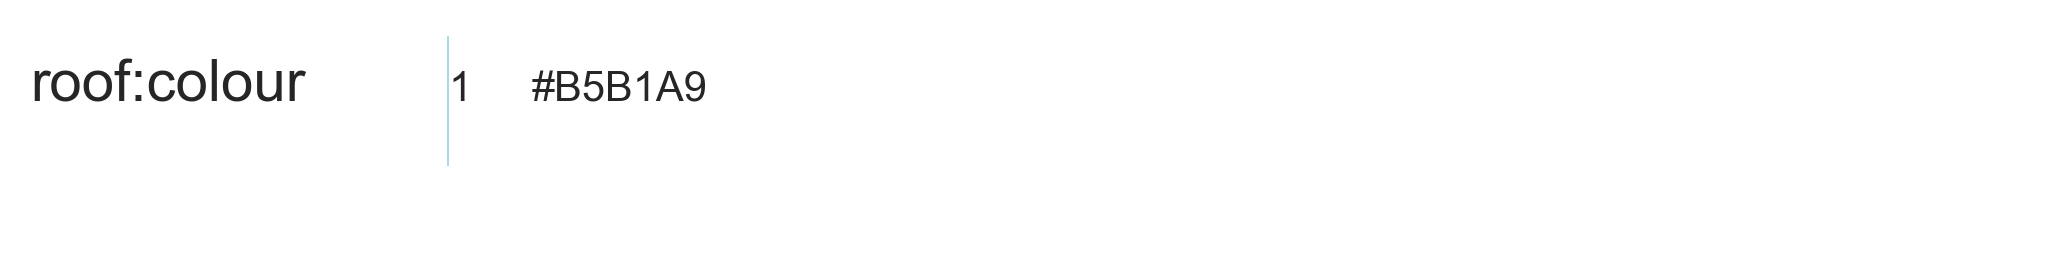

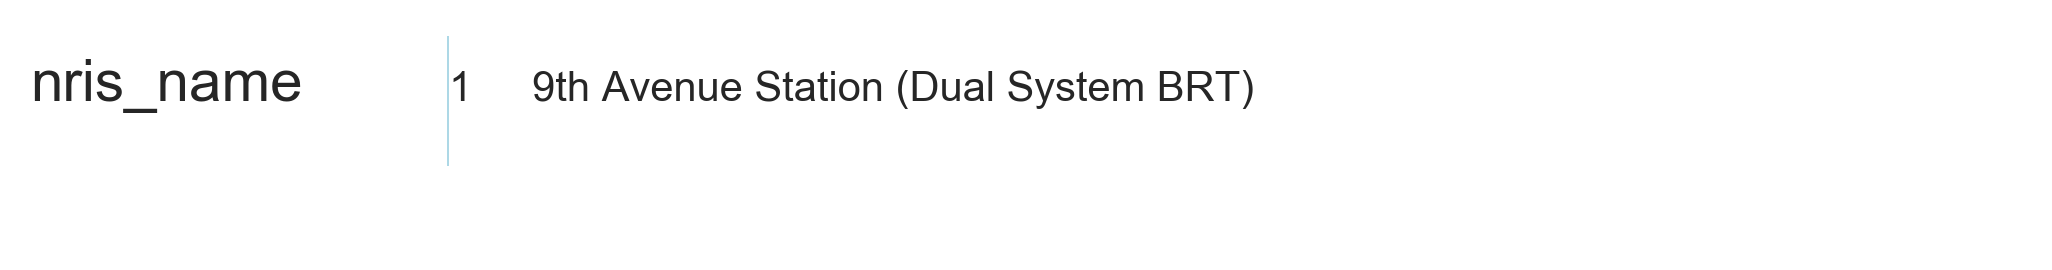

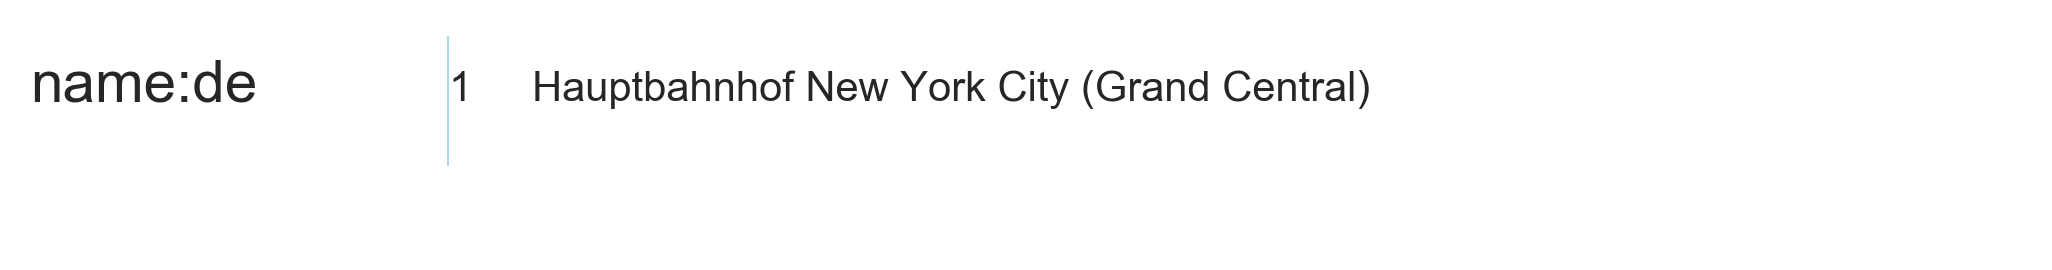

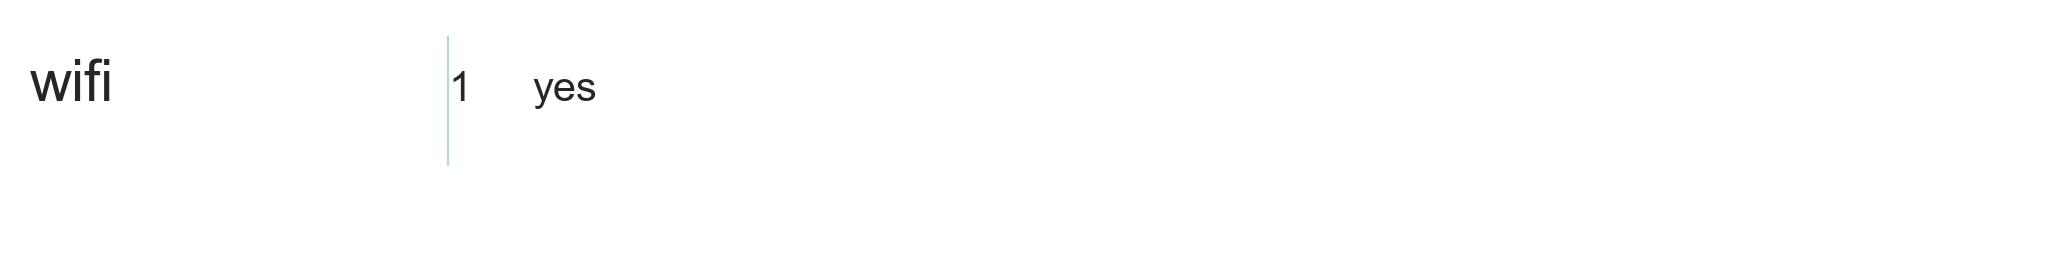

In [41]:
make_many_histograms(key_value_pairs_df, key_value_pairs)